# Evaluating YOLOv8 with Intersection over Union (IoU)

This notebook evaluates the performance of a pretrained YOLOv8 model using the TACO dataset. The main objectives include:
1. Calculating IoU between predicted bounding boxes and ground truth annotations.
2. Visualizing bounding boxes to verify alignment.
3. Summarizing IoU statistics to assess the model's detection accuracy.

Intersection over Union (IoU) is a widely used metric for object detection tasks. It measures the overlap between predicted and actual bounding boxes, providing a quantitative evaluation of localization accuracy.


In [1]:
import json
from ultralytics import YOLO
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar


## Define IoU Calculation Function

A function is defined to compute the Intersection over Union (IoU) between two bounding boxes. IoU is calculated as:
\[
IoU = \frac{\text{Intersection Area}}{\text{Union Area}}
\]

The function ensures that invalid bounding boxes (e.g., zero area) return an IoU of 0.


In [2]:
# Function to calculate IoU
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    return intersection / union if union > 0 else 0

## Load Annotations and Map Categories

This section loads COCO-style annotations and organizes them:
- Categories are mapped to their corresponding supercategories for better organization.
- Bounding boxes are converted from COCO's `(x, y, width, height)` format to `(x_min, y_min, x_max, y_max)` for compatibility with the IoU calculation.

The function `load_annotations_with_supercategories` processes and returns the annotation mapping.


In [3]:
def load_annotations_with_supercategories(annotation_path):
    with open(annotation_path, 'r') as f:
        data = json.load(f)
    
    # Map category_id to supercategory
    category_id_to_supercategory = {cat['id']: cat['supercategory'] for cat in data['categories']}
    
    # Build a mapping of image_id to bboxes and their categories
    annotations = {}
    for ann in data['annotations']:
        if ann['image_id'] not in annotations:
            annotations[ann['image_id']] = []
        # Convert COCO bbox format (x, y, width, height) to (x_min, y_min, x_max, y_max)
        x_min, y_min, width, height = ann['bbox']
        x_max, y_max = x_min + width, y_min + height
        annotations[ann['image_id']].append({
            "bbox": [x_min, y_min, x_max, y_max],
            "supercategory": category_id_to_supercategory[ann['category_id']]
        })
    return annotations

## Load Pretrained YOLOv8 Model

A pretrained YOLOv8 model is loaded for inference. The notebook uses the lightweight `yolov8n.pt` model for efficient evaluation on the TACO dataset. Larger models can be used for improved accuracy if computational resources allow.


In [4]:
# Load the pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')  # Use 'yolov8n.pt' for a lightweight version

In [5]:
# Path to the folder containing images
image_folder = r"C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split" 

In [6]:
split_names = ["train", "val", "test"]
# Load all annotations
annotation_paths = {
    split: os.path.join(image_folder, f"{split}_annotations.json") for split in split_names
}
annotations = {split: load_annotations_with_supercategories(annotation_paths[split]) for split in split_names}


## Process Dataset and Calculate IoU

Images are iteratively processed to:
1. Load ground truth annotations.
2. Perform YOLOv8 inference to obtain predicted bounding boxes.
3. Calculate IoU between predictions and ground truth for each image.

Progress bars (`tqdm`) provide real-time feedback during processing.


In [7]:
# Loop through splits
for split in split_names:
    split_folder = os.path.join(image_folder, split)
    output_data = []
    print(f"Processing {split} split...")

    for class_name in os.listdir(split_folder):
        class_dir = os.path.join(split_folder, class_name)
        if not os.path.isdir(class_dir):
            continue

        for image_name in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}", unit="image"):
            image_path = os.path.join(class_dir, image_name)

            # Extract image ID from the file name
            image_id = int(os.path.splitext(image_name)[0])

            # Ensure the image has annotations
            if image_id not in annotations[split]:
                print(f"No annotations found for image {image_name}. Skipping.")
                continue

            # Run YOLO on the image
            results = model(image_path)
            detections = results[0].boxes.xyxy.cpu().numpy()

            # If there are no detections, skip the image
            if len(detections) == 0:
                output_data.append({
                    "image_id": image_id,
                    "detected_bbox": None,
                    "actual_bbox": None,
                    "iou": 0,
                    "supercategory": None
                })
                continue

            # Find the detection with the highest IoU among the actual bboxes
            best_iou = 0
            best_detected_bbox = None
            best_actual_bbox = None
            best_supercategory = None

            for annotation in annotations[split][image_id]:
                actual_bbox = annotation["bbox"]
                supercategory = annotation["supercategory"]
                for detected_bbox in detections:
                    iou = calculate_iou(actual_bbox, detected_bbox[:4])
                    if iou > best_iou:
                        best_iou = iou
                        best_detected_bbox = detected_bbox[:4].tolist()
                        best_actual_bbox = actual_bbox
                        best_supercategory = supercategory

            # Append the best result for this image to the output
            output_data.append({
                "image_id": image_id,
                "detected_bbox": best_detected_bbox,
                "actual_bbox": best_actual_bbox,
                "iou": best_iou,
                "supercategory": best_supercategory
            })
    # Save the results for this split
    output_path = os.path.join(image_folder, f"{split}_iou_results.json")
    with open(output_path, 'w') as f:
        json.dump(output_data, f, indent=4)

    print(f"Results saved to {output_path}")

Processing train split...


Processing Aluminium foil:   0%|          | 0/15 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\1083.jpg: 640x480 (no detections), 142.7ms
Speed: 5.7ms preprocess, 142.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Aluminium foil:   7%|▋         | 1/15 [00:03<00:42,  3.05s/image]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\1090.jpg: 640x480 (no detections), 108.6ms
Speed: 1.5ms preprocess, 108.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Aluminium foil:  13%|█▎        | 2/15 [00:03<00:17,  1.37s/image]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\1093.jpg: 416x640 (no detections), 110.8ms
Speed: 0.0ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Aluminium foil:  20%|██        | 3/15 [00:03<00:10,  1.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\1125.jpg: 640x480 (no detections), 88.4ms
Speed: 9.8ms preprocess, 88.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Aluminium foil:  27%|██▋       | 4/15 [00:03<00:06,  1.76image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\1185.jpg: 480x640 (no detections), 89.7ms
Speed: 0.0ms preprocess, 89.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Aluminium foil:  33%|███▎      | 5/15 [00:03<00:04,  2.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\119.jpg: 320x640 1 carrot, 67.5ms
Speed: 5.1ms preprocess, 67.5ms inference, 6.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Aluminium foil:  40%|████      | 6/15 [00:03<00:03,  2.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\1241.jpg: 480x640 (no detections), 99.7ms
Speed: 1.0ms preprocess, 99.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Aluminium foil:  47%|████▋     | 7/15 [00:04<00:02,  3.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\1371.jpg: 480x640 (no detections), 121.1ms
Speed: 8.0ms preprocess, 121.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Aluminium foil:  53%|█████▎    | 8/15 [00:04<00:01,  3.86image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\1391.jpg: 640x384 (no detections), 86.5ms
Speed: 4.0ms preprocess, 86.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Aluminium foil:  60%|██████    | 9/15 [00:04<00:01,  4.29image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\196.jpg: 640x320 (no detections), 70.8ms
Speed: 8.0ms preprocess, 70.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Aluminium foil:  67%|██████▋   | 10/15 [00:04<00:01,  4.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\434.jpg: 640x480 (no detections), 78.7ms
Speed: 5.3ms preprocess, 78.7ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Aluminium foil:  73%|███████▎  | 11/15 [00:04<00:00,  4.76image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\847.jpg: 640x480 1 person, 120.0ms
Speed: 3.1ms preprocess, 120.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Aluminium foil:  80%|████████  | 12/15 [00:05<00:00,  4.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\920.jpg: 640x480 1 bed, 90.6ms
Speed: 2.5ms preprocess, 90.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Aluminium foil:  87%|████████▋ | 13/15 [00:05<00:00,  5.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\921.jpg: 640x480 (no detections), 111.6ms
Speed: 4.7ms preprocess, 111.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Aluminium foil:  93%|█████████▎| 14/15 [00:05<00:00,  4.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Aluminium foil\976.jpg: 480x640 2 birds, 86.9ms
Speed: 0.0ms preprocess, 86.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Battery:   0%|          | 0/1 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Battery\456.jpg: 640x480 (no detections), 80.1ms
Speed: 0.0ms preprocess, 80.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Blister pack:   0%|          | 0/2 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Blister pack\195.jpg: 640x320 (no detections), 68.8ms
Speed: 10.1ms preprocess, 68.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Blister pack:  50%|█████     | 1/2 [00:00<00:00,  6.57image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Blister pack\367.jpg: 384x640 1 motorcycle, 90.5ms
Speed: 0.0ms preprocess, 90.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Bottle:   0%|          | 0/195 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\0.jpg: 640x480 1 person, 1 bottle, 1 pizza, 1 dining table, 1 vase, 131.2ms
Speed: 8.0ms preprocess, 131.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   1%|          | 1/195 [00:00<00:33,  5.76image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\10.jpg: 640x480 (no detections), 96.7ms
Speed: 2.2ms preprocess, 96.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   1%|          | 2/195 [00:00<00:29,  6.44image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1000.jpg: 640x480 (no detections), 90.3ms
Speed: 1.6ms preprocess, 90.3ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   2%|▏         | 3/195 [00:00<00:32,  5.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1008.jpg: 640x480 (no detections), 70.7ms
Speed: 1.1ms preprocess, 70.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   2%|▏         | 4/195 [00:00<00:31,  6.02image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1010.jpg: 640x480 (no detections), 79.7ms
Speed: 6.1ms preprocess, 79.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   3%|▎         | 5/195 [00:00<00:31,  6.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1019.jpg: 640x480 (no detections), 115.0ms
Speed: 0.0ms preprocess, 115.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   3%|▎         | 6/195 [00:01<00:33,  5.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\102.jpg: 320x640 1 bird, 1 kite, 100.0ms
Speed: 8.0ms preprocess, 100.0ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:   4%|▎         | 7/195 [00:01<00:34,  5.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1025.jpg: 640x480 (no detections), 88.8ms
Speed: 1.0ms preprocess, 88.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   4%|▍         | 8/195 [00:01<00:32,  5.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\103.jpg: 320x640 1 bird, 60.8ms
Speed: 0.0ms preprocess, 60.8ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:   5%|▍         | 9/195 [00:01<00:31,  5.90image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\104.jpg: 320x640 (no detections), 63.2ms
Speed: 0.0ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:   5%|▌         | 10/195 [00:01<00:31,  5.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1045.jpg: 640x480 1 bottle, 89.8ms
Speed: 0.0ms preprocess, 89.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   6%|▌         | 11/195 [00:01<00:29,  6.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1063.jpg: 640x480 1 person, 2 cars, 92.7ms
Speed: 0.0ms preprocess, 92.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   6%|▌         | 12/195 [00:02<00:30,  6.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1077.jpg: 640x480 (no detections), 115.6ms
Speed: 0.0ms preprocess, 115.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   7%|▋         | 13/195 [00:02<00:30,  5.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1078.jpg: 480x640 1 bird, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:   7%|▋         | 14/195 [00:02<00:30,  5.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1082.jpg: 480x640 2 boats, 108.2ms
Speed: 0.0ms preprocess, 108.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:   8%|▊         | 15/195 [00:02<00:29,  6.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1084.jpg: 480x640 (no detections), 86.4ms
Speed: 0.0ms preprocess, 86.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:   8%|▊         | 16/195 [00:02<00:30,  5.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1088.jpg: 480x640 1 chair, 87.2ms
Speed: 0.0ms preprocess, 87.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:   9%|▊         | 17/195 [00:02<00:29,  6.08image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1091.jpg: 480x640 (no detections), 88.8ms
Speed: 2.1ms preprocess, 88.8ms inference, 10.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:   9%|▉         | 18/195 [00:03<00:29,  5.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1094.jpg: 480x640 (no detections), 129.0ms
Speed: 0.0ms preprocess, 129.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  10%|▉         | 19/195 [00:03<00:30,  5.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1096.jpg: 640x480 (no detections), 93.5ms
Speed: 0.0ms preprocess, 93.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  10%|█         | 20/195 [00:03<00:29,  5.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1097.jpg: 640x640 1 person, 115.5ms
Speed: 4.0ms preprocess, 115.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Bottle:  11%|█         | 21/195 [00:03<00:30,  5.74image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1106.jpg: 480x640 1 bird, 84.4ms
Speed: 5.7ms preprocess, 84.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  11%|█▏        | 22/195 [00:03<00:30,  5.74image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1107.jpg: 640x480 (no detections), 111.6ms
Speed: 3.0ms preprocess, 111.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  12%|█▏        | 23/195 [00:03<00:31,  5.49image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1110.jpg: 480x640 1 bird, 101.6ms
Speed: 6.0ms preprocess, 101.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  12%|█▏        | 24/195 [00:04<00:31,  5.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1112.jpg: 480x640 1 motorcycle, 109.4ms
Speed: 1.5ms preprocess, 109.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  13%|█▎        | 25/195 [00:04<00:32,  5.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1120.jpg: 640x480 1 bottle, 1 bed, 1 dining table, 98.8ms
Speed: 1.1ms preprocess, 98.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  13%|█▎        | 26/195 [00:04<00:30,  5.48image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1127.jpg: 640x480 1 bottle, 120.1ms
Speed: 3.2ms preprocess, 120.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  14%|█▍        | 27/195 [00:04<00:31,  5.28image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\113.jpg: 640x320 3 cars, 82.0ms
Speed: 1.0ms preprocess, 82.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  14%|█▍        | 28/195 [00:04<00:30,  5.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1131.jpg: 480x640 1 umbrella, 85.9ms
Speed: 2.7ms preprocess, 85.9ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  15%|█▍        | 29/195 [00:05<00:29,  5.57image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1132.jpg: 640x480 (no detections), 90.4ms
Speed: 3.1ms preprocess, 90.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  15%|█▌        | 30/195 [00:05<00:29,  5.62image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1133.jpg: 480x640 1 bird, 80.8ms
Speed: 0.0ms preprocess, 80.8ms inference, 8.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  16%|█▌        | 31/195 [00:05<00:29,  5.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1139.jpg: 480x640 (no detections), 99.8ms
Speed: 1.6ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  16%|█▋        | 32/195 [00:05<00:27,  5.86image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\114.jpg: 320x640 (no detections), 59.2ms
Speed: 1.5ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:  17%|█▋        | 33/195 [00:05<00:26,  6.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1140.jpg: 480x640 (no detections), 68.3ms
Speed: 3.5ms preprocess, 68.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  17%|█▋        | 34/195 [00:05<00:24,  6.54image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1141.jpg: 480x640 1 clock, 76.4ms
Speed: 2.0ms preprocess, 76.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  18%|█▊        | 35/195 [00:05<00:23,  6.90image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1143.jpg: 640x480 1 bird, 98.3ms
Speed: 0.0ms preprocess, 98.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  18%|█▊        | 36/195 [00:06<00:24,  6.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1147.jpg: 480x640 (no detections), 96.8ms
Speed: 0.0ms preprocess, 96.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  19%|█▉        | 37/195 [00:06<00:25,  6.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\115.jpg: 320x640 (no detections), 98.1ms
Speed: 0.0ms preprocess, 98.1ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:  19%|█▉        | 38/195 [00:06<00:25,  6.08image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1160.jpg: 512x640 1 cup, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Bottle:  20%|██        | 39/195 [00:06<00:25,  6.18image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1164.jpg: 640x480 1 kite, 120.2ms
Speed: 0.0ms preprocess, 120.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  21%|██        | 40/195 [00:06<00:26,  5.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1181.jpg: 448x640 1 person, 121.9ms
Speed: 3.4ms preprocess, 121.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Bottle:  21%|██        | 41/195 [00:07<00:32,  4.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1188.jpg: 480x640 3 cars, 109.6ms
Speed: 7.1ms preprocess, 109.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  22%|██▏       | 42/195 [00:07<00:32,  4.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1193.jpg: 480x640 1 bear, 99.1ms
Speed: 0.0ms preprocess, 99.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  22%|██▏       | 43/195 [00:07<00:30,  4.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1211.jpg: 640x480 1 bench, 80.7ms
Speed: 1.0ms preprocess, 80.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  23%|██▎       | 44/195 [00:07<00:28,  5.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\122.jpg: 320x640 1 bottle, 1 chair, 64.5ms
Speed: 3.0ms preprocess, 64.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:  23%|██▎       | 45/195 [00:07<00:26,  5.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1238.jpg: 640x480 1 car, 1 kite, 95.4ms
Speed: 0.0ms preprocess, 95.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  24%|██▎       | 46/195 [00:07<00:25,  5.74image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\124.jpg: 640x320 1 dog, 57.7ms
Speed: 2.2ms preprocess, 57.7ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  24%|██▍       | 47/195 [00:08<00:24,  6.12image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1243.jpg: 480x640 (no detections), 109.5ms
Speed: 0.0ms preprocess, 109.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  25%|██▍       | 48/195 [00:08<00:25,  5.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1249.jpg: 640x480 1 zebra, 89.1ms
Speed: 0.0ms preprocess, 89.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  25%|██▌       | 49/195 [00:08<00:25,  5.76image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1251.jpg: 640x480 1 person, 101.0ms
Speed: 0.0ms preprocess, 101.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  26%|██▌       | 50/195 [00:08<00:25,  5.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1252.jpg: 480x640 1 bench, 1 bottle, 108.3ms
Speed: 0.0ms preprocess, 108.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  26%|██▌       | 51/195 [00:08<00:26,  5.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1268.jpg: 480x640 (no detections), 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  27%|██▋       | 52/195 [00:09<00:25,  5.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1269.jpg: 640x480 (no detections), 98.8ms
Speed: 0.0ms preprocess, 98.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  27%|██▋       | 53/195 [00:09<00:24,  5.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1271.jpg: 480x640 (no detections), 78.7ms
Speed: 0.9ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  28%|██▊       | 54/195 [00:09<00:23,  5.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1272.jpg: 480x640 (no detections), 89.6ms
Speed: 0.0ms preprocess, 89.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  28%|██▊       | 55/195 [00:09<00:23,  5.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1277.jpg: 480x640 (no detections), 79.8ms
Speed: 9.0ms preprocess, 79.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  29%|██▊       | 56/195 [00:09<00:23,  5.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1283.jpg: 480x640 1 carrot, 93.2ms
Speed: 0.0ms preprocess, 93.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  29%|██▉       | 57/195 [00:09<00:23,  5.90image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\130.jpg: 640x320 (no detections), 51.1ms
Speed: 0.0ms preprocess, 51.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  30%|██▉       | 58/195 [00:09<00:21,  6.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1307.jpg: 640x480 1 wine glass, 1 cup, 1 spoon, 78.8ms
Speed: 1.5ms preprocess, 78.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  30%|███       | 59/195 [00:10<00:20,  6.59image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1310.jpg: 640x480 (no detections), 77.1ms
Speed: 0.0ms preprocess, 77.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  31%|███       | 60/195 [00:10<00:20,  6.55image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1311.jpg: 640x480 (no detections), 86.4ms
Speed: 3.5ms preprocess, 86.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  31%|███▏      | 61/195 [00:10<00:21,  6.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1312.jpg: 640x480 (no detections), 119.5ms
Speed: 10.6ms preprocess, 119.5ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  32%|███▏      | 62/195 [00:10<00:22,  5.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1314.jpg: 480x640 1 bench, 82.3ms
Speed: 0.0ms preprocess, 82.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  32%|███▏      | 63/195 [00:10<00:22,  5.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1321.jpg: 480x640 1 banana, 81.6ms
Speed: 3.1ms preprocess, 81.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  33%|███▎      | 64/195 [00:10<00:21,  6.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1328.jpg: 640x480 (no detections), 84.3ms
Speed: 2.0ms preprocess, 84.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  33%|███▎      | 65/195 [00:11<00:21,  5.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1330.jpg: 640x480 1 toilet, 85.0ms
Speed: 3.6ms preprocess, 85.0ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  34%|███▍      | 66/195 [00:11<00:23,  5.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1331.jpg: 640x480 1 snowboard, 81.5ms
Speed: 5.5ms preprocess, 81.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  34%|███▍      | 67/195 [00:11<00:22,  5.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1333.jpg: 640x480 (no detections), 88.9ms
Speed: 1.1ms preprocess, 88.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  35%|███▍      | 68/195 [00:11<00:21,  5.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1335.jpg: 640x480 1 baseball bat, 1 hot dog, 79.0ms
Speed: 2.9ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  35%|███▌      | 69/195 [00:11<00:21,  5.82image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1336.jpg: 640x480 (no detections), 109.0ms
Speed: 0.0ms preprocess, 109.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  36%|███▌      | 70/195 [00:12<00:22,  5.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1337.jpg: 640x480 1 bird, 81.0ms
Speed: 8.3ms preprocess, 81.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  36%|███▋      | 71/195 [00:12<00:21,  5.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1338.jpg: 640x480 2 birds, 82.1ms
Speed: 6.0ms preprocess, 82.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  37%|███▋      | 72/195 [00:12<00:21,  5.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1339.jpg: 640x480 (no detections), 89.4ms
Speed: 0.0ms preprocess, 89.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  37%|███▋      | 73/195 [00:12<00:21,  5.70image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1341.jpg: 480x640 1 sheep, 96.1ms
Speed: 0.0ms preprocess, 96.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  38%|███▊      | 74/195 [00:12<00:21,  5.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1342.jpg: 480x640 (no detections), 93.7ms
Speed: 0.0ms preprocess, 93.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  38%|███▊      | 75/195 [00:12<00:21,  5.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1345.jpg: 480x640 (no detections), 80.7ms
Speed: 0.0ms preprocess, 80.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  39%|███▉      | 76/195 [00:13<00:20,  5.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1347.jpg: 480x640 1 surfboard, 87.2ms
Speed: 0.0ms preprocess, 87.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  39%|███▉      | 77/195 [00:13<00:19,  5.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1348.jpg: 480x640 (no detections), 90.9ms
Speed: 9.0ms preprocess, 90.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  40%|████      | 78/195 [00:13<00:19,  5.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1351.jpg: 640x480 (no detections), 79.6ms
Speed: 1.2ms preprocess, 79.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  41%|████      | 79/195 [00:13<00:19,  5.82image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1361.jpg: 640x480 (no detections), 100.1ms
Speed: 8.8ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  41%|████      | 80/195 [00:13<00:18,  6.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1369.jpg: 480x640 1 bird, 99.2ms
Speed: 0.0ms preprocess, 99.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  42%|████▏     | 81/195 [00:13<00:18,  6.07image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1376.jpg: 640x384 (no detections), 70.0ms
Speed: 8.5ms preprocess, 70.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  42%|████▏     | 82/195 [00:14<00:19,  5.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1377.jpg: 640x384 (no detections), 90.5ms
Speed: 8.9ms preprocess, 90.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  43%|████▎     | 83/195 [00:14<00:19,  5.82image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1389.jpg: 640x384 (no detections), 97.7ms
Speed: 0.0ms preprocess, 97.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  43%|████▎     | 84/195 [00:14<00:19,  5.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\14.jpg: 640x480 1 person, 1 remote, 104.2ms
Speed: 4.5ms preprocess, 104.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  44%|████▎     | 85/195 [00:14<00:18,  5.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1404.jpg: 480x640 1 bird, 100.7ms
Speed: 3.5ms preprocess, 100.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  44%|████▍     | 86/195 [00:14<00:19,  5.63image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1405.jpg: 640x480 1 bicycle, 75.0ms
Speed: 2.9ms preprocess, 75.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  45%|████▍     | 87/195 [00:14<00:18,  5.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1451.jpg: 480x640 2 traffic lights, 90.1ms
Speed: 0.0ms preprocess, 90.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  45%|████▌     | 88/195 [00:15<00:18,  5.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1467.jpg: 640x320 (no detections), 68.5ms
Speed: 2.5ms preprocess, 68.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  46%|████▌     | 89/195 [00:15<00:17,  6.17image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1469.jpg: 640x320 (no detections), 65.5ms
Speed: 3.0ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  46%|████▌     | 90/195 [00:15<00:16,  6.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1470.jpg: 640x320 (no detections), 80.3ms
Speed: 0.0ms preprocess, 80.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  47%|████▋     | 91/195 [00:15<00:17,  6.08image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1475.jpg: 640x320 (no detections), 72.2ms
Speed: 4.3ms preprocess, 72.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  47%|████▋     | 92/195 [00:15<00:16,  6.06image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1476.jpg: 320x640 1 bench, 70.3ms
Speed: 0.0ms preprocess, 70.3ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:  48%|████▊     | 93/195 [00:15<00:17,  5.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1479.jpg: 640x320 3 cars, 70.2ms
Speed: 8.0ms preprocess, 70.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  48%|████▊     | 94/195 [00:16<00:16,  6.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1492.jpg: 640x320 (no detections), 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  49%|████▊     | 95/195 [00:16<00:16,  6.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1494.jpg: 320x640 (no detections), 69.2ms
Speed: 0.0ms preprocess, 69.2ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:  49%|████▉     | 96/195 [00:16<00:16,  6.13image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\1497.jpg: 320x640 1 fire hydrant, 2 bottles, 67.6ms
Speed: 0.0ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:  50%|████▉     | 97/195 [00:16<00:15,  6.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\15.jpg: 640x480 3 bottles, 85.5ms
Speed: 2.0ms preprocess, 85.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  50%|█████     | 98/195 [00:16<00:14,  6.66image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\176.jpg: 640x320 3 umbrellas, 70.2ms
Speed: 0.0ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  51%|█████     | 99/195 [00:16<00:13,  6.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\182.jpg: 320x640 1 bench, 57.6ms
Speed: 2.0ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:  51%|█████▏    | 100/195 [00:16<00:13,  7.07image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\192.jpg: 320x640 1 bird, 1 kite, 59.1ms
Speed: 0.0ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:  52%|█████▏    | 101/195 [00:17<00:13,  7.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\194.jpg: 320x640 (no detections), 65.7ms
Speed: 5.7ms preprocess, 65.7ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:  52%|█████▏    | 102/195 [00:17<00:13,  6.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\198.jpg: 640x320 (no detections), 69.3ms
Speed: 2.0ms preprocess, 69.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  53%|█████▎    | 103/195 [00:17<00:13,  6.70image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\2.jpg: 640x480 1 bed, 104.8ms
Speed: 2.0ms preprocess, 104.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  53%|█████▎    | 104/195 [00:17<00:13,  6.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\220.jpg: 448x640 1 broccoli, 103.3ms
Speed: 2.6ms preprocess, 103.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Bottle:  54%|█████▍    | 105/195 [00:17<00:19,  4.68image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\222.jpg: 448x640 (no detections), 112.3ms
Speed: 6.5ms preprocess, 112.3ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


Processing Bottle:  54%|█████▍    | 106/195 [00:18<00:23,  3.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\227.jpg: 448x640 (no detections), 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Bottle:  55%|█████▍    | 107/195 [00:18<00:25,  3.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\23.jpg: 640x480 2 bottles, 107.1ms
Speed: 8.0ms preprocess, 107.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  55%|█████▌    | 108/195 [00:18<00:21,  4.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\237.jpg: 640x480 1 fire hydrant, 1 cake, 1 vase, 106.7ms
Speed: 0.0ms preprocess, 106.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  56%|█████▌    | 109/195 [00:18<00:19,  4.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\271.jpg: 640x480 1 surfboard, 76.8ms
Speed: 3.0ms preprocess, 76.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  56%|█████▋    | 110/195 [00:19<00:19,  4.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\295.jpg: 640x384 (no detections), 79.3ms
Speed: 0.0ms preprocess, 79.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  57%|█████▋    | 111/195 [00:19<00:18,  4.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\299.jpg: 640x384 1 person, 83.1ms
Speed: 6.9ms preprocess, 83.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  57%|█████▋    | 112/195 [00:19<00:19,  4.33image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\3.jpg: 480x640 (no detections), 107.7ms
Speed: 0.0ms preprocess, 107.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  58%|█████▊    | 113/195 [00:19<00:16,  4.86image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\300.jpg: 640x384 1 potted plant, 86.9ms
Speed: 0.0ms preprocess, 86.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  58%|█████▊    | 114/195 [00:20<00:17,  4.63image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\301.jpg: 640x384 (no detections), 132.1ms
Speed: 4.3ms preprocess, 132.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  59%|█████▉    | 115/195 [00:20<00:19,  4.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\313.jpg: 640x384 (no detections), 84.5ms
Speed: 4.8ms preprocess, 84.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  59%|█████▉    | 116/195 [00:20<00:19,  4.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\325.jpg: 640x384 1 bench, 71.4ms
Speed: 1.5ms preprocess, 71.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  60%|██████    | 117/195 [00:20<00:18,  4.13image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\330.jpg: 640x384 (no detections), 83.2ms
Speed: 5.4ms preprocess, 83.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  61%|██████    | 118/195 [00:21<00:19,  4.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\346.jpg: 640x480 1 bird, 86.9ms
Speed: 4.6ms preprocess, 86.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  61%|██████    | 119/195 [00:21<00:18,  4.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\36.jpg: 640x480 (no detections), 95.4ms
Speed: 5.0ms preprocess, 95.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  62%|██████▏   | 120/195 [00:21<00:15,  4.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\360.jpg: 640x480 (no detections), 88.3ms
Speed: 0.0ms preprocess, 88.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  62%|██████▏   | 121/195 [00:21<00:14,  4.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\369.jpg: 640x384 (no detections), 98.6ms
Speed: 0.0ms preprocess, 98.6ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  63%|██████▎   | 122/195 [00:21<00:14,  4.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\37.jpg: 640x480 (no detections), 103.4ms
Speed: 2.0ms preprocess, 103.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  63%|██████▎   | 123/195 [00:22<00:13,  5.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\380.jpg: 640x480 (no detections), 111.2ms
Speed: 1.2ms preprocess, 111.2ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  64%|██████▎   | 124/195 [00:22<00:14,  4.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\39.jpg: 640x480 (no detections), 109.0ms
Speed: 3.3ms preprocess, 109.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  64%|██████▍   | 125/195 [00:22<00:13,  5.28image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\394.jpg: 480x640 (no detections), 116.3ms
Speed: 0.0ms preprocess, 116.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  65%|██████▍   | 126/195 [00:22<00:14,  4.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\395.jpg: 640x480 1 bottle, 127.4ms
Speed: 3.2ms preprocess, 127.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  65%|██████▌   | 127/195 [00:22<00:15,  4.33image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\410.jpg: 480x640 (no detections), 125.1ms
Speed: 2.7ms preprocess, 125.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  66%|██████▌   | 128/195 [00:23<00:16,  3.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\429.jpg: 640x480 1 vase, 160.9ms
Speed: 4.3ms preprocess, 160.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  66%|██████▌   | 129/195 [00:23<00:18,  3.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\43.jpg: 640x480 2 bottles, 134.3ms
Speed: 3.0ms preprocess, 134.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  67%|██████▋   | 130/195 [00:23<00:16,  3.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\435.jpg: 640x480 (no detections), 122.6ms
Speed: 4.0ms preprocess, 122.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  67%|██████▋   | 131/195 [00:24<00:17,  3.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\440.jpg: 640x480 1 fire hydrant, 126.5ms
Speed: 3.4ms preprocess, 126.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  68%|██████▊   | 132/195 [00:24<00:18,  3.40image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\443.jpg: 640x480 1 toilet, 1 vase, 147.3ms
Speed: 2.7ms preprocess, 147.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  68%|██████▊   | 133/195 [00:24<00:19,  3.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\460.jpg: 640x480 1 bowl, 1 toilet, 140.1ms
Speed: 0.0ms preprocess, 140.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  69%|██████▊   | 134/195 [00:25<00:17,  3.40image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\468.jpg: 480x640 (no detections), 119.5ms
Speed: 3.2ms preprocess, 119.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  69%|██████▉   | 135/195 [00:25<00:16,  3.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\487.jpg: 640x480 1 vase, 92.0ms
Speed: 4.0ms preprocess, 92.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  70%|██████▉   | 136/195 [00:25<00:15,  3.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\493.jpg: 640x480 1 bottle, 140.1ms
Speed: 3.3ms preprocess, 140.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  70%|███████   | 137/195 [00:25<00:15,  3.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\494.jpg: 480x640 (no detections), 110.8ms
Speed: 8.6ms preprocess, 110.8ms inference, 9.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  71%|███████   | 138/195 [00:26<00:14,  3.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\496.jpg: 640x480 2 bottles, 139.1ms
Speed: 0.0ms preprocess, 139.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  71%|███████▏  | 139/195 [00:26<00:14,  3.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\5.jpg: 480x640 2 cups, 1 dining table, 109.9ms
Speed: 1.1ms preprocess, 109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  72%|███████▏  | 140/195 [00:26<00:12,  4.40image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\507.jpg: 640x480 1 book, 111.4ms
Speed: 1.6ms preprocess, 111.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  72%|███████▏  | 141/195 [00:26<00:12,  4.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\508.jpg: 480x640 1 toilet, 128.3ms
Speed: 7.7ms preprocess, 128.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  73%|███████▎  | 142/195 [00:26<00:12,  4.29image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\514.jpg: 480x640 (no detections), 124.6ms
Speed: 0.5ms preprocess, 124.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  73%|███████▎  | 143/195 [00:27<00:12,  4.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\516.jpg: 480x640 1 carrot, 112.0ms
Speed: 4.1ms preprocess, 112.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  74%|███████▍  | 144/195 [00:27<00:12,  4.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\522.jpg: 640x480 (no detections), 117.4ms
Speed: 9.2ms preprocess, 117.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  74%|███████▍  | 145/195 [00:27<00:12,  3.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\524.jpg: 640x480 (no detections), 110.9ms
Speed: 5.1ms preprocess, 110.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  75%|███████▍  | 146/195 [00:27<00:12,  3.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\526.jpg: 640x480 1 carrot, 109.2ms
Speed: 0.4ms preprocess, 109.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  75%|███████▌  | 147/195 [00:28<00:12,  3.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\539.jpg: 640x480 1 person, 1 hot dog, 110.8ms
Speed: 2.6ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  76%|███████▌  | 148/195 [00:28<00:12,  3.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\540.jpg: 640x480 (no detections), 119.7ms
Speed: 3.0ms preprocess, 119.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  76%|███████▋  | 149/195 [00:28<00:12,  3.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\543.jpg: 640x480 (no detections), 124.2ms
Speed: 4.5ms preprocess, 124.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  77%|███████▋  | 150/195 [00:29<00:12,  3.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\549.jpg: 384x640 (no detections), 107.7ms
Speed: 8.8ms preprocess, 107.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


Processing Bottle:  77%|███████▋  | 151/195 [00:29<00:09,  4.41image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\578.jpg: 640x480 (no detections), 92.1ms
Speed: 7.7ms preprocess, 92.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  78%|███████▊  | 152/195 [00:29<00:09,  4.59image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\580.jpg: 640x480 1 person, 1 dog, 101.1ms
Speed: 3.6ms preprocess, 101.1ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  78%|███████▊  | 153/195 [00:29<00:09,  4.49image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\597.jpg: 640x480 1 bird, 122.7ms
Speed: 2.5ms preprocess, 122.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  79%|███████▉  | 154/195 [00:29<00:09,  4.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\60.jpg: 640x480 (no detections), 116.3ms
Speed: 0.0ms preprocess, 116.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  79%|███████▉  | 155/195 [00:30<00:09,  4.40image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\605.jpg: 640x480 (no detections), 129.7ms
Speed: 3.1ms preprocess, 129.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  80%|████████  | 156/195 [00:30<00:09,  4.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\618.jpg: 640x480 1 boat, 1 parking meter, 103.1ms
Speed: 3.2ms preprocess, 103.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  81%|████████  | 157/195 [00:30<00:09,  4.18image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\619.jpg: 640x480 1 bird, 118.0ms
Speed: 1.1ms preprocess, 118.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  81%|████████  | 158/195 [00:30<00:08,  4.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\620.jpg: 480x640 (no detections), 122.5ms
Speed: 2.0ms preprocess, 122.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  82%|████████▏ | 159/195 [00:30<00:07,  4.86image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\650.jpg: 640x480 (no detections), 124.4ms
Speed: 0.0ms preprocess, 124.4ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  82%|████████▏ | 160/195 [00:31<00:07,  4.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\651.jpg: 640x480 (no detections), 99.5ms
Speed: 0.0ms preprocess, 99.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  83%|████████▎ | 161/195 [00:31<00:07,  4.63image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\654.jpg: 640x480 1 surfboard, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  83%|████████▎ | 162/195 [00:31<00:07,  4.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\657.jpg: 640x480 (no detections), 119.9ms
Speed: 10.1ms preprocess, 119.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  84%|████████▎ | 163/195 [00:31<00:07,  4.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\658.jpg: 640x480 1 umbrella, 119.9ms
Speed: 10.3ms preprocess, 119.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  84%|████████▍ | 164/195 [00:32<00:07,  4.23image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\672.jpg: 640x480 1 kite, 118.9ms
Speed: 1.2ms preprocess, 118.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  85%|████████▍ | 165/195 [00:32<00:06,  4.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\673.jpg: 640x480 (no detections), 101.4ms
Speed: 2.6ms preprocess, 101.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  85%|████████▌ | 166/195 [00:32<00:06,  4.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\685.jpg: 480x640 1 bottle, 118.5ms
Speed: 0.0ms preprocess, 118.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  86%|████████▌ | 167/195 [00:32<00:05,  4.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\686.jpg: 640x480 1 bottle, 106.9ms
Speed: 0.0ms preprocess, 106.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  86%|████████▌ | 168/195 [00:32<00:05,  4.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\701.jpg: 480x640 (no detections), 106.8ms
Speed: 2.6ms preprocess, 106.8ms inference, 10.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  87%|████████▋ | 169/195 [00:33<00:05,  4.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\707.jpg: 640x480 1 bottle, 1 refrigerator, 118.4ms
Speed: 0.0ms preprocess, 118.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  87%|████████▋ | 170/195 [00:33<00:05,  4.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\714.jpg: 640x480 (no detections), 93.0ms
Speed: 6.6ms preprocess, 93.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  88%|████████▊ | 171/195 [00:33<00:04,  5.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\716.jpg: 640x480 1 bench, 92.1ms
Speed: 3.6ms preprocess, 92.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  88%|████████▊ | 172/195 [00:33<00:04,  5.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\717.jpg: 640x480 (no detections), 116.3ms
Speed: 0.0ms preprocess, 116.3ms inference, 8.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  89%|████████▊ | 173/195 [00:33<00:04,  4.90image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\724.jpg: 640x480 (no detections), 124.4ms
Speed: 0.0ms preprocess, 124.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  89%|████████▉ | 174/195 [00:34<00:04,  4.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\751.jpg: 480x640 1 bench, 140.9ms
Speed: 0.0ms preprocess, 140.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  90%|████████▉ | 175/195 [00:34<00:04,  4.49image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\753.jpg: 480x640 1 bottle, 114.4ms
Speed: 4.6ms preprocess, 114.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  90%|█████████ | 176/195 [00:34<00:04,  4.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\76.jpg: 640x480 1 bird, 119.2ms
Speed: 10.9ms preprocess, 119.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  91%|█████████ | 177/195 [00:34<00:03,  4.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\764.jpg: 512x640 1 bench, 127.3ms
Speed: 2.6ms preprocess, 127.3ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Bottle:  91%|█████████▏| 178/195 [00:35<00:03,  4.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\765.jpg: 640x480 1 umbrella, 139.6ms
Speed: 0.0ms preprocess, 139.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  92%|█████████▏| 179/195 [00:35<00:03,  4.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\782.jpg: 640x480 1 bird, 107.0ms
Speed: 0.0ms preprocess, 107.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  92%|█████████▏| 180/195 [00:35<00:03,  4.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\789.jpg: 640x480 (no detections), 95.2ms
Speed: 0.0ms preprocess, 95.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  93%|█████████▎| 181/195 [00:35<00:02,  4.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\793.jpg: 640x480 1 bottle, 101.3ms
Speed: 2.3ms preprocess, 101.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  93%|█████████▎| 182/195 [00:35<00:02,  5.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\794.jpg: 640x480 1 person, 1 bottle, 89.8ms
Speed: 1.1ms preprocess, 89.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  94%|█████████▍| 183/195 [00:36<00:02,  5.23image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\803.jpg: 640x480 1 person, 1 backpack, 1 handbag, 1 bottle, 1 chair, 119.0ms
Speed: 3.0ms preprocess, 119.0ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  94%|█████████▍| 184/195 [00:36<00:02,  5.18image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\830.jpg: 640x480 1 bench, 1 bottle, 98.4ms
Speed: 0.0ms preprocess, 98.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  95%|█████████▍| 185/195 [00:36<00:01,  5.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\84.jpg: 640x480 2 bottles, 119.7ms
Speed: 0.0ms preprocess, 119.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  95%|█████████▌| 186/195 [00:36<00:01,  5.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\840.jpg: 640x480 1 bottle, 1 dining table, 111.8ms
Speed: 0.0ms preprocess, 111.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  96%|█████████▌| 187/195 [00:36<00:01,  5.33image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\849.jpg: 640x480 (no detections), 119.0ms
Speed: 6.5ms preprocess, 119.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  96%|█████████▋| 188/195 [00:36<00:01,  5.07image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\855.jpg: 480x640 1 bird, 110.4ms
Speed: 2.7ms preprocess, 110.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  97%|█████████▋| 189/195 [00:37<00:01,  5.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\860.jpg: 640x480 3 persons, 112.0ms
Speed: 2.5ms preprocess, 112.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  97%|█████████▋| 190/195 [00:37<00:01,  4.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\965.jpg: 480x640 1 sports ball, 110.6ms
Speed: 0.0ms preprocess, 110.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  98%|█████████▊| 191/195 [00:37<00:00,  4.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\974.jpg: 480x640 (no detections), 110.1ms
Speed: 8.7ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  98%|█████████▊| 192/195 [00:37<00:00,  4.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\975.jpg: 480x640 1 bird, 121.6ms
Speed: 0.0ms preprocess, 121.6ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  99%|█████████▉| 193/195 [00:38<00:00,  4.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\995.jpg: 640x480 (no detections), 116.3ms
Speed: 6.0ms preprocess, 116.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  99%|█████████▉| 194/195 [00:38<00:00,  4.49image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle\996.jpg: 640x480 (no detections), 119.4ms
Speed: 0.0ms preprocess, 119.4ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:   0%|          | 0/46 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\1108.jpg: 640x480 (no detections), 129.8ms
Speed: 0.0ms preprocess, 129.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:   2%|▏         | 1/46 [00:00<00:10,  4.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\1284.jpg: 480x640 (no detections), 99.1ms
Speed: 1.7ms preprocess, 99.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:   4%|▍         | 2/46 [00:00<00:08,  4.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\140.jpg: 640x320 2 persons, 80.9ms
Speed: 0.0ms preprocess, 80.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle cap:   7%|▋         | 3/46 [00:00<00:08,  4.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\1426.jpg: 640x480 (no detections), 146.7ms
Speed: 1.1ms preprocess, 146.7ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:   9%|▊         | 4/46 [00:00<00:09,  4.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\146.jpg: 640x320 (no detections), 98.5ms
Speed: 0.0ms preprocess, 98.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle cap:  11%|█         | 5/46 [00:01<00:08,  4.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\224.jpg: 448x640 (no detections), 108.1ms
Speed: 2.8ms preprocess, 108.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Bottle cap:  13%|█▎        | 6/46 [00:01<00:10,  3.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\225.jpg: 448x640 (no detections), 115.8ms
Speed: 0.0ms preprocess, 115.8ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Bottle cap:  15%|█▌        | 7/46 [00:01<00:12,  3.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\258.jpg: 640x480 1 sports ball, 120.7ms
Speed: 2.7ms preprocess, 120.7ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  17%|█▋        | 8/46 [00:02<00:11,  3.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\286.jpg: 640x480 1 person, 1 frisbee, 111.8ms
Speed: 1.7ms preprocess, 111.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  20%|█▉        | 9/46 [00:02<00:09,  3.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\294.jpg: 480x640 (no detections), 117.7ms
Speed: 3.3ms preprocess, 117.7ms inference, 9.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  22%|██▏       | 10/46 [00:02<00:09,  3.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\307.jpg: 640x384 (no detections), 114.3ms
Speed: 0.0ms preprocess, 114.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle cap:  24%|██▍       | 11/46 [00:02<00:08,  4.06image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\315.jpg: 640x384 (no detections), 117.3ms
Speed: 0.0ms preprocess, 117.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle cap:  26%|██▌       | 12/46 [00:03<00:08,  3.90image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\326.jpg: 640x384 1 frisbee, 84.6ms
Speed: 0.0ms preprocess, 84.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle cap:  28%|██▊       | 13/46 [00:03<00:08,  3.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\342.jpg: 640x384 1 frisbee, 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle cap:  30%|███       | 14/46 [00:03<00:08,  3.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\343.jpg: 640x384 (no detections), 85.1ms
Speed: 7.0ms preprocess, 85.1ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle cap:  33%|███▎      | 15/46 [00:03<00:07,  4.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\413.jpg: 480x640 1 frisbee, 109.9ms
Speed: 3.1ms preprocess, 109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  35%|███▍      | 16/46 [00:04<00:07,  4.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\482.jpg: 640x480 1 frisbee, 119.3ms
Speed: 0.0ms preprocess, 119.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  37%|███▋      | 17/46 [00:04<00:07,  4.03image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\485.jpg: 480x640 1 fire hydrant, 118.8ms
Speed: 4.0ms preprocess, 118.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  39%|███▉      | 18/46 [00:04<00:07,  3.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\491.jpg: 480x640 1 frisbee, 1 clock, 111.6ms
Speed: 2.6ms preprocess, 111.6ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  41%|████▏     | 19/46 [00:04<00:06,  3.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\541.jpg: 640x480 1 frisbee, 94.2ms
Speed: 3.5ms preprocess, 94.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  43%|████▎     | 20/46 [00:05<00:06,  4.07image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\544.jpg: 480x640 (no detections), 89.7ms
Speed: 0.0ms preprocess, 89.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  46%|████▌     | 21/46 [00:05<00:06,  4.07image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\545.jpg: 640x480 (no detections), 79.9ms
Speed: 9.0ms preprocess, 79.9ms inference, 10.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  48%|████▊     | 22/46 [00:05<00:05,  4.23image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\552.jpg: 480x640 1 sports ball, 116.6ms
Speed: 5.0ms preprocess, 116.6ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  50%|█████     | 23/46 [00:05<00:05,  4.13image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\557.jpg: 640x480 1 fire hydrant, 119.8ms
Speed: 3.0ms preprocess, 119.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  52%|█████▏    | 24/46 [00:06<00:05,  3.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\576.jpg: 640x480 1 sports ball, 100.0ms
Speed: 3.5ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  54%|█████▍    | 25/46 [00:06<00:05,  3.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\579.jpg: 640x480 (no detections), 112.0ms
Speed: 3.5ms preprocess, 112.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  57%|█████▋    | 26/46 [00:06<00:04,  4.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\592.jpg: 640x480 1 sports ball, 126.2ms
Speed: 0.0ms preprocess, 126.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  59%|█████▊    | 27/46 [00:06<00:04,  3.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\602.jpg: 640x480 (no detections), 143.9ms
Speed: 3.0ms preprocess, 143.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  61%|██████    | 28/46 [00:07<00:04,  3.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\645.jpg: 640x480 1 clock, 100.1ms
Speed: 2.7ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  63%|██████▎   | 29/46 [00:07<00:04,  4.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\664.jpg: 480x640 (no detections), 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  65%|██████▌   | 30/46 [00:07<00:03,  4.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\668.jpg: 640x480 1 frisbee, 115.2ms
Speed: 0.0ms preprocess, 115.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  67%|██████▋   | 31/46 [00:07<00:03,  4.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\669.jpg: 640x480 1 clock, 120.3ms
Speed: 6.2ms preprocess, 120.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  70%|██████▉   | 32/46 [00:07<00:02,  4.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\740.jpg: 480x640 1 sports ball, 99.4ms
Speed: 2.1ms preprocess, 99.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  72%|███████▏  | 33/46 [00:08<00:02,  4.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\741.jpg: 480x640 1 sports ball, 120.3ms
Speed: 0.0ms preprocess, 120.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  74%|███████▍  | 34/46 [00:08<00:02,  4.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\749.jpg: 480x640 1 fire hydrant, 1 sports ball, 115.1ms
Speed: 6.0ms preprocess, 115.1ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  76%|███████▌  | 35/46 [00:08<00:02,  4.57image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\878.jpg: 640x480 2 donuts, 133.1ms
Speed: 0.0ms preprocess, 133.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  78%|███████▊  | 36/46 [00:08<00:02,  4.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\899.jpg: 480x640 (no detections), 129.7ms
Speed: 0.0ms preprocess, 129.7ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  80%|████████  | 37/46 [00:08<00:01,  4.54image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\931.jpg: 640x480 (no detections), 121.7ms
Speed: 7.7ms preprocess, 121.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  83%|████████▎ | 38/46 [00:09<00:01,  4.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\932.jpg: 640x480 (no detections), 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  85%|████████▍ | 39/46 [00:09<00:01,  4.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\937.jpg: 480x640 (no detections), 100.2ms
Speed: 6.7ms preprocess, 100.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  87%|████████▋ | 40/46 [00:09<00:01,  4.73image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\94.jpg: 640x480 1 frisbee, 117.6ms
Speed: 0.0ms preprocess, 117.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  89%|████████▉ | 41/46 [00:09<00:01,  4.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\942.jpg: 480x640 (no detections), 129.9ms
Speed: 1.0ms preprocess, 129.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  91%|█████████▏| 42/46 [00:09<00:00,  4.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\960.jpg: 480x640 1 person, 130.3ms
Speed: 0.0ms preprocess, 130.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  93%|█████████▎| 43/46 [00:10<00:00,  4.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\961.jpg: 640x480 (no detections), 128.2ms
Speed: 3.5ms preprocess, 128.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  96%|█████████▌| 44/46 [00:10<00:00,  3.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\979.jpg: 640x480 (no detections), 132.2ms
Speed: 0.0ms preprocess, 132.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  98%|█████████▊| 45/46 [00:10<00:00,  3.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Bottle cap\981.jpg: 480x640 1 baseball bat, 1 bowl, 119.2ms
Speed: 0.0ms preprocess, 119.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Broken glass:   0%|          | 0/3 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Broken glass\1365.jpg: 640x480 (no detections), 119.5ms
Speed: 0.0ms preprocess, 119.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Broken glass:  33%|███▎      | 1/3 [00:00<00:00,  4.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Broken glass\598.jpg: 640x480 (no detections), 133.0ms
Speed: 2.0ms preprocess, 133.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Broken glass:  67%|██████▋   | 2/3 [00:00<00:00,  3.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Broken glass\617.jpg: 640x480 2 birds, 2 sheeps, 129.4ms
Speed: 0.0ms preprocess, 129.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:   0%|          | 0/80 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1002.jpg: 480x640 (no detections), 130.0ms
Speed: 0.0ms preprocess, 130.0ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:   1%|▏         | 1/80 [00:00<00:19,  4.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1020.jpg: 640x480 2 birds, 120.2ms
Speed: 10.1ms preprocess, 120.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:   2%|▎         | 2/80 [00:00<00:20,  3.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1021.jpg: 480x640 (no detections), 135.0ms
Speed: 0.0ms preprocess, 135.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:   4%|▍         | 3/80 [00:00<00:19,  4.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1024.jpg: 480x640 (no detections), 108.1ms
Speed: 0.7ms preprocess, 108.1ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:   5%|▌         | 4/80 [00:00<00:18,  4.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1030.jpg: 640x480 (no detections), 114.5ms
Speed: 1.1ms preprocess, 114.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:   6%|▋         | 5/80 [00:01<00:17,  4.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1033.jpg: 640x480 (no detections), 118.3ms
Speed: 2.1ms preprocess, 118.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:   8%|▊         | 6/80 [00:01<00:17,  4.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1034.jpg: 640x480 1 car, 110.2ms
Speed: 3.0ms preprocess, 110.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:   9%|▉         | 7/80 [00:01<00:16,  4.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1056.jpg: 480x640 (no detections), 119.0ms
Speed: 8.1ms preprocess, 119.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  10%|█         | 8/80 [00:01<00:16,  4.41image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1061.jpg: 640x480 1 bird, 121.9ms
Speed: 8.4ms preprocess, 121.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  11%|█▏        | 9/80 [00:02<00:16,  4.41image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1066.jpg: 640x480 1 potted plant, 122.3ms
Speed: 7.6ms preprocess, 122.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  12%|█▎        | 10/80 [00:02<00:15,  4.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1101.jpg: 480x640 (no detections), 122.9ms
Speed: 10.5ms preprocess, 122.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  14%|█▍        | 11/80 [00:02<00:14,  4.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1137.jpg: 480x640 (no detections), 122.3ms
Speed: 0.0ms preprocess, 122.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  15%|█▌        | 12/80 [00:02<00:15,  4.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1196.jpg: 480x640 (no detections), 122.4ms
Speed: 4.0ms preprocess, 122.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  16%|█▋        | 13/80 [00:03<00:16,  4.18image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1256.jpg: 640x480 (no detections), 129.5ms
Speed: 0.0ms preprocess, 129.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  18%|█▊        | 14/80 [00:03<00:15,  4.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\126.jpg: 640x320 (no detections), 104.8ms
Speed: 0.0ms preprocess, 104.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Can:  19%|█▉        | 15/80 [00:03<00:14,  4.40image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1276.jpg: 480x640 (no detections), 125.0ms
Speed: 0.0ms preprocess, 125.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  20%|██        | 16/80 [00:03<00:14,  4.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1315.jpg: 480x640 (no detections), 106.2ms
Speed: 5.0ms preprocess, 106.2ms inference, 6.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  21%|██▏       | 17/80 [00:03<00:14,  4.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1318.jpg: 640x480 1 suitcase, 102.5ms
Speed: 0.0ms preprocess, 102.5ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  22%|██▎       | 18/80 [00:04<00:13,  4.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\135.jpg: 640x320 (no detections), 80.5ms
Speed: 1.1ms preprocess, 80.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Can:  24%|██▍       | 19/80 [00:04<00:12,  4.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1359.jpg: 640x480 (no detections), 108.0ms
Speed: 1.8ms preprocess, 108.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  25%|██▌       | 20/80 [00:04<00:11,  5.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1374.jpg: 640x384 (no detections), 85.7ms
Speed: 3.0ms preprocess, 85.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Can:  26%|██▋       | 21/80 [00:04<00:11,  5.28image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1387.jpg: 640x384 1 person, 86.5ms
Speed: 0.0ms preprocess, 86.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 384)


Processing Can:  28%|██▊       | 22/80 [00:04<00:10,  5.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1397.jpg: 640x384 2 cars, 125.6ms
Speed: 0.0ms preprocess, 125.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Can:  29%|██▉       | 23/80 [00:05<00:11,  4.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1401.jpg: 480x640 (no detections), 110.1ms
Speed: 7.6ms preprocess, 110.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  30%|███       | 24/80 [00:05<00:11,  4.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\1483.jpg: 640x320 1 stop sign, 90.0ms
Speed: 2.0ms preprocess, 90.0ms inference, 8.7ms postprocess per image at shape (1, 3, 640, 320)


Processing Can:  31%|███▏      | 25/80 [00:05<00:11,  4.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\16.jpg: 640x480 1 person, 1 bottle, 1 chair, 1 dining table, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  32%|███▎      | 26/80 [00:05<00:10,  5.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\18.jpg: 640x480 (no detections), 97.3ms
Speed: 6.0ms preprocess, 97.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  34%|███▍      | 27/80 [00:05<00:09,  5.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\19.jpg: 640x480 1 umbrella, 115.9ms
Speed: 3.1ms preprocess, 115.9ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  35%|███▌      | 28/80 [00:05<00:08,  5.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\20.jpg: 480x640 2 cups, 1 dining table, 114.3ms
Speed: 0.0ms preprocess, 114.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  36%|███▋      | 29/80 [00:06<00:08,  6.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\22.jpg: 640x480 1 bottle, 116.8ms
Speed: 0.0ms preprocess, 116.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  38%|███▊      | 30/80 [00:06<00:08,  6.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\242.jpg: 640x480 (no detections), 121.6ms
Speed: 0.0ms preprocess, 121.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  39%|███▉      | 31/80 [00:06<00:09,  4.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\249.jpg: 640x480 1 umbrella, 1 kite, 128.7ms
Speed: 2.5ms preprocess, 128.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  40%|████      | 32/80 [00:06<00:11,  4.29image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\28.jpg: 640x480 (no detections), 119.9ms
Speed: 3.9ms preprocess, 119.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  41%|████▏     | 33/80 [00:07<00:10,  4.66image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\29.jpg: 640x480 (no detections), 128.7ms
Speed: 2.0ms preprocess, 128.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  42%|████▎     | 34/80 [00:07<00:09,  4.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\309.jpg: 640x384 1 bottle, 107.8ms
Speed: 0.0ms preprocess, 107.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


Processing Can:  44%|████▍     | 35/80 [00:07<00:10,  4.15image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\31.jpg: 640x480 (no detections), 125.4ms
Speed: 0.0ms preprocess, 125.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  45%|████▌     | 36/80 [00:07<00:09,  4.48image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\319.jpg: 640x384 1 person, 152.1ms
Speed: 8.1ms preprocess, 152.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Can:  46%|████▋     | 37/80 [00:08<00:11,  3.84image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\33.jpg: 480x640 1 dining table, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  48%|████▊     | 38/80 [00:08<00:09,  4.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\354.jpg: 640x384 (no detections), 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Can:  49%|████▉     | 39/80 [00:08<00:09,  4.16image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\378.jpg: 640x480 1 potted plant, 115.1ms
Speed: 5.3ms preprocess, 115.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  50%|█████     | 40/80 [00:08<00:10,  3.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\41.jpg: 640x480 (no detections), 120.2ms
Speed: 0.0ms preprocess, 120.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  51%|█████▏    | 41/80 [00:08<00:08,  4.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\428.jpg: 640x480 (no detections), 109.0ms
Speed: 1.0ms preprocess, 109.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  52%|█████▎    | 42/80 [00:09<00:08,  4.33image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\44.jpg: 480x640 2 bottles, 1 cup, 120.3ms
Speed: 9.6ms preprocess, 120.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  54%|█████▍    | 43/80 [00:09<00:07,  4.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\45.jpg: 480x640 (no detections), 100.6ms
Speed: 0.0ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  55%|█████▌    | 44/80 [00:09<00:06,  5.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\46.jpg: 480x640 1 bottle, 1 remote, 119.7ms
Speed: 9.1ms preprocess, 119.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  56%|█████▋    | 45/80 [00:09<00:06,  5.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\483.jpg: 640x480 (no detections), 137.0ms
Speed: 8.0ms preprocess, 137.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  57%|█████▊    | 46/80 [00:09<00:07,  4.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\489.jpg: 480x640 1 stop sign, 159.9ms
Speed: 9.3ms preprocess, 159.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  59%|█████▉    | 47/80 [00:10<00:08,  4.07image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\495.jpg: 480x640 (no detections), 148.4ms
Speed: 0.0ms preprocess, 148.4ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  60%|██████    | 48/80 [00:10<00:07,  4.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\51.jpg: 640x480 (no detections), 80.8ms
Speed: 9.1ms preprocess, 80.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  61%|██████▏   | 49/80 [00:10<00:07,  4.41image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\52.jpg: 640x480 (no detections), 130.0ms
Speed: 0.0ms preprocess, 130.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  62%|██████▎   | 50/80 [00:10<00:06,  4.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\525.jpg: 640x480 (no detections), 159.8ms
Speed: 0.0ms preprocess, 159.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  64%|██████▍   | 51/80 [00:11<00:06,  4.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\570.jpg: 640x480 (no detections), 85.9ms
Speed: 0.0ms preprocess, 85.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  65%|██████▌   | 52/80 [00:11<00:06,  4.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\6.jpg: 640x480 1 person, 1 bottle, 106.5ms
Speed: 0.0ms preprocess, 106.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  66%|██████▋   | 53/80 [00:11<00:05,  4.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\614.jpg: 640x480 (no detections), 115.1ms
Speed: 11.4ms preprocess, 115.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  68%|██████▊   | 54/80 [00:11<00:05,  4.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\636.jpg: 640x480 1 umbrella, 103.3ms
Speed: 3.0ms preprocess, 103.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  69%|██████▉   | 55/80 [00:11<00:05,  4.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\666.jpg: 480x640 1 sports ball, 118.2ms
Speed: 3.1ms preprocess, 118.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  70%|███████   | 56/80 [00:12<00:06,  3.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\68.jpg: 640x480 1 cup, 1 knife, 1 dining table, 114.8ms
Speed: 1.1ms preprocess, 114.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  71%|███████▏  | 57/80 [00:12<00:05,  4.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\691.jpg: 640x480 (no detections), 89.1ms
Speed: 9.1ms preprocess, 89.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  72%|███████▎  | 58/80 [00:12<00:04,  4.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\709.jpg: 480x640 1 cell phone, 121.5ms
Speed: 6.8ms preprocess, 121.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  74%|███████▍  | 59/80 [00:12<00:04,  4.76image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\710.jpg: 640x480 (no detections), 97.9ms
Speed: 2.2ms preprocess, 97.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  75%|███████▌  | 60/80 [00:13<00:04,  4.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\715.jpg: 640x480 (no detections), 107.9ms
Speed: 4.2ms preprocess, 107.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  76%|███████▋  | 61/80 [00:13<00:03,  4.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\721.jpg: 640x480 (no detections), 134.4ms
Speed: 3.6ms preprocess, 134.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  78%|███████▊  | 62/80 [00:13<00:04,  4.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\722.jpg: 640x480 (no detections), 109.4ms
Speed: 9.1ms preprocess, 109.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  79%|███████▉  | 63/80 [00:13<00:03,  4.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\723.jpg: 640x480 (no detections), 113.3ms
Speed: 0.9ms preprocess, 113.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  80%|████████  | 64/80 [00:13<00:03,  4.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\725.jpg: 640x480 1 umbrella, 120.0ms
Speed: 0.0ms preprocess, 120.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  81%|████████▏ | 65/80 [00:14<00:03,  4.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\727.jpg: 640x480 (no detections), 95.1ms
Speed: 0.0ms preprocess, 95.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  82%|████████▎ | 66/80 [00:14<00:02,  4.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\752.jpg: 480x640 (no detections), 104.1ms
Speed: 5.7ms preprocess, 104.1ms inference, 8.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  84%|████████▍ | 67/80 [00:14<00:02,  4.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\756.jpg: 640x480 (no detections), 80.9ms
Speed: 3.7ms preprocess, 80.9ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  85%|████████▌ | 68/80 [00:14<00:02,  5.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\761.jpg: 640x480 1 car, 1 bus, 2 birds, 96.9ms
Speed: 8.2ms preprocess, 96.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  86%|████████▋ | 69/80 [00:14<00:02,  5.17image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\775.jpg: 640x480 1 bench, 98.9ms
Speed: 1.6ms preprocess, 98.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  88%|████████▊ | 70/80 [00:15<00:01,  5.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\779.jpg: 640x480 (no detections), 118.7ms
Speed: 0.0ms preprocess, 118.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  89%|████████▉ | 71/80 [00:15<00:01,  5.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\805.jpg: 640x480 (no detections), 117.0ms
Speed: 0.0ms preprocess, 117.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  90%|█████████ | 72/80 [00:15<00:01,  4.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\807.jpg: 640x480 (no detections), 110.2ms
Speed: 0.0ms preprocess, 110.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  91%|█████████▏| 73/80 [00:15<00:01,  4.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\818.jpg: 640x480 1 bottle, 113.5ms
Speed: 0.0ms preprocess, 113.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  92%|█████████▎| 74/80 [00:15<00:01,  5.13image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\82.jpg: 480x640 1 refrigerator, 132.0ms
Speed: 0.0ms preprocess, 132.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  94%|█████████▍| 75/80 [00:16<00:00,  5.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\827.jpg: 640x480 1 baseball bat, 120.3ms
Speed: 9.2ms preprocess, 120.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  95%|█████████▌| 76/80 [00:16<00:00,  4.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\828.jpg: 640x480 (no detections), 118.7ms
Speed: 0.0ms preprocess, 118.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  96%|█████████▋| 77/80 [00:16<00:00,  4.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\9.jpg: 640x480 1 bottle, 111.2ms
Speed: 1.7ms preprocess, 111.2ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  98%|█████████▊| 78/80 [00:16<00:00,  5.33image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\951.jpg: 480x640 1 bird, 120.0ms
Speed: 9.8ms preprocess, 120.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  99%|█████████▉| 79/80 [00:16<00:00,  5.16image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Can\966.jpg: 640x480 (no detections), 118.2ms
Speed: 0.0ms preprocess, 118.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:   0%|          | 0/87 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1.jpg: 640x480 1 book, 105.9ms
Speed: 1.8ms preprocess, 105.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:   1%|          | 1/87 [00:00<00:12,  7.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\100.jpg: 640x480 1 bottle, 1 pizza, 1 couch, 1 dining table, 1 book, 90.9ms
Speed: 1.0ms preprocess, 90.9ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:   2%|▏         | 2/87 [00:00<00:13,  6.32image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1001.jpg: 480x640 (no detections), 96.6ms
Speed: 2.8ms preprocess, 96.6ms inference, 8.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:   3%|▎         | 3/87 [00:00<00:14,  5.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1015.jpg: 480x640 (no detections), 128.8ms
Speed: 8.6ms preprocess, 128.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:   5%|▍         | 4/87 [00:00<00:15,  5.27image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1037.jpg: 640x480 1 kite, 1 book, 122.6ms
Speed: 1.8ms preprocess, 122.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:   6%|▌         | 5/87 [00:00<00:16,  4.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1050.jpg: 640x480 (no detections), 115.5ms
Speed: 0.0ms preprocess, 115.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:   7%|▋         | 6/87 [00:01<00:16,  5.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1065.jpg: 640x480 1 car, 111.0ms
Speed: 0.0ms preprocess, 111.0ms inference, 9.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:   8%|▊         | 7/87 [00:01<00:16,  4.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1085.jpg: 640x480 (no detections), 109.1ms
Speed: 2.0ms preprocess, 109.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:   9%|▉         | 8/87 [00:01<00:15,  4.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1104.jpg: 640x480 1 book, 119.8ms
Speed: 1.1ms preprocess, 119.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  10%|█         | 9/87 [00:01<00:15,  4.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1105.jpg: 480x640 1 book, 119.0ms
Speed: 4.1ms preprocess, 119.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  11%|█▏        | 10/87 [00:01<00:15,  5.03image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1119.jpg: 480x640 2 kites, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  13%|█▎        | 11/87 [00:02<00:14,  5.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1121.jpg: 480x640 1 refrigerator, 106.2ms
Speed: 0.0ms preprocess, 106.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  14%|█▍        | 12/87 [00:02<00:13,  5.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1151.jpg: 480x640 1 chair, 1 book, 110.3ms
Speed: 0.0ms preprocess, 110.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  15%|█▍        | 13/87 [00:02<00:13,  5.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1159.jpg: 640x480 1 bottle, 1 book, 89.6ms
Speed: 2.2ms preprocess, 89.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  16%|█▌        | 14/87 [00:02<00:12,  5.72image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1205.jpg: 640x480 (no detections), 112.3ms
Speed: 0.0ms preprocess, 112.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  17%|█▋        | 15/87 [00:02<00:12,  5.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1207.jpg: 640x480 (no detections), 147.8ms
Speed: 2.1ms preprocess, 147.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  18%|█▊        | 16/87 [00:03<00:13,  5.17image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1210.jpg: 640x480 (no detections), 106.8ms
Speed: 4.0ms preprocess, 106.8ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  20%|█▉        | 17/87 [00:03<00:13,  5.08image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1215.jpg: 640x480 (no detections), 120.4ms
Speed: 9.2ms preprocess, 120.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  21%|██        | 18/87 [00:03<00:13,  5.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1235.jpg: 640x480 1 truck, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  22%|██▏       | 19/87 [00:03<00:13,  4.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1237.jpg: 640x480 (no detections), 100.9ms
Speed: 0.0ms preprocess, 100.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  23%|██▎       | 20/87 [00:03<00:13,  5.08image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1253.jpg: 480x640 1 apple, 1 book, 138.9ms
Speed: 0.0ms preprocess, 138.9ms inference, 9.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  24%|██▍       | 21/87 [00:04<00:13,  4.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\128.jpg: 640x320 (no detections), 122.7ms
Speed: 0.0ms preprocess, 122.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  25%|██▌       | 22/87 [00:04<00:13,  4.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\131.jpg: 640x320 4 cars, 91.8ms
Speed: 7.8ms preprocess, 91.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  26%|██▋       | 23/87 [00:04<00:12,  4.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1325.jpg: 640x480 (no detections), 112.9ms
Speed: 0.9ms preprocess, 112.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  28%|██▊       | 24/87 [00:04<00:13,  4.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1332.jpg: 480x640 (no detections), 121.0ms
Speed: 1.0ms preprocess, 121.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  29%|██▊       | 25/87 [00:04<00:13,  4.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1350.jpg: 480x640 (no detections), 126.5ms
Speed: 7.5ms preprocess, 126.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  30%|██▉       | 26/87 [00:05<00:13,  4.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1364.jpg: 640x480 (no detections), 108.7ms
Speed: 2.0ms preprocess, 108.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  31%|███       | 27/87 [00:05<00:11,  5.13image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\137.jpg: 640x320 4 cars, 68.9ms
Speed: 0.1ms preprocess, 68.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  32%|███▏      | 28/87 [00:05<00:10,  5.48image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1378.jpg: 640x384 (no detections), 130.1ms
Speed: 1.0ms preprocess, 130.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Carton:  33%|███▎      | 29/87 [00:05<00:11,  5.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\138.jpg: 320x640 1 person, 87.8ms
Speed: 0.0ms preprocess, 87.8ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Carton:  34%|███▍      | 30/87 [00:05<00:10,  5.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1393.jpg: 640x384 1 person, 98.9ms
Speed: 2.5ms preprocess, 98.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Carton:  36%|███▌      | 31/87 [00:06<00:10,  5.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1450.jpg: 480x640 1 bench, 116.3ms
Speed: 0.5ms preprocess, 116.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  37%|███▋      | 32/87 [00:06<00:11,  4.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1462.jpg: 640x480 1 person, 130.2ms
Speed: 0.0ms preprocess, 130.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  38%|███▊      | 33/87 [00:06<00:11,  4.84image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\147.jpg: 640x320 1 kite, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  39%|███▉      | 34/87 [00:06<00:10,  5.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1485.jpg: 320x640 3 birds, 92.0ms
Speed: 7.8ms preprocess, 92.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Carton:  40%|████      | 35/87 [00:06<00:10,  5.15image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1486.jpg: 640x320 (no detections), 120.0ms
Speed: 2.0ms preprocess, 120.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  41%|████▏     | 36/87 [00:07<00:10,  4.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\1495.jpg: 640x320 (no detections), 100.1ms
Speed: 2.6ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  43%|████▎     | 37/87 [00:07<00:10,  4.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\186.jpg: 640x320 (no detections), 141.6ms
Speed: 4.0ms preprocess, 141.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  44%|████▎     | 38/87 [00:07<00:11,  4.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\189.jpg: 640x320 1 person, 160.2ms
Speed: 9.0ms preprocess, 160.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  45%|████▍     | 39/87 [00:07<00:12,  3.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\204.jpg: 640x320 2 books, 112.3ms
Speed: 8.9ms preprocess, 112.3ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  46%|████▌     | 40/87 [00:08<00:11,  3.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\207.jpg: 640x320 1 potted plant, 1 tv, 146.9ms
Speed: 8.8ms preprocess, 146.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  47%|████▋     | 41/87 [00:08<00:12,  3.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\209.jpg: 640x320 (no detections), 120.1ms
Speed: 1.1ms preprocess, 120.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  48%|████▊     | 42/87 [00:08<00:11,  3.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\210.jpg: 640x320 1 bench, 1 bird, 130.3ms
Speed: 8.8ms preprocess, 130.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  49%|████▉     | 43/87 [00:08<00:11,  3.72image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\212.jpg: 640x320 1 book, 118.3ms
Speed: 0.0ms preprocess, 118.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  51%|█████     | 44/87 [00:09<00:10,  3.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\214.jpg: 640x320 2 persons, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  52%|█████▏    | 45/87 [00:09<00:10,  4.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\215.jpg: 640x320 1 car, 98.4ms
Speed: 3.6ms preprocess, 98.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  53%|█████▎    | 46/87 [00:09<00:09,  4.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\240.jpg: 640x480 (no detections), 134.8ms
Speed: 0.8ms preprocess, 134.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  54%|█████▍    | 47/87 [00:10<00:11,  3.49image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\241.jpg: 640x480 1 umbrella, 109.1ms
Speed: 3.7ms preprocess, 109.1ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  55%|█████▌    | 48/87 [00:10<00:12,  3.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\254.jpg: 480x640 (no detections), 100.0ms
Speed: 8.6ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  56%|█████▋    | 49/87 [00:10<00:11,  3.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\268.jpg: 640x480 (no detections), 111.7ms
Speed: 5.1ms preprocess, 111.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  57%|█████▋    | 50/87 [00:10<00:10,  3.57image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\290.jpg: 640x480 1 suitcase, 116.5ms
Speed: 3.3ms preprocess, 116.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  59%|█████▊    | 51/87 [00:11<00:09,  3.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\297.jpg: 640x384 (no detections), 107.1ms
Speed: 0.0ms preprocess, 107.1ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Carton:  60%|█████▉    | 52/87 [00:11<00:09,  3.72image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\305.jpg: 384x640 1 laptop, 1 book, 118.2ms
Speed: 0.0ms preprocess, 118.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Carton:  61%|██████    | 53/87 [00:11<00:08,  4.07image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\336.jpg: 640x384 (no detections), 92.1ms
Speed: 1.3ms preprocess, 92.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Carton:  62%|██████▏   | 54/87 [00:11<00:09,  3.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\348.jpg: 640x480 2 persons, 112.7ms
Speed: 4.3ms preprocess, 112.7ms inference, 9.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  63%|██████▎   | 55/87 [00:12<00:08,  3.72image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\449.jpg: 640x480 1 bear, 110.0ms
Speed: 0.0ms preprocess, 110.0ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  64%|██████▍   | 56/87 [00:12<00:08,  3.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\453.jpg: 480x640 (no detections), 107.6ms
Speed: 0.0ms preprocess, 107.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  66%|██████▌   | 57/87 [00:12<00:08,  3.62image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\472.jpg: 640x480 (no detections), 101.2ms
Speed: 5.3ms preprocess, 101.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  67%|██████▋   | 58/87 [00:13<00:08,  3.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\479.jpg: 640x480 1 dog, 138.6ms
Speed: 9.7ms preprocess, 138.6ms inference, 10.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  68%|██████▊   | 59/87 [00:13<00:08,  3.27image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\48.jpg: 480x640 1 hot dog, 91.7ms
Speed: 8.5ms preprocess, 91.7ms inference, 10.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  69%|██████▉   | 60/87 [00:13<00:07,  3.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\518.jpg: 480x640 (no detections), 94.7ms
Speed: 1.2ms preprocess, 94.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  70%|███████   | 61/87 [00:13<00:06,  4.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\521.jpg: 480x640 (no detections), 115.3ms
Speed: 8.1ms preprocess, 115.3ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  71%|███████▏  | 62/87 [00:13<00:05,  4.22image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\53.jpg: 640x480 (no detections), 122.0ms
Speed: 0.0ms preprocess, 122.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  72%|███████▏  | 63/87 [00:14<00:05,  4.44image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\572.jpg: 640x480 (no detections), 130.1ms
Speed: 10.9ms preprocess, 130.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  74%|███████▎  | 64/87 [00:14<00:05,  3.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\593.jpg: 640x480 (no detections), 98.3ms
Speed: 0.0ms preprocess, 98.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  75%|███████▍  | 65/87 [00:14<00:05,  4.08image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\610.jpg: 640x480 (no detections), 179.7ms
Speed: 2.4ms preprocess, 179.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  76%|███████▌  | 66/87 [00:15<00:06,  3.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\659.jpg: 640x480 (no detections), 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  77%|███████▋  | 67/87 [00:15<00:05,  3.59image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\697.jpg: 640x480 (no detections), 90.1ms
Speed: 0.0ms preprocess, 90.1ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  78%|███████▊  | 68/87 [00:15<00:04,  4.02image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\70.jpg: 640x480 1 book, 99.0ms
Speed: 2.9ms preprocess, 99.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  79%|███████▉  | 69/87 [00:15<00:04,  4.45image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\745.jpg: 640x480 (no detections), 108.6ms
Speed: 10.0ms preprocess, 108.6ms inference, 9.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  80%|████████  | 70/87 [00:16<00:04,  3.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\750.jpg: 640x480 1 kite, 125.3ms
Speed: 2.0ms preprocess, 125.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  82%|████████▏ | 71/87 [00:16<00:04,  3.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\759.jpg: 640x480 1 frisbee, 113.2ms
Speed: 0.0ms preprocess, 113.2ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  83%|████████▎ | 72/87 [00:16<00:03,  4.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\773.jpg: 480x640 (no detections), 120.7ms
Speed: 8.2ms preprocess, 120.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  84%|████████▍ | 73/87 [00:16<00:03,  4.23image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\774.jpg: 640x480 1 sports ball, 2 apples, 99.5ms
Speed: 6.1ms preprocess, 99.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  85%|████████▌ | 74/87 [00:16<00:03,  4.21image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\787.jpg: 640x480 1 knife, 1 cake, 2 dining tables, 98.0ms
Speed: 2.1ms preprocess, 98.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  86%|████████▌ | 75/87 [00:17<00:02,  4.57image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\795.jpg: 640x480 1 refrigerator, 120.8ms
Speed: 7.5ms preprocess, 120.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  87%|████████▋ | 76/87 [00:17<00:02,  4.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\796.jpg: 640x480 (no detections), 128.1ms
Speed: 8.0ms preprocess, 128.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  89%|████████▊ | 77/87 [00:17<00:02,  4.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\802.jpg: 640x480 1 suitcase, 113.9ms
Speed: 6.2ms preprocess, 113.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  90%|████████▉ | 78/87 [00:17<00:01,  4.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\81.jpg: 640x480 (no detections), 95.2ms
Speed: 4.3ms preprocess, 95.2ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  91%|█████████ | 79/87 [00:18<00:01,  4.44image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\812.jpg: 480x640 (no detections), 115.5ms
Speed: 3.8ms preprocess, 115.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  92%|█████████▏| 80/87 [00:18<00:01,  4.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\816.jpg: 640x480 (no detections), 112.1ms
Speed: 0.0ms preprocess, 112.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  93%|█████████▎| 81/87 [00:18<00:01,  4.62image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\820.jpg: 640x480 1 book, 110.0ms
Speed: 0.0ms preprocess, 110.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  94%|█████████▍| 82/87 [00:18<00:01,  4.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\869.jpg: 480x640 1 book, 1 clock, 103.0ms
Speed: 9.7ms preprocess, 103.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  95%|█████████▌| 83/87 [00:18<00:00,  5.12image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\89.jpg: 480x640 (no detections), 89.4ms
Speed: 0.0ms preprocess, 89.4ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  97%|█████████▋| 84/87 [00:19<00:00,  5.27image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\947.jpg: 640x480 (no detections), 114.3ms
Speed: 2.5ms preprocess, 114.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  98%|█████████▊| 85/87 [00:19<00:00,  5.16image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\99.jpg: 640x480 1 knife, 1 bowl, 1 sandwich, 1 dining table, 1 book, 118.7ms
Speed: 1.4ms preprocess, 118.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  99%|█████████▉| 86/87 [00:19<00:00,  5.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Carton\997.jpg: 640x480 1 car, 1 cake, 129.8ms
Speed: 6.0ms preprocess, 129.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cigarette:   0%|          | 0/6 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cigarette\165.jpg: 320x640 (no detections), 108.4ms
Speed: 8.2ms preprocess, 108.4ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


Processing Cigarette:  17%|█▋        | 1/6 [00:00<00:01,  3.72image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cigarette\292.jpg: 640x480 (no detections), 119.7ms
Speed: 2.2ms preprocess, 119.7ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Cigarette:  33%|███▎      | 2/6 [00:00<00:01,  3.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cigarette\304.jpg: 640x384 (no detections), 150.8ms
Speed: 2.7ms preprocess, 150.8ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 384)


Processing Cigarette:  50%|█████     | 3/6 [00:00<00:00,  3.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cigarette\488.jpg: 640x480 (no detections), 90.6ms
Speed: 1.1ms preprocess, 90.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cigarette:  67%|██████▋   | 4/6 [00:01<00:00,  3.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cigarette\546.jpg: 640x480 1 frisbee, 137.7ms
Speed: 4.0ms preprocess, 137.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cigarette:  83%|████████▎ | 5/6 [00:01<00:00,  3.68image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cigarette\626.jpg: 640x480 1 dog, 89.8ms
Speed: 1.1ms preprocess, 89.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:   0%|          | 0/80 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1007.jpg: 640x480 1 elephant, 104.3ms
Speed: 0.0ms preprocess, 104.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:   1%|▏         | 1/80 [00:00<00:15,  5.02image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1017.jpg: 480x640 (no detections), 104.8ms
Speed: 5.7ms preprocess, 104.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:   2%|▎         | 2/80 [00:00<00:15,  5.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1022.jpg: 480x640 1 kite, 1 bottle, 117.8ms
Speed: 1.3ms preprocess, 117.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:   4%|▍         | 3/80 [00:00<00:15,  5.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1042.jpg: 640x480 (no detections), 149.2ms
Speed: 1.7ms preprocess, 149.2ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:   5%|▌         | 4/80 [00:00<00:17,  4.40image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1043.jpg: 640x480 3 cars, 148.5ms
Speed: 0.0ms preprocess, 148.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:   6%|▋         | 5/80 [00:01<00:18,  4.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1047.jpg: 640x480 1 fire hydrant, 1 toilet, 115.8ms
Speed: 1.7ms preprocess, 115.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:   8%|▊         | 6/80 [00:01<00:18,  4.08image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1051.jpg: 640x480 1 frisbee, 1 sports ball, 1 cup, 149.4ms
Speed: 1.4ms preprocess, 149.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:   9%|▉         | 7/80 [00:01<00:19,  3.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1057.jpg: 640x480 (no detections), 94.0ms
Speed: 0.0ms preprocess, 94.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  10%|█         | 8/80 [00:01<00:17,  4.23image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1062.jpg: 640x480 (no detections), 82.2ms
Speed: 2.1ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  11%|█▏        | 9/80 [00:02<00:14,  4.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1069.jpg: 640x480 1 cup, 105.0ms
Speed: 2.2ms preprocess, 105.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  12%|█▎        | 10/80 [00:02<00:14,  4.84image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1070.jpg: 640x480 (no detections), 120.3ms
Speed: 0.0ms preprocess, 120.3ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  14%|█▍        | 11/80 [00:02<00:14,  4.90image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1074.jpg: 640x480 (no detections), 100.0ms
Speed: 2.1ms preprocess, 100.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  15%|█▌        | 12/80 [00:02<00:13,  5.18image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1076.jpg: 640x480 1 sports ball, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  16%|█▋        | 13/80 [00:02<00:12,  5.17image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1166.jpg: 480x640 (no detections), 115.6ms
Speed: 1.5ms preprocess, 115.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  18%|█▊        | 14/80 [00:02<00:12,  5.36image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1198.jpg: 640x480 1 person, 1 wine glass, 1 cup, 94.1ms
Speed: 3.1ms preprocess, 94.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  19%|█▉        | 15/80 [00:03<00:10,  5.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1200.jpg: 640x480 1 person, 2 cups, 1 dining table, 1 laptop, 131.1ms
Speed: 7.6ms preprocess, 131.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  20%|██        | 16/80 [00:03<00:11,  5.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1208.jpg: 640x480 1 umbrella, 107.3ms
Speed: 3.5ms preprocess, 107.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  21%|██▏       | 17/80 [00:03<00:12,  5.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1217.jpg: 480x640 (no detections), 108.6ms
Speed: 0.0ms preprocess, 108.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  22%|██▎       | 18/80 [00:03<00:12,  5.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1221.jpg: 640x480 2 persons, 1 bench, 1 dog, 1 bear, 138.9ms
Speed: 0.0ms preprocess, 138.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  24%|██▍       | 19/80 [00:03<00:12,  4.76image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1247.jpg: 640x480 2 fire hydrants, 81.5ms
Speed: 6.5ms preprocess, 81.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  25%|██▌       | 20/80 [00:04<00:12,  4.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1254.jpg: 640x480 (no detections), 109.6ms
Speed: 8.1ms preprocess, 109.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  26%|██▋       | 21/80 [00:04<00:11,  5.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1270.jpg: 480x640 (no detections), 90.3ms
Speed: 0.0ms preprocess, 90.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  28%|██▊       | 22/80 [00:04<00:11,  5.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1302.jpg: 480x640 1 bird, 133.2ms
Speed: 3.0ms preprocess, 133.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  29%|██▉       | 23/80 [00:04<00:12,  4.59image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1306.jpg: 480x640 1 surfboard, 80.8ms
Speed: 3.5ms preprocess, 80.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  30%|███       | 24/80 [00:04<00:11,  4.82image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1322.jpg: 640x480 1 car, 1 bus, 1 truck, 114.5ms
Speed: 3.4ms preprocess, 114.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  31%|███▏      | 25/80 [00:05<00:11,  4.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1372.jpg: 640x480 1 suitcase, 166.9ms
Speed: 2.8ms preprocess, 166.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  32%|███▎      | 26/80 [00:05<00:11,  4.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1373.jpg: 640x480 (no detections), 97.4ms
Speed: 0.0ms preprocess, 97.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  34%|███▍      | 27/80 [00:05<00:10,  4.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1380.jpg: 640x384 (no detections), 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Cup:  35%|███▌      | 28/80 [00:05<00:10,  4.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1455.jpg: 480x640 1 person, 106.7ms
Speed: 0.0ms preprocess, 106.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  36%|███▋      | 29/80 [00:06<00:10,  4.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\1466.jpg: 640x480 1 bench, 111.3ms
Speed: 3.2ms preprocess, 111.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  38%|███▊      | 30/80 [00:06<00:10,  4.82image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\17.jpg: 640x480 (no detections), 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  39%|███▉      | 31/80 [00:06<00:08,  5.48image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\190.jpg: 640x320 1 person, 79.2ms
Speed: 2.6ms preprocess, 79.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Cup:  40%|████      | 32/80 [00:06<00:08,  5.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\197.jpg: 640x480 (no detections), 120.1ms
Speed: 0.0ms preprocess, 120.1ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  41%|████▏     | 33/80 [00:06<00:09,  4.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\239.jpg: 640x480 1 vase, 102.9ms
Speed: 6.0ms preprocess, 102.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  42%|████▎     | 34/80 [00:07<00:10,  4.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\243.jpg: 640x480 (no detections), 136.5ms
Speed: 2.3ms preprocess, 136.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  44%|████▍     | 35/80 [00:07<00:11,  3.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\253.jpg: 640x480 1 suitcase, 110.9ms
Speed: 0.5ms preprocess, 110.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  45%|████▌     | 36/80 [00:07<00:11,  3.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\289.jpg: 640x480 (no detections), 107.6ms
Speed: 2.9ms preprocess, 107.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  46%|████▋     | 37/80 [00:07<00:12,  3.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\328.jpg: 640x384 (no detections), 84.9ms
Speed: 0.4ms preprocess, 84.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Cup:  48%|████▊     | 38/80 [00:08<00:11,  3.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\347.jpg: 640x480 (no detections), 99.0ms
Speed: 0.0ms preprocess, 99.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  49%|████▉     | 39/80 [00:08<00:10,  3.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\350.jpg: 640x480 (no detections), 100.4ms
Speed: 1.5ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  50%|█████     | 40/80 [00:08<00:09,  4.02image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\353.jpg: 640x384 (no detections), 88.8ms
Speed: 0.0ms preprocess, 88.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Cup:  51%|█████▏    | 41/80 [00:08<00:09,  4.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\355.jpg: 640x384 1 surfboard, 87.9ms
Speed: 0.0ms preprocess, 87.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Cup:  52%|█████▎    | 42/80 [00:09<00:09,  4.18image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\368.jpg: 640x384 (no detections), 99.5ms
Speed: 0.6ms preprocess, 99.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Cup:  54%|█████▍    | 43/80 [00:09<00:08,  4.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\373.jpg: 640x480 (no detections), 100.9ms
Speed: 7.5ms preprocess, 100.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  55%|█████▌    | 44/80 [00:09<00:08,  4.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\392.jpg: 480x640 1 spoon, 1 carrot, 111.2ms
Speed: 7.5ms preprocess, 111.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  56%|█████▋    | 45/80 [00:09<00:08,  4.29image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\393.jpg: 640x480 1 carrot, 110.6ms
Speed: 8.5ms preprocess, 110.6ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  57%|█████▊    | 46/80 [00:10<00:08,  4.17image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\405.jpg: 640x480 (no detections), 117.6ms
Speed: 0.0ms preprocess, 117.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  59%|█████▉    | 47/80 [00:10<00:08,  3.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\409.jpg: 480x640 (no detections), 89.9ms
Speed: 7.6ms preprocess, 89.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  60%|██████    | 48/80 [00:10<00:08,  3.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\411.jpg: 480x640 (no detections), 120.6ms
Speed: 3.8ms preprocess, 120.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  61%|██████▏   | 49/80 [00:10<00:07,  3.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\415.jpg: 640x384 (no detections), 83.1ms
Speed: 5.5ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Cup:  62%|██████▎   | 50/80 [00:11<00:07,  4.28image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\418.jpg: 640x480 (no detections), 100.4ms
Speed: 3.1ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  64%|██████▍   | 51/80 [00:11<00:06,  4.26image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\457.jpg: 640x480 (no detections), 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  65%|██████▌   | 52/80 [00:11<00:06,  4.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\502.jpg: 480x640 (no detections), 91.0ms
Speed: 9.2ms preprocess, 91.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  66%|██████▋   | 53/80 [00:11<00:06,  4.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\503.jpg: 480x640 1 stop sign, 100.6ms
Speed: 8.5ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  68%|██████▊   | 54/80 [00:11<00:05,  4.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\532.jpg: 640x480 1 train, 95.2ms
Speed: 4.1ms preprocess, 95.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  69%|██████▉   | 55/80 [00:12<00:05,  4.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\534.jpg: 640x480 1 person, 1 kite, 91.0ms
Speed: 2.1ms preprocess, 91.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  70%|███████   | 56/80 [00:12<00:05,  4.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\567.jpg: 640x480 (no detections), 88.9ms
Speed: 0.0ms preprocess, 88.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  71%|███████▏  | 57/80 [00:12<00:05,  4.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\599.jpg: 640x480 (no detections), 90.9ms
Speed: 2.5ms preprocess, 90.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  72%|███████▎  | 58/80 [00:12<00:04,  4.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\603.jpg: 640x480 1 sheep, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  74%|███████▍  | 59/80 [00:12<00:04,  4.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\607.jpg: 640x480 (no detections), 112.3ms
Speed: 1.3ms preprocess, 112.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  75%|███████▌  | 60/80 [00:13<00:04,  4.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\62.jpg: 640x480 1 bird, 117.8ms
Speed: 4.3ms preprocess, 117.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  76%|███████▋  | 61/80 [00:13<00:04,  4.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\637.jpg: 640x480 1 cup, 97.9ms
Speed: 3.5ms preprocess, 97.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  78%|███████▊  | 62/80 [00:13<00:04,  4.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\643.jpg: 640x480 (no detections), 90.2ms
Speed: 0.0ms preprocess, 90.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  79%|███████▉  | 63/80 [00:13<00:03,  4.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\649.jpg: 640x480 (no detections), 99.1ms
Speed: 1.0ms preprocess, 99.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  80%|████████  | 64/80 [00:14<00:03,  4.49image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\684.jpg: 640x480 (no detections), 108.2ms
Speed: 0.0ms preprocess, 108.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  81%|████████▏ | 65/80 [00:14<00:03,  4.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\693.jpg: 640x480 2 cups, 3 chairs, 2 dining tables, 91.4ms
Speed: 1.1ms preprocess, 91.4ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  82%|████████▎ | 66/80 [00:14<00:02,  5.18image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\703.jpg: 640x480 3 persons, 1 skateboard, 1 cup, 94.6ms
Speed: 2.1ms preprocess, 94.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  84%|████████▍ | 67/80 [00:14<00:02,  5.29image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\718.jpg: 640x480 1 bench, 139.6ms
Speed: 8.6ms preprocess, 139.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  85%|████████▌ | 68/80 [00:14<00:02,  4.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\720.jpg: 640x480 (no detections), 112.7ms
Speed: 4.7ms preprocess, 112.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  86%|████████▋ | 69/80 [00:15<00:02,  4.74image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\726.jpg: 640x480 (no detections), 147.7ms
Speed: 10.1ms preprocess, 147.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  88%|████████▊ | 70/80 [00:15<00:02,  4.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\78.jpg: 640x480 (no detections), 154.1ms
Speed: 0.0ms preprocess, 154.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  89%|████████▉ | 71/80 [00:15<00:02,  4.12image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\804.jpg: 640x480 (no detections), 132.2ms
Speed: 2.5ms preprocess, 132.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  90%|█████████ | 72/80 [00:15<00:02,  3.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\811.jpg: 480x640 1 book, 178.7ms
Speed: 4.5ms preprocess, 178.7ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  91%|█████████▏| 73/80 [00:16<00:02,  3.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\845.jpg: 640x480 1 cup, 130.4ms
Speed: 3.2ms preprocess, 130.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  92%|█████████▎| 74/80 [00:16<00:01,  3.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\865.jpg: 480x640 (no detections), 113.0ms
Speed: 4.6ms preprocess, 113.0ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  94%|█████████▍| 75/80 [00:16<00:01,  3.73image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\882.jpg: 480x640 (no detections), 98.8ms
Speed: 0.0ms preprocess, 98.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  95%|█████████▌| 76/80 [00:17<00:01,  3.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\90.jpg: 640x480 1 toilet, 111.0ms
Speed: 0.7ms preprocess, 111.0ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  96%|█████████▋| 77/80 [00:17<00:00,  4.16image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\948.jpg: 480x640 (no detections), 104.5ms
Speed: 0.0ms preprocess, 104.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  98%|█████████▊| 78/80 [00:17<00:00,  4.33image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\986.jpg: 480x640 (no detections), 132.0ms
Speed: 0.0ms preprocess, 132.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  99%|█████████▉| 79/80 [00:17<00:00,  4.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Cup\987.jpg: 480x640 1 sports ball, 101.2ms
Speed: 2.3ms preprocess, 101.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Food waste:   0%|          | 0/1 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Food waste\92.jpg: 640x480 1 person, 120.5ms
Speed: 0.0ms preprocess, 120.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Lid:   0%|          | 0/6 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Lid\433.jpg: 640x480 (no detections), 99.8ms
Speed: 8.1ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Lid:  17%|█▋        | 1/6 [00:00<00:01,  4.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Lid\492.jpg: 640x480 1 carrot, 117.8ms
Speed: 2.3ms preprocess, 117.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Lid:  33%|███▎      | 2/6 [00:00<00:00,  4.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Lid\600.jpg: 640x480 1 frisbee, 121.0ms
Speed: 8.6ms preprocess, 121.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Lid:  50%|█████     | 3/6 [00:00<00:00,  3.76image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Lid\613.jpg: 640x480 1 giraffe, 130.1ms
Speed: 1.7ms preprocess, 130.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Lid:  67%|██████▋   | 4/6 [00:01<00:00,  3.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Lid\628.jpg: 640x480 (no detections), 118.6ms
Speed: 2.5ms preprocess, 118.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Lid:  83%|████████▎ | 5/6 [00:01<00:00,  4.15image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Lid\733.jpg: 640x480 (no detections), 92.7ms
Speed: 0.0ms preprocess, 92.7ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:   0%|          | 0/50 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\1005.jpg: 480x640 (no detections), 104.1ms
Speed: 6.1ms preprocess, 104.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:   2%|▏         | 1/50 [00:00<00:10,  4.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\1259.jpg: 480x640 2 birds, 133.1ms
Speed: 0.0ms preprocess, 133.1ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:   4%|▍         | 2/50 [00:00<00:12,  3.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\1260.jpg: 480x640 1 bird, 147.7ms
Speed: 2.7ms preprocess, 147.7ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:   6%|▌         | 3/50 [00:00<00:12,  3.62image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\1261.jpg: 480x640 1 bird, 144.6ms
Speed: 4.2ms preprocess, 144.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:   8%|▊         | 4/50 [00:01<00:13,  3.36image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\1285.jpg: 640x480 (no detections), 124.8ms
Speed: 0.0ms preprocess, 124.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  10%|█         | 5/50 [00:01<00:13,  3.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\1288.jpg: 640x480 1 person, 118.9ms
Speed: 3.2ms preprocess, 118.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  12%|█▏        | 6/50 [00:01<00:12,  3.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\129.jpg: 640x320 (no detections), 98.9ms
Speed: 2.1ms preprocess, 98.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Other plastic:  14%|█▍        | 7/50 [00:01<00:11,  3.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\1294.jpg: 480x640 2 birds, 110.4ms
Speed: 3.0ms preprocess, 110.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  16%|█▌        | 8/50 [00:02<00:10,  3.84image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\1295.jpg: 640x480 2 surfboards, 131.3ms
Speed: 0.0ms preprocess, 131.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  18%|█▊        | 9/50 [00:02<00:10,  3.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\1296.jpg: 640x480 1 donut, 98.7ms
Speed: 8.2ms preprocess, 98.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  20%|██        | 10/50 [00:02<00:09,  4.13image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\1297.jpg: 640x480 (no detections), 117.8ms
Speed: 10.3ms preprocess, 117.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  22%|██▏       | 11/50 [00:02<00:09,  4.21image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\1439.jpg: 640x480 (no detections), 107.5ms
Speed: 5.8ms preprocess, 107.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  24%|██▍       | 12/50 [00:03<00:08,  4.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\172.jpg: 640x320 1 person, 64.2ms
Speed: 0.5ms preprocess, 64.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Other plastic:  26%|██▌       | 13/50 [00:03<00:07,  4.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\175.jpg: 640x320 1 person, 74.5ms
Speed: 0.0ms preprocess, 74.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Other plastic:  28%|██▊       | 14/50 [00:03<00:06,  5.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\179.jpg: 640x320 1 potted plant, 1 bed, 70.9ms
Speed: 1.1ms preprocess, 70.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Other plastic:  30%|███       | 15/50 [00:03<00:06,  5.63image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\183.jpg: 320x640 1 person, 1 dog, 71.3ms
Speed: 0.0ms preprocess, 71.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Other plastic:  32%|███▏      | 16/50 [00:03<00:05,  5.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\230.jpg: 640x384 (no detections), 106.7ms
Speed: 0.0ms preprocess, 106.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Other plastic:  34%|███▍      | 17/50 [00:03<00:06,  5.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\432.jpg: 640x480 (no detections), 107.1ms
Speed: 2.1ms preprocess, 107.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  36%|███▌      | 18/50 [00:04<00:06,  4.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\473.jpg: 640x480 1 kite, 89.2ms
Speed: 3.3ms preprocess, 89.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  38%|███▊      | 19/50 [00:04<00:06,  4.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\497.jpg: 480x640 (no detections), 103.7ms
Speed: 2.0ms preprocess, 103.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  40%|████      | 20/50 [00:04<00:06,  4.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\498.jpg: 480x640 1 knife, 106.7ms
Speed: 1.2ms preprocess, 106.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  42%|████▏     | 21/50 [00:04<00:06,  4.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\561.jpg: 640x480 (no detections), 110.7ms
Speed: 4.3ms preprocess, 110.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  44%|████▍     | 22/50 [00:04<00:06,  4.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\571.jpg: 640x480 (no detections), 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  46%|████▌     | 23/50 [00:05<00:06,  4.45image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\574.jpg: 640x480 (no detections), 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  48%|████▊     | 24/50 [00:05<00:05,  4.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\589.jpg: 640x480 (no detections), 91.9ms
Speed: 8.1ms preprocess, 91.9ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  50%|█████     | 25/50 [00:05<00:05,  4.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\625.jpg: 640x480 (no detections), 101.2ms
Speed: 0.0ms preprocess, 101.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  52%|█████▏    | 26/50 [00:05<00:04,  4.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\644.jpg: 640x480 1 bird, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  54%|█████▍    | 27/50 [00:05<00:04,  5.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\739.jpg: 480x640 1 frisbee, 100.7ms
Speed: 2.9ms preprocess, 100.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  56%|█████▌    | 28/50 [00:06<00:04,  5.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\883.jpg: 640x480 (no detections), 145.5ms
Speed: 4.1ms preprocess, 145.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  58%|█████▊    | 29/50 [00:06<00:04,  4.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\887.jpg: 640x480 1 bird, 1 surfboard, 140.0ms
Speed: 0.0ms preprocess, 140.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  60%|██████    | 30/50 [00:06<00:04,  4.63image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\889.jpg: 640x480 1 person, 85.2ms
Speed: 7.7ms preprocess, 85.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  62%|██████▏   | 31/50 [00:06<00:03,  4.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\891.jpg: 640x480 1 bird, 1 sports ball, 101.7ms
Speed: 2.7ms preprocess, 101.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  64%|██████▍   | 32/50 [00:07<00:03,  4.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\893.jpg: 480x640 1 bird, 137.1ms
Speed: 2.0ms preprocess, 137.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  66%|██████▌   | 33/50 [00:07<00:03,  4.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\895.jpg: 480x640 (no detections), 101.9ms
Speed: 4.6ms preprocess, 101.9ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  68%|██████▊   | 34/50 [00:07<00:03,  4.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\897.jpg: 480x640 1 bird, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  70%|███████   | 35/50 [00:07<00:03,  4.82image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\898.jpg: 640x480 1 bird, 110.8ms
Speed: 4.6ms preprocess, 110.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  72%|███████▏  | 36/50 [00:07<00:02,  4.76image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\902.jpg: 640x480 1 frisbee, 94.9ms
Speed: 0.0ms preprocess, 94.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  74%|███████▍  | 37/50 [00:08<00:02,  4.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\903.jpg: 480x640 (no detections), 104.7ms
Speed: 0.0ms preprocess, 104.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  76%|███████▌  | 38/50 [00:08<00:02,  4.90image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\908.jpg: 640x480 (no detections), 90.1ms
Speed: 9.9ms preprocess, 90.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  78%|███████▊  | 39/50 [00:08<00:02,  5.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\919.jpg: 640x480 (no detections), 92.3ms
Speed: 3.0ms preprocess, 92.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  80%|████████  | 40/50 [00:08<00:01,  5.22image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\924.jpg: 480x640 (no detections), 94.0ms
Speed: 3.2ms preprocess, 94.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  82%|████████▏ | 41/50 [00:08<00:01,  5.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\927.jpg: 640x480 (no detections), 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  84%|████████▍ | 42/50 [00:09<00:01,  4.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\929.jpg: 640x480 (no detections), 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  86%|████████▌ | 43/50 [00:09<00:01,  4.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\935.jpg: 480x640 (no detections), 117.6ms
Speed: 0.0ms preprocess, 117.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  88%|████████▊ | 44/50 [00:09<00:01,  4.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\936.jpg: 640x480 (no detections), 84.6ms
Speed: 10.9ms preprocess, 84.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  90%|█████████ | 45/50 [00:09<00:01,  4.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\946.jpg: 480x640 (no detections), 84.1ms
Speed: 5.3ms preprocess, 84.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  92%|█████████▏| 46/50 [00:09<00:00,  5.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\959.jpg: 480x640 1 clock, 98.7ms
Speed: 2.0ms preprocess, 98.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  94%|█████████▍| 47/50 [00:10<00:00,  5.26image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\970.jpg: 480x640 1 truck, 101.2ms
Speed: 0.0ms preprocess, 101.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  96%|█████████▌| 48/50 [00:10<00:00,  5.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\977.jpg: 480x640 2 birds, 121.7ms
Speed: 2.6ms preprocess, 121.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  98%|█████████▊| 49/50 [00:10<00:00,  4.90image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Other plastic\992.jpg: 640x480 (no detections), 119.2ms
Speed: 2.5ms preprocess, 119.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:   0%|          | 0/23 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\1016.jpg: 480x640 (no detections), 119.7ms
Speed: 0.0ms preprocess, 119.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:   4%|▍         | 1/23 [00:00<00:04,  4.86image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\1053.jpg: 640x480 (no detections), 90.9ms
Speed: 0.0ms preprocess, 90.9ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:   9%|▊         | 2/23 [00:00<00:03,  5.26image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\1192.jpg: 480x640 1 person, 1 car, 120.5ms
Speed: 2.3ms preprocess, 120.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:  13%|█▎        | 3/23 [00:00<00:04,  4.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\120.jpg: 640x320 1 car, 1 truck, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Paper:  17%|█▋        | 4/23 [00:00<00:03,  5.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\1293.jpg: 480x640 6 birds, 92.9ms
Speed: 0.0ms preprocess, 92.9ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:  22%|██▏       | 5/23 [00:00<00:03,  5.16image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\1381.jpg: 640x384 (no detections), 101.4ms
Speed: 0.0ms preprocess, 101.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Paper:  26%|██▌       | 6/23 [00:01<00:03,  4.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\1384.jpg: 640x384 (no detections), 138.4ms
Speed: 1.0ms preprocess, 138.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


Processing Paper:  30%|███       | 7/23 [00:01<00:03,  4.55image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\1427.jpg: 640x480 1 sheep, 101.2ms
Speed: 2.5ms preprocess, 101.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  35%|███▍      | 8/23 [00:01<00:03,  4.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\1452.jpg: 480x640 1 bench, 130.0ms
Speed: 0.0ms preprocess, 130.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:  39%|███▉      | 9/23 [00:01<00:03,  4.40image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\1461.jpg: 640x480 (no detections), 132.4ms
Speed: 0.0ms preprocess, 132.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  43%|████▎     | 10/23 [00:02<00:02,  4.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\381.jpg: 480x640 (no detections), 112.3ms
Speed: 6.1ms preprocess, 112.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:  48%|████▊     | 11/23 [00:02<00:02,  4.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\399.jpg: 480x640 (no detections), 119.6ms
Speed: 1.4ms preprocess, 119.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:  52%|█████▏    | 12/23 [00:02<00:02,  4.17image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\54.jpg: 640x480 (no detections), 119.9ms
Speed: 11.5ms preprocess, 119.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  57%|█████▋    | 13/23 [00:02<00:02,  4.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\608.jpg: 640x480 (no detections), 117.7ms
Speed: 0.0ms preprocess, 117.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  61%|██████    | 14/23 [00:03<00:02,  4.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\609.jpg: 640x480 (no detections), 103.8ms
Speed: 0.0ms preprocess, 103.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  65%|██████▌   | 15/23 [00:03<00:01,  4.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\683.jpg: 640x480 (no detections), 116.8ms
Speed: 0.0ms preprocess, 116.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  70%|██████▉   | 16/23 [00:03<00:01,  4.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\699.jpg: 640x480 1 kite, 106.8ms
Speed: 3.1ms preprocess, 106.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  74%|███████▍  | 17/23 [00:03<00:01,  4.63image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\730.jpg: 640x480 (no detections), 108.9ms
Speed: 0.0ms preprocess, 108.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  78%|███████▊  | 18/23 [00:03<00:01,  4.68image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\737.jpg: 640x480 (no detections), 143.2ms
Speed: 0.0ms preprocess, 143.2ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  83%|████████▎ | 19/23 [00:04<00:00,  4.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\742.jpg: 480x640 1 kite, 136.8ms
Speed: 6.4ms preprocess, 136.8ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:  87%|████████▋ | 20/23 [00:04<00:00,  3.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\850.jpg: 640x480 (no detections), 127.8ms
Speed: 0.0ms preprocess, 127.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  91%|█████████▏| 21/23 [00:04<00:00,  4.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\874.jpg: 480x640 5 books, 149.0ms
Speed: 9.2ms preprocess, 149.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:  96%|█████████▌| 22/23 [00:04<00:00,  4.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper\913.jpg: 640x480 1 umbrella, 97.4ms
Speed: 0.0ms preprocess, 97.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper bag:   0%|          | 0/12 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper bag\1041.jpg: 640x480 1 bench, 1 potted plant, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper bag:   8%|▊         | 1/12 [00:00<00:01,  5.82image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper bag\1111.jpg: 480x640 (no detections), 127.5ms
Speed: 5.9ms preprocess, 127.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper bag:  17%|█▋        | 2/12 [00:00<00:02,  4.84image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper bag\1136.jpg: 480x640 1 bed, 92.5ms
Speed: 3.5ms preprocess, 92.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper bag:  25%|██▌       | 3/12 [00:00<00:01,  5.29image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper bag\1154.jpg: 640x480 (no detections), 111.8ms
Speed: 5.5ms preprocess, 111.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper bag:  33%|███▎      | 4/12 [00:00<00:01,  5.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper bag\1242.jpg: 640x480 (no detections), 111.8ms
Speed: 0.0ms preprocess, 111.8ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper bag:  42%|████▏     | 5/12 [00:00<00:01,  5.15image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper bag\1390.jpg: 640x384 1 kite, 100.9ms
Speed: 0.0ms preprocess, 100.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Paper bag:  50%|█████     | 6/12 [00:01<00:01,  4.84image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper bag\523.jpg: 640x640 (no detections), 144.0ms
Speed: 5.9ms preprocess, 144.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Paper bag:  58%|█████▊    | 7/12 [00:01<00:01,  3.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper bag\533.jpg: 480x640 (no detections), 99.9ms
Speed: 1.2ms preprocess, 99.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper bag:  67%|██████▋   | 8/12 [00:01<00:01,  3.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper bag\58.jpg: 640x480 1 person, 94.9ms
Speed: 0.0ms preprocess, 94.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper bag:  75%|███████▌  | 9/12 [00:02<00:00,  4.29image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper bag\611.jpg: 640x480 (no detections), 88.4ms
Speed: 2.1ms preprocess, 88.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper bag:  83%|████████▎ | 10/12 [00:02<00:00,  4.36image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper bag\677.jpg: 480x640 (no detections), 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper bag:  92%|█████████▏| 11/12 [00:02<00:00,  4.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Paper bag\679.jpg: 640x480 1 bench, 1 bottle, 99.4ms
Speed: 1.2ms preprocess, 99.4ms inference, 10.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   0%|          | 0/273 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1009.jpg: 480x640 1 person, 108.5ms
Speed: 0.0ms preprocess, 108.5ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:   0%|          | 1/273 [00:00<00:54,  4.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1011.jpg: 640x480 1 bench, 101.9ms
Speed: 0.0ms preprocess, 101.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   1%|          | 2/273 [00:00<00:49,  5.48image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1014.jpg: 640x480 1 broccoli, 1 pizza, 108.5ms
Speed: 0.0ms preprocess, 108.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   1%|          | 3/273 [00:00<00:49,  5.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1038.jpg: 640x480 (no detections), 100.3ms
Speed: 1.1ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   1%|▏         | 4/273 [00:00<00:48,  5.57image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1040.jpg: 640x480 (no detections), 99.6ms
Speed: 2.3ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   2%|▏         | 5/273 [00:00<00:50,  5.36image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\105.jpg: 640x320 (no detections), 70.6ms
Speed: 8.1ms preprocess, 70.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:   2%|▏         | 6/273 [00:01<00:47,  5.62image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1052.jpg: 640x480 1 pizza, 110.0ms
Speed: 2.2ms preprocess, 110.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   3%|▎         | 7/273 [00:01<00:51,  5.13image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1059.jpg: 640x480 (no detections), 124.9ms
Speed: 1.2ms preprocess, 124.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   3%|▎         | 8/273 [00:01<00:54,  4.84image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\106.jpg: 640x320 (no detections), 105.5ms
Speed: 5.3ms preprocess, 105.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:   3%|▎         | 9/273 [00:01<00:59,  4.45image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\107.jpg: 640x320 (no detections), 101.5ms
Speed: 5.7ms preprocess, 101.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:   4%|▎         | 10/273 [00:02<00:59,  4.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1071.jpg: 640x480 (no detections), 126.4ms
Speed: 3.1ms preprocess, 126.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   4%|▍         | 11/273 [00:02<00:57,  4.57image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1072.jpg: 640x480 (no detections), 99.7ms
Speed: 1.2ms preprocess, 99.7ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   4%|▍         | 12/273 [00:02<00:54,  4.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1073.jpg: 640x480 (no detections), 145.2ms
Speed: 5.2ms preprocess, 145.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   5%|▍         | 13/273 [00:02<00:59,  4.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1075.jpg: 640x480 1 teddy bear, 99.1ms
Speed: 8.3ms preprocess, 99.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   5%|▌         | 14/273 [00:02<00:58,  4.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1079.jpg: 640x480 1 person, 95.8ms
Speed: 0.0ms preprocess, 95.8ms inference, 9.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   5%|▌         | 15/273 [00:03<00:56,  4.59image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1087.jpg: 640x480 (no detections), 98.8ms
Speed: 0.0ms preprocess, 98.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   6%|▌         | 16/273 [00:03<00:54,  4.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1098.jpg: 480x640 1 sports ball, 124.0ms
Speed: 5.8ms preprocess, 124.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:   6%|▌         | 17/273 [00:03<00:54,  4.73image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\11.jpg: 640x480 (no detections), 99.9ms
Speed: 2.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   7%|▋         | 18/273 [00:03<00:49,  5.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1113.jpg: 640x480 2 persons, 89.1ms
Speed: 1.6ms preprocess, 89.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   7%|▋         | 19/273 [00:03<00:46,  5.48image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\112.jpg: 320x640 6 persons, 2 cars, 1 motorcycle, 5 bottles, 3 cups, 2 chairs, 1 dining table, 84.6ms
Speed: 4.6ms preprocess, 84.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:   7%|▋         | 20/273 [00:04<00:44,  5.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1123.jpg: 480x640 6 bottles, 1 oven, 106.3ms
Speed: 0.0ms preprocess, 106.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:   8%|▊         | 21/273 [00:04<00:44,  5.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1129.jpg: 640x480 (no detections), 127.8ms
Speed: 2.8ms preprocess, 127.8ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   8%|▊         | 22/273 [00:04<00:48,  5.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1134.jpg: 480x640 1 pizza, 119.9ms
Speed: 1.7ms preprocess, 119.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:   8%|▊         | 23/273 [00:04<00:49,  5.06image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1156.jpg: 640x480 (no detections), 101.1ms
Speed: 0.0ms preprocess, 101.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   9%|▉         | 24/273 [00:04<00:49,  5.03image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1162.jpg: 640x480 (no detections), 99.1ms
Speed: 6.5ms preprocess, 99.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   9%|▉         | 25/273 [00:05<00:49,  5.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1167.jpg: 640x480 (no detections), 99.5ms
Speed: 0.0ms preprocess, 99.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  10%|▉         | 26/273 [00:05<00:48,  5.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1172.jpg: 640x480 1 chair, 1 dining table, 1 mouse, 2 books, 100.8ms
Speed: 3.1ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  10%|▉         | 27/273 [00:05<00:49,  4.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1173.jpg: 448x640 (no detections), 80.8ms
Speed: 4.1ms preprocess, 80.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Plastic bag & wrapper:  10%|█         | 28/273 [00:05<01:01,  3.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1177.jpg: 448x640 1 car, 121.7ms
Speed: 2.2ms preprocess, 121.7ms inference, 7.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Plastic bag & wrapper:  11%|█         | 29/273 [00:06<01:11,  3.41image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1183.jpg: 448x640 (no detections), 85.6ms
Speed: 5.4ms preprocess, 85.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Plastic bag & wrapper:  11%|█         | 30/273 [00:06<01:23,  2.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1194.jpg: 640x480 1 kite, 105.1ms
Speed: 4.6ms preprocess, 105.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  11%|█▏        | 31/273 [00:06<01:13,  3.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1202.jpg: 480x640 1 umbrella, 102.5ms
Speed: 8.3ms preprocess, 102.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  12%|█▏        | 32/273 [00:07<01:06,  3.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\121.jpg: 640x320 1 chair, 133.2ms
Speed: 1.3ms preprocess, 133.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  12%|█▏        | 33/273 [00:07<01:03,  3.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1213.jpg: 640x480 1 fire hydrant, 1 bottle, 140.8ms
Speed: 8.1ms preprocess, 140.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  12%|█▏        | 34/273 [00:07<01:06,  3.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1218.jpg: 480x640 (no detections), 81.6ms
Speed: 0.0ms preprocess, 81.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  13%|█▎        | 35/273 [00:07<00:57,  4.16image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1219.jpg: 640x480 1 banana, 99.4ms
Speed: 2.2ms preprocess, 99.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  13%|█▎        | 36/273 [00:07<00:53,  4.44image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1223.jpg: 640x480 (no detections), 89.4ms
Speed: 2.9ms preprocess, 89.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  14%|█▎        | 37/273 [00:08<00:51,  4.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1224.jpg: 640x480 1 bird, 84.7ms
Speed: 6.1ms preprocess, 84.7ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  14%|█▍        | 38/273 [00:08<00:49,  4.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1229.jpg: 480x640 (no detections), 100.0ms
Speed: 8.8ms preprocess, 100.0ms inference, 10.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  14%|█▍        | 39/273 [00:08<00:48,  4.86image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\123.jpg: 640x320 1 bird, 1 kite, 79.8ms
Speed: 1.6ms preprocess, 79.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  15%|█▍        | 40/273 [00:08<00:45,  5.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1231.jpg: 640x480 1 person, 90.4ms
Speed: 0.0ms preprocess, 90.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  15%|█▌        | 41/273 [00:08<00:43,  5.33image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1233.jpg: 480x640 (no detections), 112.3ms
Speed: 6.6ms preprocess, 112.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  15%|█▌        | 42/273 [00:09<00:45,  5.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1239.jpg: 640x480 (no detections), 124.7ms
Speed: 0.0ms preprocess, 124.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  16%|█▌        | 43/273 [00:09<00:45,  5.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1248.jpg: 480x640 (no detections), 110.7ms
Speed: 6.8ms preprocess, 110.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  16%|█▌        | 44/273 [00:09<00:51,  4.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1258.jpg: 640x480 (no detections), 90.1ms
Speed: 0.0ms preprocess, 90.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  16%|█▋        | 45/273 [00:09<00:49,  4.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1267.jpg: 480x640 (no detections), 98.7ms
Speed: 1.3ms preprocess, 98.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  17%|█▋        | 46/273 [00:09<00:47,  4.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1286.jpg: 480x640 1 bird, 1 kite, 108.6ms
Speed: 0.0ms preprocess, 108.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  17%|█▋        | 47/273 [00:10<00:48,  4.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1290.jpg: 480x640 (no detections), 95.9ms
Speed: 0.6ms preprocess, 95.9ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  18%|█▊        | 48/273 [00:10<00:46,  4.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1291.jpg: 480x640 (no detections), 94.9ms
Speed: 0.0ms preprocess, 94.9ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  18%|█▊        | 49/273 [00:10<00:46,  4.84image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1298.jpg: 640x480 1 surfboard, 118.8ms
Speed: 5.2ms preprocess, 118.8ms inference, 10.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  18%|█▊        | 50/273 [00:10<00:47,  4.66image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1303.jpg: 480x640 1 bird, 142.0ms
Speed: 0.0ms preprocess, 142.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  19%|█▊        | 51/273 [00:11<00:52,  4.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1305.jpg: 448x640 (no detections), 81.4ms
Speed: 3.8ms preprocess, 81.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Plastic bag & wrapper:  19%|█▉        | 52/273 [00:11<01:10,  3.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\133.jpg: 640x320 (no detections), 90.2ms
Speed: 0.0ms preprocess, 90.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  19%|█▉        | 53/273 [00:11<01:01,  3.55image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1344.jpg: 480x640 1 frisbee, 99.4ms
Speed: 0.0ms preprocess, 99.4ms inference, 9.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  20%|█▉        | 54/273 [00:12<00:56,  3.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1349.jpg: 480x640 (no detections), 108.4ms
Speed: 0.0ms preprocess, 108.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  20%|██        | 55/273 [00:12<00:52,  4.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1353.jpg: 480x640 1 truck, 109.6ms
Speed: 0.0ms preprocess, 109.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  21%|██        | 56/273 [00:12<00:50,  4.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1354.jpg: 480x640 (no detections), 119.1ms
Speed: 3.0ms preprocess, 119.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  21%|██        | 57/273 [00:12<00:44,  4.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1355.jpg: 480x640 (no detections), 112.1ms
Speed: 0.0ms preprocess, 112.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  21%|██        | 58/273 [00:12<00:39,  5.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1356.jpg: 640x480 (no detections), 115.2ms
Speed: 0.0ms preprocess, 115.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  22%|██▏       | 59/273 [00:12<00:36,  5.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1358.jpg: 640x480 (no detections), 92.7ms
Speed: 3.0ms preprocess, 92.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  22%|██▏       | 60/273 [00:13<00:35,  5.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\136.jpg: 640x320 (no detections), 87.4ms
Speed: 0.0ms preprocess, 87.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  22%|██▏       | 61/273 [00:13<00:36,  5.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1360.jpg: 640x480 (no detections), 140.4ms
Speed: 9.2ms preprocess, 140.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  23%|██▎       | 62/273 [00:13<00:36,  5.76image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1367.jpg: 480x640 (no detections), 126.1ms
Speed: 0.0ms preprocess, 126.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  23%|██▎       | 63/273 [00:13<00:41,  5.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1375.jpg: 640x384 (no detections), 116.9ms
Speed: 1.7ms preprocess, 116.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  23%|██▎       | 64/273 [00:13<00:43,  4.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1386.jpg: 640x384 (no detections), 89.6ms
Speed: 0.0ms preprocess, 89.6ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  24%|██▍       | 65/273 [00:14<00:43,  4.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1398.jpg: 640x480 (no detections), 100.2ms
Speed: 9.9ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  24%|██▍       | 66/273 [00:14<00:43,  4.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1403.jpg: 640x480 (no detections), 105.4ms
Speed: 8.8ms preprocess, 105.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  25%|██▍       | 67/273 [00:14<00:43,  4.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1406.jpg: 640x480 1 car, 104.4ms
Speed: 6.9ms preprocess, 104.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  25%|██▍       | 68/273 [00:14<00:42,  4.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1407.jpg: 480x640 1 kite, 129.7ms
Speed: 1.3ms preprocess, 129.7ms inference, 8.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  25%|██▌       | 69/273 [00:14<00:43,  4.68image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1408.jpg: 640x480 1 microwave, 99.8ms
Speed: 1.2ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  26%|██▌       | 70/273 [00:15<00:46,  4.40image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\141.jpg: 320x640 (no detections), 80.0ms
Speed: 1.1ms preprocess, 80.0ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:  26%|██▌       | 71/273 [00:15<00:43,  4.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1410.jpg: 480x640 (no detections), 98.3ms
Speed: 1.8ms preprocess, 98.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  26%|██▋       | 72/273 [00:15<00:42,  4.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1411.jpg: 480x640 (no detections), 92.7ms
Speed: 7.2ms preprocess, 92.7ms inference, 6.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  27%|██▋       | 73/273 [00:15<00:41,  4.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1412.jpg: 480x640 2 persons, 110.9ms
Speed: 0.0ms preprocess, 110.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  27%|██▋       | 74/273 [00:16<00:41,  4.76image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1414.jpg: 480x640 (no detections), 109.0ms
Speed: 0.0ms preprocess, 109.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  27%|██▋       | 75/273 [00:16<00:40,  4.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1416.jpg: 640x480 2 persons, 1 bird, 1 giraffe, 107.3ms
Speed: 0.0ms preprocess, 107.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  28%|██▊       | 76/273 [00:16<00:39,  4.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1417.jpg: 640x480 1 person, 106.3ms
Speed: 0.0ms preprocess, 106.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  28%|██▊       | 77/273 [00:16<00:38,  5.03image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\142.jpg: 640x320 (no detections), 90.4ms
Speed: 0.0ms preprocess, 90.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  29%|██▊       | 78/273 [00:16<00:38,  5.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1422.jpg: 480x640 1 bird, 84.5ms
Speed: 4.7ms preprocess, 84.5ms inference, 9.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  29%|██▉       | 79/273 [00:16<00:37,  5.22image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1423.jpg: 480x640 (no detections), 92.9ms
Speed: 2.1ms preprocess, 92.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  29%|██▉       | 80/273 [00:17<00:36,  5.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1424.jpg: 640x480 3 persons, 1 kite, 103.3ms
Speed: 8.1ms preprocess, 103.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  30%|██▉       | 81/273 [00:17<00:36,  5.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1428.jpg: 640x480 (no detections), 129.9ms
Speed: 9.2ms preprocess, 129.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  30%|███       | 82/273 [00:17<00:40,  4.73image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\143.jpg: 640x320 (no detections), 83.9ms
Speed: 0.0ms preprocess, 83.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  30%|███       | 83/273 [00:17<00:37,  5.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1430.jpg: 640x480 1 person, 99.2ms
Speed: 10.0ms preprocess, 99.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  31%|███       | 84/273 [00:17<00:37,  5.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1432.jpg: 640x480 (no detections), 120.0ms
Speed: 3.8ms preprocess, 120.0ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  31%|███       | 85/273 [00:18<00:39,  4.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1434.jpg: 640x480 1 snowboard, 127.8ms
Speed: 0.0ms preprocess, 127.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  32%|███▏      | 86/273 [00:18<00:41,  4.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1436.jpg: 640x480 1 bird, 119.9ms
Speed: 0.0ms preprocess, 119.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  32%|███▏      | 87/273 [00:18<00:41,  4.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1441.jpg: 640x480 (no detections), 92.9ms
Speed: 2.5ms preprocess, 92.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  32%|███▏      | 88/273 [00:18<00:39,  4.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1442.jpg: 640x480 1 person, 1 bird, 108.0ms
Speed: 1.2ms preprocess, 108.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  33%|███▎      | 89/273 [00:19<00:40,  4.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1444.jpg: 640x480 (no detections), 105.1ms
Speed: 0.0ms preprocess, 105.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  33%|███▎      | 90/273 [00:19<00:39,  4.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1446.jpg: 640x480 1 person, 116.5ms
Speed: 3.9ms preprocess, 116.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  33%|███▎      | 91/273 [00:19<00:40,  4.45image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1457.jpg: 480x640 (no detections), 137.3ms
Speed: 0.0ms preprocess, 137.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  34%|███▎      | 92/273 [00:19<00:43,  4.13image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1458.jpg: 640x480 1 umbrella, 143.0ms
Speed: 0.5ms preprocess, 143.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  34%|███▍      | 93/273 [00:20<00:43,  4.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1460.jpg: 640x480 1 person, 104.8ms
Speed: 0.0ms preprocess, 104.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  34%|███▍      | 94/273 [00:20<00:42,  4.18image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1468.jpg: 640x320 (no detections), 93.5ms
Speed: 7.9ms preprocess, 93.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  35%|███▍      | 95/273 [00:20<00:41,  4.32image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1471.jpg: 640x320 (no detections), 105.2ms
Speed: 1.7ms preprocess, 105.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  35%|███▌      | 96/273 [00:20<00:39,  4.45image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1480.jpg: 640x320 1 car, 69.7ms
Speed: 3.0ms preprocess, 69.7ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  36%|███▌      | 97/273 [00:20<00:37,  4.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1482.jpg: 640x320 1 bench, 103.3ms
Speed: 4.1ms preprocess, 103.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  36%|███▌      | 98/273 [00:21<00:38,  4.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\149.jpg: 640x320 (no detections), 80.5ms
Speed: 0.0ms preprocess, 80.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  36%|███▋      | 99/273 [00:21<00:36,  4.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\1499.jpg: 640x320 (no detections), 100.8ms
Speed: 0.0ms preprocess, 100.8ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  37%|███▋      | 100/273 [00:21<00:36,  4.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\150.jpg: 640x320 (no detections), 88.7ms
Speed: 0.0ms preprocess, 88.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  37%|███▋      | 101/273 [00:21<00:35,  4.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\158.jpg: 640x320 1 surfboard, 87.6ms
Speed: 1.0ms preprocess, 87.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  37%|███▋      | 102/273 [00:21<00:35,  4.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\160.jpg: 640x320 (no detections), 94.8ms
Speed: 4.9ms preprocess, 94.8ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  38%|███▊      | 103/273 [00:22<00:35,  4.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\161.jpg: 640x320 (no detections), 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  38%|███▊      | 104/273 [00:22<00:33,  5.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\163.jpg: 320x640 (no detections), 93.1ms
Speed: 0.0ms preprocess, 93.1ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:  38%|███▊      | 105/273 [00:22<00:32,  5.15image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\164.jpg: 320x640 (no detections), 109.9ms
Speed: 0.0ms preprocess, 109.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:  39%|███▉      | 106/273 [00:22<00:33,  4.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\168.jpg: 320x640 (no detections), 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:  39%|███▉      | 107/273 [00:22<00:31,  5.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\169.jpg: 640x320 (no detections), 81.0ms
Speed: 0.0ms preprocess, 81.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  40%|███▉      | 108/273 [00:23<00:30,  5.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\174.jpg: 320x640 (no detections), 85.6ms
Speed: 4.1ms preprocess, 85.6ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:  40%|███▉      | 109/273 [00:23<00:30,  5.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\177.jpg: 640x320 1 kite, 1 chair, 75.8ms
Speed: 0.0ms preprocess, 75.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  40%|████      | 110/273 [00:23<00:28,  5.73image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\185.jpg: 640x320 (no detections), 111.7ms
Speed: 8.6ms preprocess, 111.7ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  41%|████      | 111/273 [00:23<00:29,  5.57image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\187.jpg: 640x320 (no detections), 80.2ms
Speed: 0.0ms preprocess, 80.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  41%|████      | 112/273 [00:23<00:27,  5.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\200.jpg: 640x320 2 cars, 71.7ms
Speed: 4.1ms preprocess, 71.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  41%|████▏     | 113/273 [00:23<00:25,  6.15image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\219.jpg: 320x640 (no detections), 77.7ms
Speed: 3.6ms preprocess, 77.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:  42%|████▏     | 114/273 [00:24<00:25,  6.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\229.jpg: 640x384 (no detections), 91.3ms
Speed: 9.1ms preprocess, 91.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  42%|████▏     | 115/273 [00:24<00:28,  5.49image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\231.jpg: 640x384 (no detections), 109.5ms
Speed: 1.2ms preprocess, 109.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  42%|████▏     | 116/273 [00:24<00:30,  5.16image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\244.jpg: 640x480 (no detections), 112.9ms
Speed: 3.1ms preprocess, 112.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  43%|████▎     | 117/273 [00:24<00:33,  4.68image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\245.jpg: 640x480 (no detections), 99.1ms
Speed: 3.4ms preprocess, 99.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  43%|████▎     | 118/273 [00:25<00:34,  4.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\246.jpg: 640x480 (no detections), 98.5ms
Speed: 7.1ms preprocess, 98.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  44%|████▎     | 119/273 [00:25<00:34,  4.44image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\25.jpg: 480x640 (no detections), 112.3ms
Speed: 8.2ms preprocess, 112.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  44%|████▍     | 120/273 [00:25<00:31,  4.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\251.jpg: 640x480 (no detections), 130.0ms
Speed: 1.5ms preprocess, 130.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  44%|████▍     | 121/273 [00:25<00:33,  4.59image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\252.jpg: 480x640 1 kite, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  45%|████▍     | 122/273 [00:25<00:34,  4.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\261.jpg: 640x480 1 kite, 87.3ms
Speed: 2.6ms preprocess, 87.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  45%|████▌     | 123/273 [00:26<00:34,  4.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\267.jpg: 640x480 1 bear, 109.0ms
Speed: 0.0ms preprocess, 109.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  45%|████▌     | 124/273 [00:26<00:34,  4.28image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\274.jpg: 640x480 1 fire hydrant, 90.1ms
Speed: 10.1ms preprocess, 90.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  46%|████▌     | 125/273 [00:26<00:34,  4.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\275.jpg: 480x640 (no detections), 99.0ms
Speed: 2.5ms preprocess, 99.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  46%|████▌     | 126/273 [00:26<00:34,  4.22image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\281.jpg: 640x480 (no detections), 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  47%|████▋     | 127/273 [00:27<00:33,  4.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\283.jpg: 640x480 (no detections), 111.2ms
Speed: 1.3ms preprocess, 111.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  47%|████▋     | 128/273 [00:27<00:34,  4.26image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\284.jpg: 640x480 1 boat, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  47%|████▋     | 129/273 [00:27<00:33,  4.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\285.jpg: 640x480 1 umbrella, 89.4ms
Speed: 2.6ms preprocess, 89.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  48%|████▊     | 130/273 [00:27<00:32,  4.41image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\287.jpg: 640x480 1 person, 90.0ms
Speed: 0.0ms preprocess, 90.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  48%|████▊     | 131/273 [00:27<00:30,  4.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\288.jpg: 640x480 1 sheep, 111.0ms
Speed: 0.0ms preprocess, 111.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  48%|████▊     | 132/273 [00:28<00:32,  4.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\306.jpg: 384x640 (no detections), 80.8ms
Speed: 5.6ms preprocess, 80.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Plastic bag & wrapper:  49%|████▊     | 133/273 [00:28<00:29,  4.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\308.jpg: 640x384 (no detections), 85.8ms
Speed: 0.0ms preprocess, 85.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  49%|████▉     | 134/273 [00:28<00:29,  4.72image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\329.jpg: 640x384 (no detections), 89.0ms
Speed: 0.0ms preprocess, 89.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  49%|████▉     | 135/273 [00:28<00:30,  4.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\332.jpg: 640x384 (no detections), 80.7ms
Speed: 9.1ms preprocess, 80.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  50%|████▉     | 136/273 [00:29<00:32,  4.27image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\333.jpg: 640x384 (no detections), 79.5ms
Speed: 0.0ms preprocess, 79.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  50%|█████     | 137/273 [00:29<00:32,  4.23image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\335.jpg: 640x384 (no detections), 81.4ms
Speed: 10.0ms preprocess, 81.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  51%|█████     | 138/273 [00:29<00:32,  4.22image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\339.jpg: 640x480 4 persons, 4 cars, 130.5ms
Speed: 0.0ms preprocess, 130.5ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  51%|█████     | 139/273 [00:29<00:34,  3.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\340.jpg: 640x384 (no detections), 89.5ms
Speed: 0.0ms preprocess, 89.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  51%|█████▏    | 140/273 [00:30<00:33,  3.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\344.jpg: 480x640 (no detections), 81.1ms
Speed: 8.7ms preprocess, 81.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  52%|█████▏    | 141/273 [00:30<00:32,  4.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\356.jpg: 640x480 (no detections), 109.0ms
Speed: 0.0ms preprocess, 109.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  52%|█████▏    | 142/273 [00:30<00:30,  4.27image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\357.jpg: 480x640 (no detections), 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  52%|█████▏    | 143/273 [00:30<00:29,  4.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\358.jpg: 640x480 2 birds, 91.8ms
Speed: 2.6ms preprocess, 91.8ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  53%|█████▎    | 144/273 [00:31<00:29,  4.32image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\359.jpg: 640x480 (no detections), 89.9ms
Speed: 7.0ms preprocess, 89.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  53%|█████▎    | 145/273 [00:31<00:29,  4.40image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\361.jpg: 320x640 (no detections), 78.3ms
Speed: 0.0ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:  53%|█████▎    | 146/273 [00:31<00:26,  4.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\363.jpg: 480x640 (no detections), 107.3ms
Speed: 0.0ms preprocess, 107.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  54%|█████▍    | 147/273 [00:31<00:28,  4.45image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\364.jpg: 640x384 (no detections), 71.4ms
Speed: 7.5ms preprocess, 71.4ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  54%|█████▍    | 148/273 [00:31<00:25,  4.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\366.jpg: 640x384 (no detections), 101.3ms
Speed: 4.1ms preprocess, 101.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  55%|█████▍    | 149/273 [00:32<00:24,  5.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\370.jpg: 640x384 (no detections), 73.9ms
Speed: 4.5ms preprocess, 73.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  55%|█████▍    | 150/273 [00:32<00:23,  5.23image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\372.jpg: 640x480 (no detections), 84.6ms
Speed: 3.1ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  55%|█████▌    | 151/273 [00:32<00:21,  5.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\374.jpg: 640x480 (no detections), 126.0ms
Speed: 4.8ms preprocess, 126.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  56%|█████▌    | 152/273 [00:32<00:25,  4.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\379.jpg: 480x640 (no detections), 85.0ms
Speed: 1.4ms preprocess, 85.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  56%|█████▌    | 153/273 [00:32<00:25,  4.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\38.jpg: 640x480 (no detections), 95.9ms
Speed: 5.7ms preprocess, 95.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  56%|█████▋    | 154/273 [00:32<00:22,  5.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\384.jpg: 480x640 (no detections), 156.5ms
Speed: 8.1ms preprocess, 156.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  57%|█████▋    | 155/273 [00:33<00:26,  4.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\386.jpg: 640x480 1 sports ball, 89.9ms
Speed: 3.0ms preprocess, 89.9ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  57%|█████▋    | 156/273 [00:33<00:25,  4.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\387.jpg: 640x480 (no detections), 100.2ms
Speed: 1.7ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  58%|█████▊    | 157/273 [00:33<00:25,  4.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\388.jpg: 640x480 2 birds, 118.2ms
Speed: 0.0ms preprocess, 118.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  58%|█████▊    | 158/273 [00:33<00:27,  4.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\390.jpg: 640x480 (no detections), 80.0ms
Speed: 3.1ms preprocess, 80.0ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  58%|█████▊    | 159/273 [00:34<00:25,  4.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\391.jpg: 480x640 1 kite, 80.3ms
Speed: 8.6ms preprocess, 80.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  59%|█████▊    | 160/273 [00:34<00:25,  4.40image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\397.jpg: 640x480 1 vase, 100.6ms
Speed: 6.5ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  59%|█████▉    | 161/273 [00:34<00:25,  4.44image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\400.jpg: 480x640 (no detections), 89.0ms
Speed: 8.6ms preprocess, 89.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  59%|█████▉    | 162/273 [00:34<00:24,  4.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\407.jpg: 640x480 1 boat, 108.4ms
Speed: 0.0ms preprocess, 108.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  60%|█████▉    | 163/273 [00:35<00:23,  4.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\412.jpg: 480x640 1 boat, 119.5ms
Speed: 0.0ms preprocess, 119.5ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  60%|██████    | 164/273 [00:35<00:24,  4.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\423.jpg: 480x640 1 bird, 107.6ms
Speed: 0.0ms preprocess, 107.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  60%|██████    | 165/273 [00:35<00:24,  4.48image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\424.jpg: 384x640 (no detections), 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Plastic bag & wrapper:  61%|██████    | 166/273 [00:35<00:22,  4.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\425.jpg: 480x640 (no detections), 101.0ms
Speed: 0.6ms preprocess, 101.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  61%|██████    | 167/273 [00:35<00:24,  4.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\436.jpg: 480x640 (no detections), 99.0ms
Speed: 2.1ms preprocess, 99.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  62%|██████▏   | 168/273 [00:36<00:23,  4.48image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\439.jpg: 640x480 1 carrot, 80.8ms
Speed: 8.6ms preprocess, 80.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  62%|██████▏   | 169/273 [00:36<00:22,  4.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\441.jpg: 640x480 (no detections), 89.6ms
Speed: 2.4ms preprocess, 89.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  62%|██████▏   | 170/273 [00:36<00:22,  4.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\447.jpg: 480x640 (no detections), 98.3ms
Speed: 1.1ms preprocess, 98.3ms inference, 8.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  63%|██████▎   | 171/273 [00:36<00:23,  4.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\452.jpg: 480x640 1 apple, 146.9ms
Speed: 2.0ms preprocess, 146.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  63%|██████▎   | 172/273 [00:37<00:24,  4.16image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\458.jpg: 640x480 1 tie, 111.0ms
Speed: 0.5ms preprocess, 111.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  63%|██████▎   | 173/273 [00:37<00:25,  3.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\459.jpg: 480x640 (no detections), 91.7ms
Speed: 0.0ms preprocess, 91.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  64%|██████▎   | 174/273 [00:37<00:24,  4.08image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\462.jpg: 640x480 (no detections), 111.7ms
Speed: 8.9ms preprocess, 111.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  64%|██████▍   | 175/273 [00:37<00:24,  3.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\477.jpg: 640x480 (no detections), 119.7ms
Speed: 2.6ms preprocess, 119.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  64%|██████▍   | 176/273 [00:38<00:24,  4.02image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\481.jpg: 640x480 (no detections), 85.8ms
Speed: 3.8ms preprocess, 85.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  65%|██████▍   | 177/273 [00:38<00:22,  4.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\500.jpg: 480x640 (no detections), 98.1ms
Speed: 0.0ms preprocess, 98.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  65%|██████▌   | 178/273 [00:38<00:21,  4.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\501.jpg: 480x640 1 book, 140.7ms
Speed: 5.1ms preprocess, 140.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  66%|██████▌   | 179/273 [00:38<00:22,  4.21image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\511.jpg: 480x640 (no detections), 106.7ms
Speed: 3.2ms preprocess, 106.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  66%|██████▌   | 180/273 [00:39<00:21,  4.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\519.jpg: 480x640 (no detections), 126.0ms
Speed: 0.0ms preprocess, 126.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  66%|██████▋   | 181/273 [00:39<00:21,  4.33image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\527.jpg: 640x480 1 person, 4 birds, 153.3ms
Speed: 8.6ms preprocess, 153.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  67%|██████▋   | 182/273 [00:39<00:23,  3.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\528.jpg: 640x480 (no detections), 104.6ms
Speed: 3.9ms preprocess, 104.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  67%|██████▋   | 183/273 [00:39<00:22,  4.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\535.jpg: 640x480 (no detections), 146.8ms
Speed: 0.0ms preprocess, 146.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  67%|██████▋   | 184/273 [00:40<00:23,  3.82image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\536.jpg: 640x480 (no detections), 123.6ms
Speed: 0.0ms preprocess, 123.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  68%|██████▊   | 185/273 [00:40<00:22,  3.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\558.jpg: 480x640 (no detections), 108.6ms
Speed: 0.0ms preprocess, 108.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  68%|██████▊   | 186/273 [00:40<00:21,  4.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\563.jpg: 640x480 1 refrigerator, 145.8ms
Speed: 4.9ms preprocess, 145.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  68%|██████▊   | 187/273 [00:40<00:22,  3.86image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\565.jpg: 640x480 (no detections), 91.1ms
Speed: 9.0ms preprocess, 91.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  69%|██████▉   | 188/273 [00:41<00:20,  4.12image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\568.jpg: 640x480 1 person, 145.3ms
Speed: 0.0ms preprocess, 145.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  69%|██████▉   | 189/273 [00:41<00:21,  3.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\584.jpg: 640x480 (no detections), 119.9ms
Speed: 4.6ms preprocess, 119.9ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  70%|██████▉   | 190/273 [00:41<00:22,  3.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\586.jpg: 640x480 (no detections), 142.4ms
Speed: 0.0ms preprocess, 142.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  70%|██████▉   | 191/273 [00:41<00:22,  3.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\587.jpg: 640x480 (no detections), 111.0ms
Speed: 0.0ms preprocess, 111.0ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  70%|███████   | 192/273 [00:42<00:21,  3.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\588.jpg: 640x480 1 bird, 100.5ms
Speed: 5.4ms preprocess, 100.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  71%|███████   | 193/273 [00:42<00:21,  3.74image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\590.jpg: 640x480 (no detections), 99.9ms
Speed: 1.2ms preprocess, 99.9ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  71%|███████   | 194/273 [00:42<00:20,  3.76image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\591.jpg: 640x480 (no detections), 111.8ms
Speed: 5.0ms preprocess, 111.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  71%|███████▏  | 195/273 [00:42<00:20,  3.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\606.jpg: 640x480 (no detections), 119.9ms
Speed: 4.1ms preprocess, 119.9ms inference, 9.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  72%|███████▏  | 196/273 [00:43<00:20,  3.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\612.jpg: 640x480 1 bird, 110.8ms
Speed: 1.0ms preprocess, 110.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  72%|███████▏  | 197/273 [00:43<00:20,  3.74image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\616.jpg: 480x640 1 person, 2 cars, 1 umbrella, 114.3ms
Speed: 0.0ms preprocess, 114.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  73%|███████▎  | 198/273 [00:43<00:18,  4.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\623.jpg: 640x480 (no detections), 132.8ms
Speed: 6.9ms preprocess, 132.8ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  73%|███████▎  | 199/273 [00:43<00:17,  4.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\632.jpg: 640x480 1 person, 186.0ms
Speed: 9.6ms preprocess, 186.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  73%|███████▎  | 200/273 [00:44<00:23,  3.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\640.jpg: 640x480 1 bench, 174.2ms
Speed: 11.6ms preprocess, 174.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  74%|███████▎  | 201/273 [00:44<00:27,  2.66image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\656.jpg: 640x480 1 carrot, 1 book, 129.8ms
Speed: 0.0ms preprocess, 129.8ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  74%|███████▍  | 202/273 [00:45<00:25,  2.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\663.jpg: 480x640 1 dog, 1 surfboard, 198.0ms
Speed: 12.6ms preprocess, 198.0ms inference, 12.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  74%|███████▍  | 203/273 [00:45<00:23,  2.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\675.jpg: 480x640 (no detections), 110.9ms
Speed: 8.4ms preprocess, 110.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  75%|███████▍  | 204/273 [00:45<00:20,  3.44image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\680.jpg: 640x480 (no detections), 134.1ms
Speed: 1.9ms preprocess, 134.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  75%|███████▌  | 205/273 [00:46<00:19,  3.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\689.jpg: 640x480 (no detections), 169.6ms
Speed: 5.5ms preprocess, 169.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  75%|███████▌  | 206/273 [00:46<00:19,  3.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\690.jpg: 640x480 1 book, 158.6ms
Speed: 0.0ms preprocess, 158.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  76%|███████▌  | 207/273 [00:46<00:19,  3.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\696.jpg: 640x480 (no detections), 141.9ms
Speed: 3.0ms preprocess, 141.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  76%|███████▌  | 208/273 [00:46<00:20,  3.23image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\702.jpg: 480x640 (no detections), 225.3ms
Speed: 6.1ms preprocess, 225.3ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  77%|███████▋  | 209/273 [00:47<00:20,  3.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\708.jpg: 480x640 (no detections), 199.1ms
Speed: 3.1ms preprocess, 199.1ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  77%|███████▋  | 210/273 [00:47<00:20,  3.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\72.jpg: 640x480 1 person, 1 donut, 1 dining table, 140.2ms
Speed: 3.1ms preprocess, 140.2ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  77%|███████▋  | 211/273 [00:47<00:18,  3.28image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\73.jpg: 640x480 1 cell phone, 1 scissors, 200.7ms
Speed: 10.7ms preprocess, 200.7ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  78%|███████▊  | 212/273 [00:48<00:19,  3.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\732.jpg: 640x480 (no detections), 184.9ms
Speed: 3.0ms preprocess, 184.9ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  78%|███████▊  | 213/273 [00:48<00:19,  3.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\734.jpg: 640x480 1 bird, 233.0ms
Speed: 5.0ms preprocess, 233.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  78%|███████▊  | 214/273 [00:49<00:22,  2.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\736.jpg: 640x480 1 kite, 135.4ms
Speed: 0.0ms preprocess, 135.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  79%|███████▉  | 215/273 [00:49<00:20,  2.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\74.jpg: 640x480 1 umbrella, 171.9ms
Speed: 4.5ms preprocess, 171.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  79%|███████▉  | 216/273 [00:49<00:18,  3.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\743.jpg: 640x480 (no detections), 150.1ms
Speed: 0.0ms preprocess, 150.1ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  79%|███████▉  | 217/273 [00:50<00:18,  3.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\744.jpg: 480x640 (no detections), 139.1ms
Speed: 5.5ms preprocess, 139.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  80%|███████▉  | 218/273 [00:50<00:18,  2.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\75.jpg: 640x480 (no detections), 175.4ms
Speed: 10.7ms preprocess, 175.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  80%|████████  | 219/273 [00:50<00:18,  2.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\762.jpg: 640x608 (no detections), 248.7ms
Speed: 11.2ms preprocess, 248.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Plastic bag & wrapper:  81%|████████  | 220/273 [00:51<00:18,  2.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\767.jpg: 480x640 (no detections), 227.2ms
Speed: 7.0ms preprocess, 227.2ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  81%|████████  | 221/273 [00:51<00:21,  2.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\768.jpg: 480x640 (no detections), 170.7ms
Speed: 5.6ms preprocess, 170.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  81%|████████▏ | 222/273 [00:51<00:19,  2.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\769.jpg: 480x640 1 frisbee, 210.2ms
Speed: 4.1ms preprocess, 210.2ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  82%|████████▏ | 223/273 [00:52<00:18,  2.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\77.jpg: 640x480 1 banana, 157.6ms
Speed: 1.2ms preprocess, 157.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  82%|████████▏ | 224/273 [00:52<00:17,  2.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\771.jpg: 480x640 1 kite, 202.3ms
Speed: 8.6ms preprocess, 202.3ms inference, 6.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  82%|████████▏ | 225/273 [00:53<00:17,  2.70image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\772.jpg: 480x640 1 umbrella, 117.1ms
Speed: 0.0ms preprocess, 117.1ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  83%|████████▎ | 226/273 [00:53<00:15,  3.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\777.jpg: 480x640 (no detections), 111.7ms
Speed: 2.0ms preprocess, 111.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  83%|████████▎ | 227/273 [00:53<00:12,  3.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\781.jpg: 640x480 (no detections), 128.9ms
Speed: 0.0ms preprocess, 128.9ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  84%|████████▎ | 228/273 [00:53<00:12,  3.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\791.jpg: 640x480 (no detections), 136.9ms
Speed: 4.0ms preprocess, 136.9ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  84%|████████▍ | 229/273 [00:53<00:11,  3.84image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\799.jpg: 640x480 1 person, 1 refrigerator, 136.6ms
Speed: 5.0ms preprocess, 136.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  84%|████████▍ | 230/273 [00:54<00:10,  3.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\813.jpg: 480x640 (no detections), 138.3ms
Speed: 3.0ms preprocess, 138.3ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  85%|████████▍ | 231/273 [00:54<00:11,  3.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\814.jpg: 640x480 (no detections), 122.1ms
Speed: 5.0ms preprocess, 122.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  85%|████████▍ | 232/273 [00:54<00:10,  3.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\817.jpg: 640x480 (no detections), 142.5ms
Speed: 3.0ms preprocess, 142.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  85%|████████▌ | 233/273 [00:54<00:10,  3.90image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\823.jpg: 640x480 (no detections), 173.2ms
Speed: 5.0ms preprocess, 173.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  86%|████████▌ | 234/273 [00:55<00:10,  3.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\824.jpg: 480x640 2 books, 188.6ms
Speed: 9.3ms preprocess, 188.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  86%|████████▌ | 235/273 [00:55<00:10,  3.55image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\83.jpg: 640x480 1 person, 1 umbrella, 211.1ms
Speed: 7.0ms preprocess, 211.1ms inference, 13.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  86%|████████▋ | 236/273 [00:55<00:11,  3.26image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\831.jpg: 640x480 (no detections), 174.1ms
Speed: 2.0ms preprocess, 174.1ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  87%|████████▋ | 237/273 [00:56<00:11,  3.16image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\832.jpg: 640x480 (no detections), 179.5ms
Speed: 3.0ms preprocess, 179.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  87%|████████▋ | 238/273 [00:56<00:11,  3.06image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\833.jpg: 640x480 (no detections), 121.5ms
Speed: 3.8ms preprocess, 121.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  88%|████████▊ | 239/273 [00:56<00:11,  3.08image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\838.jpg: 640x480 4 bowls, 142.2ms
Speed: 0.0ms preprocess, 142.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  88%|████████▊ | 240/273 [00:57<00:09,  3.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\856.jpg: 480x640 (no detections), 119.6ms
Speed: 2.2ms preprocess, 119.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  88%|████████▊ | 241/273 [00:57<00:08,  3.57image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\857.jpg: 480x640 (no detections), 162.1ms
Speed: 3.6ms preprocess, 162.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  89%|████████▊ | 242/273 [00:57<00:08,  3.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\858.jpg: 480x640 (no detections), 148.7ms
Speed: 1.4ms preprocess, 148.7ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  89%|████████▉ | 243/273 [00:57<00:08,  3.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\862.jpg: 640x512 (no detections), 154.7ms
Speed: 3.9ms preprocess, 154.7ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 512)


Processing Plastic bag & wrapper:  89%|████████▉ | 244/273 [00:58<00:08,  3.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\863.jpg: 640x544 (no detections), 190.7ms
Speed: 3.7ms preprocess, 190.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Plastic bag & wrapper:  90%|████████▉ | 245/273 [00:58<00:08,  3.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\864.jpg: 640x608 1 umbrella, 1 kite, 162.7ms
Speed: 7.2ms preprocess, 162.7ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 608)


Processing Plastic bag & wrapper:  90%|█████████ | 246/273 [00:58<00:07,  3.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\867.jpg: 640x576 (no detections), 171.0ms
Speed: 5.2ms preprocess, 171.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Plastic bag & wrapper:  90%|█████████ | 247/273 [00:59<00:07,  3.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\868.jpg: 480x640 (no detections), 125.4ms
Speed: 8.8ms preprocess, 125.4ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  91%|█████████ | 248/273 [00:59<00:06,  3.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\87.jpg: 640x480 (no detections), 132.2ms
Speed: 0.0ms preprocess, 132.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  91%|█████████ | 249/273 [00:59<00:06,  3.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\871.jpg: 480x640 1 book, 139.1ms
Speed: 0.0ms preprocess, 139.1ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  92%|█████████▏| 250/273 [00:59<00:05,  3.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\879.jpg: 640x480 (no detections), 146.5ms
Speed: 3.9ms preprocess, 146.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  92%|█████████▏| 251/273 [01:00<00:05,  3.86image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\884.jpg: 640x480 (no detections), 155.6ms
Speed: 6.8ms preprocess, 155.6ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  92%|█████████▏| 252/273 [01:00<00:05,  3.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\892.jpg: 640x480 (no detections), 182.4ms
Speed: 3.8ms preprocess, 182.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  93%|█████████▎| 253/273 [01:00<00:05,  3.45image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\900.jpg: 640x480 (no detections), 173.0ms
Speed: 5.6ms preprocess, 173.0ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  93%|█████████▎| 254/273 [01:01<00:05,  3.22image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\904.jpg: 480x640 (no detections), 220.6ms
Speed: 0.0ms preprocess, 220.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  93%|█████████▎| 255/273 [01:01<00:06,  2.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\905.jpg: 480x640 1 cat, 191.3ms
Speed: 10.2ms preprocess, 191.3ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  94%|█████████▍| 256/273 [01:01<00:05,  2.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\91.jpg: 640x480 2 carrots, 218.0ms
Speed: 7.8ms preprocess, 218.0ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  94%|█████████▍| 257/273 [01:02<00:05,  2.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\915.jpg: 480x640 (no detections), 199.8ms
Speed: 5.1ms preprocess, 199.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  95%|█████████▍| 258/273 [01:02<00:05,  2.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\918.jpg: 640x480 2 persons, 224.7ms
Speed: 3.9ms preprocess, 224.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  95%|█████████▍| 259/273 [01:03<00:05,  2.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\922.jpg: 640x480 (no detections), 198.8ms
Speed: 10.6ms preprocess, 198.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  95%|█████████▌| 260/273 [01:03<00:05,  2.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\923.jpg: 480x640 1 bear, 187.2ms
Speed: 4.6ms preprocess, 187.2ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  96%|█████████▌| 261/273 [01:04<00:05,  2.36image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\928.jpg: 480x640 1 cow, 189.5ms
Speed: 6.9ms preprocess, 189.5ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  96%|█████████▌| 262/273 [01:04<00:04,  2.36image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\93.jpg: 640x480 (no detections), 195.7ms
Speed: 7.3ms preprocess, 195.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  96%|█████████▋| 263/273 [01:04<00:04,  2.41image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\933.jpg: 640x480 (no detections), 232.5ms
Speed: 7.4ms preprocess, 232.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  97%|█████████▋| 264/273 [01:05<00:03,  2.33image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\943.jpg: 480x640 2 birds, 116.0ms
Speed: 3.4ms preprocess, 116.0ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  97%|█████████▋| 265/273 [01:05<00:02,  2.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\944.jpg: 480x640 (no detections), 167.0ms
Speed: 0.0ms preprocess, 167.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  97%|█████████▋| 266/273 [01:05<00:02,  2.84image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\953.jpg: 480x640 (no detections), 187.0ms
Speed: 12.5ms preprocess, 187.0ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  98%|█████████▊| 267/273 [01:06<00:02,  2.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\955.jpg: 640x480 1 umbrella, 1 kite, 149.9ms
Speed: 2.7ms preprocess, 149.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  98%|█████████▊| 268/273 [01:06<00:01,  3.07image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\957.jpg: 640x480 (no detections), 196.3ms
Speed: 7.5ms preprocess, 196.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  99%|█████████▊| 269/273 [01:06<00:01,  2.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\971.jpg: 480x640 (no detections), 254.9ms
Speed: 6.1ms preprocess, 254.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  99%|█████████▉| 270/273 [01:07<00:01,  2.63image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\973.jpg: 640x480 3 birds, 187.4ms
Speed: 6.1ms preprocess, 187.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  99%|█████████▉| 271/273 [01:07<00:00,  2.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\993.jpg: 640x480 (no detections), 264.9ms
Speed: 4.0ms preprocess, 264.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper: 100%|█████████▉| 272/273 [01:08<00:00,  2.54image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic bag & wrapper\998.jpg: 640x480 (no detections), 208.0ms
Speed: 7.1ms preprocess, 208.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:   0%|          | 0/32 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\1060.jpg: 640x480 1 bench, 197.9ms
Speed: 5.1ms preprocess, 197.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:   3%|▎         | 1/32 [00:00<00:12,  2.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\108.jpg: 640x320 (no detections), 149.2ms
Speed: 2.5ms preprocess, 149.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic container:   6%|▋         | 2/32 [00:00<00:11,  2.55image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\1092.jpg: 640x480 1 suitcase, 211.2ms
Speed: 5.6ms preprocess, 211.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:   9%|▉         | 3/32 [00:01<00:12,  2.41image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\1109.jpg: 480x640 (no detections), 171.8ms
Speed: 2.4ms preprocess, 171.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  12%|█▎        | 4/32 [00:01<00:10,  2.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\1114.jpg: 480x640 (no detections), 184.8ms
Speed: 7.4ms preprocess, 184.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  16%|█▌        | 5/32 [00:01<00:09,  2.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\1115.jpg: 480x640 1 boat, 220.3ms
Speed: 0.0ms preprocess, 220.3ms inference, 11.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  19%|█▉        | 6/32 [00:02<00:09,  2.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\1124.jpg: 480x640 (no detections), 160.1ms
Speed: 9.1ms preprocess, 160.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  22%|██▏       | 7/32 [00:02<00:08,  2.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\1206.jpg: 640x480 (no detections), 170.5ms
Speed: 3.0ms preprocess, 170.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  25%|██▌       | 8/32 [00:02<00:08,  2.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\1220.jpg: 640x480 (no detections), 211.2ms
Speed: 7.1ms preprocess, 211.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  28%|██▊       | 9/32 [00:03<00:08,  2.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\1319.jpg: 640x480 (no detections), 249.7ms
Speed: 1.3ms preprocess, 249.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  31%|███▏      | 10/32 [00:03<00:08,  2.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\1399.jpg: 480x640 (no detections), 207.4ms
Speed: 4.5ms preprocess, 207.4ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  34%|███▍      | 11/32 [00:04<00:08,  2.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\223.jpg: 448x640 1 suitcase, 163.2ms
Speed: 5.0ms preprocess, 163.2ms inference, 4.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Plastic container:  38%|███▊      | 12/32 [00:04<00:10,  1.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\30.jpg: 640x480 (no detections), 156.4ms
Speed: 4.5ms preprocess, 156.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  41%|████      | 13/32 [00:05<00:08,  2.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\389.jpg: 480x640 (no detections), 185.0ms
Speed: 6.1ms preprocess, 185.0ms inference, 9.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  44%|████▍     | 14/32 [00:05<00:07,  2.28image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\499.jpg: 480x640 (no detections), 149.5ms
Speed: 0.0ms preprocess, 149.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  47%|████▋     | 15/32 [00:05<00:07,  2.41image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\665.jpg: 480x640 (no detections), 210.3ms
Speed: 0.0ms preprocess, 210.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  50%|█████     | 16/32 [00:06<00:06,  2.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\688.jpg: 480x640 1 bowl, 149.4ms
Speed: 6.5ms preprocess, 149.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  53%|█████▎    | 17/32 [00:06<00:05,  2.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\694.jpg: 480x640 1 potted plant, 119.9ms
Speed: 5.7ms preprocess, 119.9ms inference, 11.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  56%|█████▋    | 18/32 [00:07<00:05,  2.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\711.jpg: 640x480 (no detections), 130.1ms
Speed: 6.1ms preprocess, 130.1ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  59%|█████▉    | 19/32 [00:07<00:04,  3.12image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\712.jpg: 640x480 1 toilet, 190.5ms
Speed: 0.0ms preprocess, 190.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  62%|██████▎   | 20/32 [00:07<00:03,  3.18image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\763.jpg: 640x448 (no detections), 188.8ms
Speed: 9.9ms preprocess, 188.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Plastic container:  66%|██████▌   | 21/32 [00:07<00:03,  3.08image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\809.jpg: 640x480 1 cell phone, 165.7ms
Speed: 8.2ms preprocess, 165.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  69%|██████▉   | 22/32 [00:08<00:03,  3.06image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\822.jpg: 640x480 (no detections), 127.1ms
Speed: 5.2ms preprocess, 127.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  72%|███████▏  | 23/32 [00:08<00:02,  3.36image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\825.jpg: 640x480 (no detections), 147.3ms
Speed: 2.9ms preprocess, 147.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  75%|███████▌  | 24/32 [00:08<00:02,  3.49image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\837.jpg: 640x480 (no detections), 159.8ms
Speed: 0.0ms preprocess, 159.8ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  78%|███████▊  | 25/32 [00:08<00:01,  3.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\841.jpg: 640x480 1 cup, 162.4ms
Speed: 11.7ms preprocess, 162.4ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  81%|████████▏ | 26/32 [00:09<00:01,  3.54image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\844.jpg: 640x480 1 toilet, 140.0ms
Speed: 6.7ms preprocess, 140.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  84%|████████▍ | 27/32 [00:09<00:01,  3.62image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\846.jpg: 640x480 (no detections), 140.7ms
Speed: 8.5ms preprocess, 140.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  88%|████████▊ | 28/32 [00:09<00:01,  3.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\870.jpg: 480x640 1 traffic light, 1 book, 139.9ms
Speed: 0.0ms preprocess, 139.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  91%|█████████ | 29/32 [00:10<00:00,  3.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\952.jpg: 640x480 (no detections), 168.3ms
Speed: 0.0ms preprocess, 168.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  94%|█████████▍| 30/32 [00:10<00:00,  3.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\963.jpg: 640x480 (no detections), 160.1ms
Speed: 1.9ms preprocess, 160.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  97%|█████████▋| 31/32 [00:10<00:00,  3.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic container\989.jpg: 480x640 1 car, 1 truck, 129.9ms
Speed: 4.6ms preprocess, 129.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic utensils:   0%|          | 0/10 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic utensils\1170.jpg: 640x480 (no detections), 151.5ms
Speed: 0.0ms preprocess, 151.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic utensils:  10%|█         | 1/10 [00:00<00:02,  3.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic utensils\1180.jpg: 448x640 (no detections), 199.5ms
Speed: 9.0ms preprocess, 199.5ms inference, 3.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Plastic utensils:  20%|██        | 2/10 [00:01<00:04,  1.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic utensils\1232.jpg: 640x480 (no detections), 115.9ms
Speed: 3.0ms preprocess, 115.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic utensils:  30%|███       | 3/10 [00:01<00:02,  2.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic utensils\445.jpg: 480x640 1 bird, 1 kite, 139.9ms
Speed: 2.3ms preprocess, 139.9ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic utensils:  40%|████      | 4/10 [00:01<00:02,  2.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic utensils\615.jpg: 640x480 (no detections), 170.6ms
Speed: 1.6ms preprocess, 170.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic utensils:  50%|█████     | 5/10 [00:02<00:01,  2.55image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic utensils\65.jpg: 640x480 (no detections), 189.0ms
Speed: 0.0ms preprocess, 189.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic utensils:  60%|██████    | 6/10 [00:02<00:01,  2.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic utensils\652.jpg: 640x480 1 surfboard, 159.1ms
Speed: 11.9ms preprocess, 159.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic utensils:  70%|███████   | 7/10 [00:02<00:01,  2.72image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic utensils\662.jpg: 640x480 (no detections), 130.8ms
Speed: 0.0ms preprocess, 130.8ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic utensils:  80%|████████  | 8/10 [00:02<00:00,  3.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic utensils\788.jpg: 640x480 (no detections), 150.4ms
Speed: 0.6ms preprocess, 150.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic utensils:  90%|█████████ | 9/10 [00:03<00:00,  3.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Plastic utensils\848.jpg: 640x480 2 surfboards, 151.0ms
Speed: 1.6ms preprocess, 151.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Pop tab:   0%|          | 0/4 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Pop tab\471.jpg: 640x480 1 toilet, 169.9ms
Speed: 9.9ms preprocess, 169.9ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Pop tab:  25%|██▌       | 1/4 [00:00<00:01,  2.18image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Pop tab\515.jpg: 640x480 (no detections), 235.3ms
Speed: 6.1ms preprocess, 235.3ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Pop tab:  50%|█████     | 2/4 [00:00<00:00,  2.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Pop tab\778.jpg: 640x480 (no detections), 217.1ms
Speed: 6.0ms preprocess, 217.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Pop tab:  75%|███████▌  | 3/4 [00:01<00:00,  2.23image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Pop tab\801.jpg: 640x480 1 person, 1 sports ball, 199.2ms
Speed: 5.7ms preprocess, 199.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:   0%|          | 0/15 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\1100.jpg: 640x480 1 bird, 141.2ms
Speed: 6.7ms preprocess, 141.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:   7%|▋         | 1/15 [00:00<00:04,  3.32image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\1304.jpg: 480x640 1 person, 1 car, 247.3ms
Speed: 5.8ms preprocess, 247.3ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Rope & strings:  13%|█▎        | 2/15 [00:00<00:04,  2.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\1438.jpg: 640x480 (no detections), 141.0ms
Speed: 3.0ms preprocess, 141.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:  20%|██        | 3/15 [00:01<00:04,  2.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\170.jpg: 320x640 (no detections), 150.2ms
Speed: 7.0ms preprocess, 150.2ms inference, 3.7ms postprocess per image at shape (1, 3, 320, 640)


Processing Rope & strings:  27%|██▋       | 4/15 [00:01<00:03,  3.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\171.jpg: 320x640 1 kite, 130.0ms
Speed: 10.1ms preprocess, 130.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Rope & strings:  33%|███▎      | 5/15 [00:01<00:03,  2.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\255.jpg: 640x480 1 bird, 160.7ms
Speed: 0.0ms preprocess, 160.7ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:  40%|████      | 6/15 [00:02<00:03,  2.74image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\351.jpg: 640x480 1 person, 162.9ms
Speed: 6.2ms preprocess, 162.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:  47%|████▋     | 7/15 [00:02<00:03,  2.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\556.jpg: 640x480 (no detections), 180.7ms
Speed: 8.0ms preprocess, 180.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:  53%|█████▎    | 8/15 [00:02<00:02,  2.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\86.jpg: 640x480 (no detections), 205.6ms
Speed: 1.4ms preprocess, 205.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:  60%|██████    | 9/15 [00:03<00:02,  2.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\909.jpg: 640x480 (no detections), 157.6ms
Speed: 3.6ms preprocess, 157.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:  67%|██████▋   | 10/15 [00:03<00:01,  2.63image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\912.jpg: 640x480 1 bird, 138.4ms
Speed: 4.9ms preprocess, 138.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:  73%|███████▎  | 11/15 [00:03<00:01,  2.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\917.jpg: 640x480 (no detections), 175.1ms
Speed: 5.8ms preprocess, 175.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:  80%|████████  | 12/15 [00:04<00:01,  2.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\925.jpg: 480x640 (no detections), 172.6ms
Speed: 4.0ms preprocess, 172.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Rope & strings:  87%|████████▋ | 13/15 [00:04<00:00,  3.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\934.jpg: 480x640 1 kite, 156.1ms
Speed: 4.3ms preprocess, 156.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Rope & strings:  93%|█████████▎| 14/15 [00:04<00:00,  3.15image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Rope & strings\968.jpg: 640x480 1 bird, 1 baseball bat, 177.0ms
Speed: 4.0ms preprocess, 177.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Scrap metal:   0%|          | 0/4 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Scrap metal\1419.jpg: 480x640 (no detections), 109.0ms
Speed: 4.2ms preprocess, 109.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Scrap metal:  25%|██▌       | 1/4 [00:00<00:00,  3.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Scrap metal\463.jpg: 640x480 1 surfboard, 145.3ms
Speed: 3.6ms preprocess, 145.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Scrap metal:  50%|█████     | 2/4 [00:00<00:00,  3.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Scrap metal\653.jpg: 640x480 1 bench, 128.4ms
Speed: 2.8ms preprocess, 128.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Scrap metal:  75%|███████▌  | 3/4 [00:01<00:00,  2.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Scrap metal\783.jpg: 640x480 1 bench, 165.2ms
Speed: 3.0ms preprocess, 165.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Shoe:   0%|          | 0/3 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Shoe\226.jpg: 448x640 (no detections), 128.3ms
Speed: 4.3ms preprocess, 128.3ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Shoe:  33%|███▎      | 1/3 [00:00<00:01,  1.90image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Shoe\755.jpg: 640x480 (no detections), 226.7ms
Speed: 5.0ms preprocess, 226.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Shoe:  67%|██████▋   | 2/3 [00:00<00:00,  2.27image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Shoe\853.jpg: 480x640 (no detections), 177.2ms
Speed: 3.1ms preprocess, 177.2ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Squeezable tube:   0%|          | 0/4 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Squeezable tube\1004.jpg: 480x640 (no detections), 196.2ms
Speed: 6.0ms preprocess, 196.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Squeezable tube:  25%|██▌       | 1/4 [00:00<00:00,  3.07image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Squeezable tube\1301.jpg: 640x480 1 person, 135.2ms
Speed: 3.6ms preprocess, 135.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Squeezable tube:  50%|█████     | 2/4 [00:00<00:00,  3.49image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Squeezable tube\69.jpg: 480x640 1 person, 1 skateboard, 123.2ms
Speed: 4.6ms preprocess, 123.2ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Squeezable tube:  75%|███████▌  | 3/4 [00:00<00:00,  3.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Squeezable tube\962.jpg: 640x480 1 potted plant, 176.6ms
Speed: 5.7ms preprocess, 176.6ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:   0%|          | 0/26 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\1026.jpg: 640x480 (no detections), 147.7ms
Speed: 2.5ms preprocess, 147.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:   4%|▍         | 1/26 [00:00<00:07,  3.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\1048.jpg: 640x480 (no detections), 123.9ms
Speed: 4.9ms preprocess, 123.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:   8%|▊         | 2/26 [00:00<00:06,  3.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\1089.jpg: 640x480 1 bird, 130.9ms
Speed: 3.7ms preprocess, 130.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  12%|█▏        | 3/26 [00:00<00:06,  3.66image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\1214.jpg: 640x480 (no detections), 138.6ms
Speed: 4.8ms preprocess, 138.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  15%|█▌        | 4/26 [00:01<00:05,  3.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\1225.jpg: 480x640 1 elephant, 181.5ms
Speed: 0.0ms preprocess, 181.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Straw:  19%|█▉        | 5/26 [00:01<00:05,  3.55image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\1440.jpg: 640x480 (no detections), 189.9ms
Speed: 5.1ms preprocess, 189.9ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  23%|██▎       | 6/26 [00:01<00:06,  3.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\145.jpg: 640x320 (no detections), 107.6ms
Speed: 2.5ms preprocess, 107.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Straw:  27%|██▋       | 7/26 [00:02<00:05,  3.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\1496.jpg: 640x320 (no detections), 157.1ms
Speed: 2.8ms preprocess, 157.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 320)


Processing Straw:  31%|███       | 8/26 [00:02<00:05,  3.32image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\376.jpg: 480x640 (no detections), 171.7ms
Speed: 4.8ms preprocess, 171.7ms inference, 9.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Straw:  35%|███▍      | 9/26 [00:02<00:05,  2.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\417.jpg: 640x480 (no detections), 158.9ms
Speed: 5.1ms preprocess, 158.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  38%|███▊      | 10/26 [00:03<00:06,  2.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\420.jpg: 640x480 (no detections), 121.5ms
Speed: 1.9ms preprocess, 121.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  42%|████▏     | 11/26 [00:03<00:05,  2.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\422.jpg: 384x640 (no detections), 108.0ms
Speed: 2.0ms preprocess, 108.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Straw:  46%|████▌     | 12/26 [00:03<00:04,  2.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\448.jpg: 480x640 2 umbrellas, 141.7ms
Speed: 3.6ms preprocess, 141.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Straw:  50%|█████     | 13/26 [00:04<00:04,  2.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\50.jpg: 640x480 (no detections), 183.5ms
Speed: 4.1ms preprocess, 183.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  54%|█████▍    | 14/26 [00:04<00:04,  2.90image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\629.jpg: 640x480 (no detections), 115.6ms
Speed: 3.5ms preprocess, 115.6ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  58%|█████▊    | 15/26 [00:04<00:03,  3.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\630.jpg: 640x480 (no detections), 191.0ms
Speed: 10.7ms preprocess, 191.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  62%|██████▏   | 16/26 [00:05<00:02,  3.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\660.jpg: 640x480 (no detections), 139.8ms
Speed: 9.3ms preprocess, 139.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  65%|██████▌   | 17/26 [00:05<00:02,  3.26image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\661.jpg: 640x480 (no detections), 171.7ms
Speed: 4.6ms preprocess, 171.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  69%|██████▉   | 18/26 [00:05<00:02,  3.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\681.jpg: 640x480 (no detections), 151.4ms
Speed: 3.5ms preprocess, 151.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  73%|███████▎  | 19/26 [00:05<00:01,  3.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\760.jpg: 640x480 (no detections), 166.7ms
Speed: 4.0ms preprocess, 166.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  77%|███████▋  | 20/26 [00:06<00:01,  3.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\851.jpg: 640x480 (no detections), 155.9ms
Speed: 2.1ms preprocess, 155.9ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  81%|████████  | 21/26 [00:06<00:01,  3.49image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\876.jpg: 480x640 (no detections), 132.4ms
Speed: 1.9ms preprocess, 132.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Straw:  85%|████████▍ | 22/26 [00:06<00:01,  3.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\885.jpg: 640x480 (no detections), 211.7ms
Speed: 6.3ms preprocess, 211.7ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  88%|████████▊ | 23/26 [00:07<00:00,  3.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\914.jpg: 640x480 (no detections), 130.6ms
Speed: 1.1ms preprocess, 130.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  92%|█████████▏| 24/26 [00:07<00:00,  3.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\956.jpg: 640x480 (no detections), 177.2ms
Speed: 4.0ms preprocess, 177.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  96%|█████████▌| 25/26 [00:07<00:00,  3.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Straw\969.jpg: 640x480 1 bird, 176.4ms
Speed: 9.7ms preprocess, 176.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:   0%|          | 0/33 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\1006.jpg: 480x640 (no detections), 147.5ms
Speed: 3.8ms preprocess, 147.5ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:   3%|▎         | 1/33 [00:00<00:11,  2.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\1031.jpg: 640x480 (no detections), 183.9ms
Speed: 4.2ms preprocess, 183.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:   6%|▌         | 2/33 [00:00<00:12,  2.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\1054.jpg: 640x480 (no detections), 225.3ms
Speed: 7.6ms preprocess, 225.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:   9%|▉         | 3/33 [00:01<00:13,  2.27image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\1189.jpg: 480x640 (no detections), 220.7ms
Speed: 8.1ms preprocess, 220.7ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  12%|█▏        | 4/33 [00:01<00:13,  2.21image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\1191.jpg: 480x640 (no detections), 242.3ms
Speed: 9.0ms preprocess, 242.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  15%|█▌        | 5/33 [00:02<00:12,  2.18image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\1274.jpg: 480x640 1 bird, 158.1ms
Speed: 3.0ms preprocess, 158.1ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  18%|█▊        | 6/33 [00:02<00:11,  2.40image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\1346.jpg: 480x640 (no detections), 272.7ms
Speed: 8.1ms preprocess, 272.7ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  21%|██        | 7/33 [00:03<00:11,  2.23image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\1352.jpg: 480x640 1 boat, 247.9ms
Speed: 4.5ms preprocess, 247.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  24%|██▍       | 8/33 [00:03<00:11,  2.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\152.jpg: 320x640 (no detections), 145.8ms
Speed: 4.0ms preprocess, 145.8ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Styrofoam piece:  27%|██▋       | 9/33 [00:03<00:09,  2.48image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\201.jpg: 320x640 1 suitcase, 103.4ms
Speed: 4.0ms preprocess, 103.4ms inference, 3.8ms postprocess per image at shape (1, 3, 320, 640)


Processing Styrofoam piece:  30%|███       | 10/33 [00:04<00:08,  2.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\202.jpg: 640x320 (no detections), 187.4ms
Speed: 5.2ms preprocess, 187.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Styrofoam piece:  33%|███▎      | 11/33 [00:04<00:07,  2.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\203.jpg: 640x320 1 person, 1 car, 190.5ms
Speed: 0.0ms preprocess, 190.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Styrofoam piece:  36%|███▋      | 12/33 [00:04<00:07,  2.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\205.jpg: 640x320 (no detections), 123.2ms
Speed: 4.0ms preprocess, 123.2ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 320)


Processing Styrofoam piece:  39%|███▉      | 13/33 [00:05<00:06,  2.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\217.jpg: 320x640 1 zebra, 1 suitcase, 141.1ms
Speed: 6.6ms preprocess, 141.1ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Styrofoam piece:  42%|████▏     | 14/33 [00:05<00:06,  3.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\236.jpg: 480x640 1 sandwich, 1 dining table, 155.5ms
Speed: 9.4ms preprocess, 155.5ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  45%|████▌     | 15/33 [00:05<00:05,  3.12image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\256.jpg: 640x480 (no detections), 206.3ms
Speed: 0.0ms preprocess, 206.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  48%|████▊     | 16/33 [00:06<00:06,  2.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\269.jpg: 640x480 1 boat, 231.8ms
Speed: 9.2ms preprocess, 231.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  52%|█████▏    | 17/33 [00:06<00:06,  2.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\270.jpg: 640x480 (no detections), 191.4ms
Speed: 7.5ms preprocess, 191.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  55%|█████▍    | 18/33 [00:07<00:06,  2.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\276.jpg: 640x480 (no detections), 233.0ms
Speed: 0.7ms preprocess, 233.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  58%|█████▊    | 19/33 [00:07<00:06,  2.26image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\277.jpg: 640x480 (no detections), 190.2ms
Speed: 9.9ms preprocess, 190.2ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  61%|██████    | 20/33 [00:08<00:06,  2.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\278.jpg: 640x480 (no detections), 155.6ms
Speed: 4.3ms preprocess, 155.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  64%|██████▎   | 21/33 [00:08<00:05,  2.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\282.jpg: 640x480 (no detections), 152.4ms
Speed: 5.0ms preprocess, 152.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  67%|██████▋   | 22/33 [00:08<00:04,  2.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\450.jpg: 640x480 (no detections), 245.5ms
Speed: 6.5ms preprocess, 245.5ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  70%|██████▉   | 23/33 [00:09<00:04,  2.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\454.jpg: 480x640 (no detections), 186.7ms
Speed: 7.9ms preprocess, 186.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  73%|███████▎  | 24/33 [00:09<00:04,  2.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\553.jpg: 640x480 (no detections), 253.1ms
Speed: 3.0ms preprocess, 253.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  76%|███████▌  | 25/33 [00:10<00:03,  2.07image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\559.jpg: 480x640 (no detections), 216.6ms
Speed: 3.2ms preprocess, 216.6ms inference, 9.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  79%|███████▉  | 26/33 [00:10<00:03,  2.13image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\646.jpg: 640x480 (no detections), 130.5ms
Speed: 7.4ms preprocess, 130.5ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  82%|████████▏ | 27/33 [00:11<00:02,  2.44image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\906.jpg: 480x640 (no detections), 234.5ms
Speed: 10.0ms preprocess, 234.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  85%|████████▍ | 28/33 [00:11<00:02,  2.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\941.jpg: 480x640 1 umbrella, 1 kite, 203.2ms
Speed: 7.0ms preprocess, 203.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  88%|████████▊ | 29/33 [00:12<00:01,  2.36image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\97.jpg: 640x480 1 microwave, 144.5ms
Speed: 3.0ms preprocess, 144.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  91%|█████████ | 30/33 [00:12<00:01,  2.70image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\980.jpg: 480x640 (no detections), 139.0ms
Speed: 3.1ms preprocess, 139.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  94%|█████████▍| 31/33 [00:12<00:00,  2.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\982.jpg: 480x640 1 bird, 135.6ms
Speed: 4.5ms preprocess, 135.6ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  97%|█████████▋| 32/33 [00:12<00:00,  3.02image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Styrofoam piece\984.jpg: 480x640 4 birds, 154.9ms
Speed: 3.3ms preprocess, 154.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:   0%|          | 0/34 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\1032.jpg: 640x480 (no detections), 122.6ms
Speed: 4.5ms preprocess, 122.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:   3%|▎         | 1/34 [00:00<00:10,  3.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\116.jpg: 640x320 (no detections), 163.4ms
Speed: 5.6ms preprocess, 163.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Unlabeled litter:   6%|▌         | 2/34 [00:00<00:10,  3.15image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\1195.jpg: 480x640 1 bench, 215.6ms
Speed: 5.1ms preprocess, 215.6ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:   9%|▉         | 3/34 [00:01<00:11,  2.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\1234.jpg: 640x480 (no detections), 150.2ms
Speed: 3.5ms preprocess, 150.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  12%|█▏        | 4/34 [00:01<00:09,  3.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\1246.jpg: 640x480 (no detections), 160.7ms
Speed: 4.3ms preprocess, 160.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  15%|█▍        | 5/34 [00:01<00:09,  3.02image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\1266.jpg: 480x640 1 person, 131.0ms
Speed: 10.1ms preprocess, 131.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:  18%|█▊        | 6/34 [00:01<00:09,  3.08image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\134.jpg: 640x320 (no detections), 171.3ms
Speed: 4.7ms preprocess, 171.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Unlabeled litter:  21%|██        | 7/34 [00:02<00:09,  2.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\1363.jpg: 640x480 (no detections), 166.8ms
Speed: 9.3ms preprocess, 166.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  24%|██▎       | 8/34 [00:02<00:08,  3.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\1379.jpg: 640x384 (no detections), 133.8ms
Speed: 4.0ms preprocess, 133.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Unlabeled litter:  26%|██▋       | 9/34 [00:02<00:07,  3.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\1413.jpg: 480x640 (no detections), 199.8ms
Speed: 3.4ms preprocess, 199.8ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:  29%|██▉       | 10/34 [00:03<00:07,  3.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\1429.jpg: 640x480 (no detections), 190.2ms
Speed: 0.0ms preprocess, 190.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  32%|███▏      | 11/34 [00:03<00:08,  2.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\1449.jpg: 480x640 (no detections), 188.8ms
Speed: 3.3ms preprocess, 188.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:  35%|███▌      | 12/34 [00:03<00:07,  2.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\1453.jpg: 480x640 2 persons, 2 benchs, 243.5ms
Speed: 5.4ms preprocess, 243.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:  38%|███▊      | 13/34 [00:04<00:07,  2.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\1472.jpg: 320x640 1 bird, 111.7ms
Speed: 4.0ms preprocess, 111.7ms inference, 4.1ms postprocess per image at shape (1, 3, 320, 640)


Processing Unlabeled litter:  41%|████      | 14/34 [00:04<00:06,  3.03image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\1484.jpg: 640x320 (no detections), 111.2ms
Speed: 3.1ms preprocess, 111.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)


Processing Unlabeled litter:  44%|████▍     | 15/34 [00:04<00:05,  3.28image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\151.jpg: 320x640 (no detections), 155.4ms
Speed: 11.8ms preprocess, 155.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


Processing Unlabeled litter:  47%|████▋     | 16/34 [00:05<00:05,  3.32image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\180.jpg: 320x640 (no detections), 193.7ms
Speed: 3.0ms preprocess, 193.7ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Unlabeled litter:  50%|█████     | 17/34 [00:05<00:05,  3.32image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\250.jpg: 640x480 (no detections), 206.1ms
Speed: 8.2ms preprocess, 206.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  53%|█████▎    | 18/34 [00:05<00:05,  2.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\257.jpg: 640x480 1 toilet, 191.9ms
Speed: 7.6ms preprocess, 191.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  56%|█████▌    | 19/34 [00:06<00:05,  2.54image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\259.jpg: 640x480 1 bench, 223.8ms
Speed: 12.1ms preprocess, 223.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  59%|█████▉    | 20/34 [00:07<00:06,  2.17image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\298.jpg: 640x384 (no detections), 185.5ms
Speed: 4.5ms preprocess, 185.5ms inference, 10.4ms postprocess per image at shape (1, 3, 640, 384)


Processing Unlabeled litter:  62%|██████▏   | 21/34 [00:07<00:06,  2.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\302.jpg: 640x384 1 sports ball, 197.7ms
Speed: 7.3ms preprocess, 197.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


Processing Unlabeled litter:  65%|██████▍   | 22/34 [00:08<00:06,  1.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\338.jpg: 640x480 (no detections), 137.9ms
Speed: 2.3ms preprocess, 137.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  68%|██████▊   | 23/34 [00:08<00:05,  2.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\352.jpg: 480x640 (no detections), 182.1ms
Speed: 12.8ms preprocess, 182.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:  71%|███████   | 24/34 [00:09<00:04,  2.07image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\401.jpg: 480x640 (no detections), 236.7ms
Speed: 4.8ms preprocess, 236.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:  74%|███████▎  | 25/34 [00:09<00:04,  2.15image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\470.jpg: 480x640 1 umbrella, 199.6ms
Speed: 5.2ms preprocess, 199.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:  76%|███████▋  | 26/34 [00:09<00:03,  2.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\510.jpg: 640x480 1 umbrella, 1 knife, 270.1ms
Speed: 4.4ms preprocess, 270.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  79%|███████▉  | 27/34 [00:10<00:03,  2.15image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\547.jpg: 480x640 (no detections), 292.7ms
Speed: 11.7ms preprocess, 292.7ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:  82%|████████▏ | 28/34 [00:11<00:03,  1.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\564.jpg: 640x480 (no detections), 221.2ms
Speed: 7.8ms preprocess, 221.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  85%|████████▌ | 29/34 [00:11<00:02,  1.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\577.jpg: 640x480 (no detections), 264.4ms
Speed: 5.1ms preprocess, 264.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  88%|████████▊ | 30/34 [00:11<00:01,  2.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\583.jpg: 640x480 (no detections), 242.5ms
Speed: 7.4ms preprocess, 242.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  91%|█████████ | 31/34 [00:12<00:01,  2.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\704.jpg: 640x480 (no detections), 274.6ms
Speed: 6.7ms preprocess, 274.6ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  94%|█████████▍| 32/34 [00:12<00:00,  2.17image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\738.jpg: 480x640 1 kite, 240.3ms
Speed: 7.6ms preprocess, 240.3ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:  97%|█████████▋| 33/34 [00:13<00:00,  2.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train\Unlabeled litter\785.jpg: 640x480 (no detections), 201.7ms
Speed: 7.2ms preprocess, 201.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter: 100%|██████████| 34/34 [00:13<00:00,  2.47image/s]


Results saved to C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\train_iou_results.json
Processing val split...


Processing Aluminium foil:   0%|          | 0/4 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Aluminium foil\1095.jpg: 480x640 (no detections), 132.7ms
Speed: 4.1ms preprocess, 132.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Aluminium foil:  25%|██▌       | 1/4 [00:00<00:00,  4.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Aluminium foil\1138.jpg: 480x640 (no detections), 118.4ms
Speed: 3.6ms preprocess, 118.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Aluminium foil:  50%|█████     | 2/4 [00:00<00:00,  4.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Aluminium foil\162.jpg: 320x640 (no detections), 167.0ms
Speed: 2.1ms preprocess, 167.0ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)


Processing Aluminium foil:  75%|███████▌  | 3/4 [00:00<00:00,  4.03image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Aluminium foil\826.jpg: 640x480 (no detections), 247.7ms
Speed: 5.8ms preprocess, 247.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   0%|          | 0/34 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\101.jpg: 640x320 (no detections), 212.0ms
Speed: 4.1ms preprocess, 212.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:   3%|▎         | 1/34 [00:00<00:11,  2.86image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1044.jpg: 640x480 1 bottle, 1 sink, 190.3ms
Speed: 5.3ms preprocess, 190.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   6%|▌         | 2/34 [00:00<00:10,  2.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1067.jpg: 640x480 (no detections), 140.9ms
Speed: 3.5ms preprocess, 140.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   9%|▉         | 3/34 [00:01<00:10,  2.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\111.jpg: 320x640 (no detections), 110.6ms
Speed: 2.7ms preprocess, 110.6ms inference, 2.4ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:  12%|█▏        | 4/34 [00:01<00:09,  3.18image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1157.jpg: 480x640 1 umbrella, 188.5ms
Speed: 6.0ms preprocess, 188.5ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  15%|█▍        | 5/34 [00:01<00:09,  3.17image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1168.jpg: 480x640 (no detections), 165.4ms
Speed: 8.1ms preprocess, 165.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  18%|█▊        | 6/34 [00:01<00:08,  3.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1187.jpg: 640x480 (no detections), 198.3ms
Speed: 3.0ms preprocess, 198.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  21%|██        | 7/34 [00:02<00:08,  3.18image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1292.jpg: 480x640 (no detections), 251.5ms
Speed: 2.9ms preprocess, 251.5ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  24%|██▎       | 8/34 [00:02<00:09,  2.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\13.jpg: 640x480 1 bottle, 2 apples, 162.0ms
Speed: 5.7ms preprocess, 162.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  26%|██▋       | 9/34 [00:02<00:08,  3.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1313.jpg: 640x480 3 bicycles, 1 bottle, 167.8ms
Speed: 8.6ms preprocess, 167.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  29%|██▉       | 10/34 [00:03<00:08,  2.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1320.jpg: 640x480 3 cars, 110.3ms
Speed: 4.0ms preprocess, 110.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  32%|███▏      | 11/34 [00:03<00:06,  3.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1327.jpg: 640x480 (no detections), 179.0ms
Speed: 2.7ms preprocess, 179.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  35%|███▌      | 12/34 [00:03<00:06,  3.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1340.jpg: 640x480 (no detections), 178.7ms
Speed: 3.0ms preprocess, 178.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  38%|███▊      | 13/34 [00:04<00:06,  3.26image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1343.jpg: 480x640 (no detections), 232.5ms
Speed: 6.7ms preprocess, 232.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  41%|████      | 14/34 [00:04<00:06,  3.06image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1383.jpg: 640x384 (no detections), 165.9ms
Speed: 3.0ms preprocess, 165.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  44%|████▍     | 15/34 [00:04<00:06,  3.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1474.jpg: 640x320 (no detections), 164.6ms
Speed: 3.6ms preprocess, 164.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  47%|████▋     | 16/34 [00:05<00:05,  3.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\148.jpg: 640x320 (no detections), 101.8ms
Speed: 2.2ms preprocess, 101.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  50%|█████     | 17/34 [00:05<00:05,  3.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\1491.jpg: 320x640 (no detections), 185.5ms
Speed: 7.1ms preprocess, 185.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle:  53%|█████▎    | 18/34 [00:05<00:05,  3.12image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\188.jpg: 640x320 (no detections), 100.1ms
Speed: 3.6ms preprocess, 100.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  56%|█████▌    | 19/34 [00:06<00:04,  3.45image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\26.jpg: 480x640 (no detections), 179.2ms
Speed: 4.2ms preprocess, 179.2ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  59%|█████▉    | 20/34 [00:06<00:03,  3.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\27.jpg: 640x480 (no detections), 148.5ms
Speed: 4.0ms preprocess, 148.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  62%|██████▏   | 21/34 [00:06<00:03,  3.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\296.jpg: 640x384 1 vase, 233.1ms
Speed: 8.2ms preprocess, 233.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  65%|██████▍   | 22/34 [00:07<00:04,  2.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\314.jpg: 384x640 (no detections), 227.3ms
Speed: 7.0ms preprocess, 227.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Bottle:  68%|██████▊   | 23/34 [00:07<00:04,  2.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\320.jpg: 640x384 1 frisbee, 1 sports ball, 107.9ms
Speed: 4.0ms preprocess, 107.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  71%|███████   | 24/34 [00:08<00:04,  2.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\40.jpg: 640x480 (no detections), 166.1ms
Speed: 5.0ms preprocess, 166.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  74%|███████▎  | 25/34 [00:08<00:03,  2.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\444.jpg: 640x480 2 bottles, 188.0ms
Speed: 9.8ms preprocess, 188.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  76%|███████▋  | 26/34 [00:08<00:03,  2.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\687.jpg: 640x480 (no detections), 123.5ms
Speed: 3.0ms preprocess, 123.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  79%|███████▉  | 27/34 [00:09<00:02,  2.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\706.jpg: 640x480 4 persons, 2 bottles, 1 sink, 245.8ms
Speed: 5.0ms preprocess, 245.8ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  82%|████████▏ | 28/34 [00:09<00:02,  2.73image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\729.jpg: 640x480 (no detections), 212.9ms
Speed: 7.6ms preprocess, 212.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  85%|████████▌ | 29/34 [00:09<00:01,  2.57image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\758.jpg: 640x480 (no detections), 137.6ms
Speed: 3.0ms preprocess, 137.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  88%|████████▊ | 30/34 [00:10<00:01,  2.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\784.jpg: 640x480 1 fire hydrant, 1 bench, 139.9ms
Speed: 3.6ms preprocess, 139.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  91%|█████████ | 31/34 [00:10<00:00,  3.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\8.jpg: 640x480 1 fire hydrant, 1 bottle, 147.6ms
Speed: 4.0ms preprocess, 147.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  94%|█████████▍| 32/34 [00:10<00:00,  3.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\964.jpg: 640x480 (no detections), 236.8ms
Speed: 6.0ms preprocess, 236.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  97%|█████████▋| 33/34 [00:11<00:00,  3.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle\999.jpg: 640x480 1 pizza, 254.6ms
Speed: 6.4ms preprocess, 254.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:   0%|          | 0/13 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle cap\1201.jpg: 640x480 (no detections), 133.3ms
Speed: 4.0ms preprocess, 133.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:   8%|▊         | 1/13 [00:00<00:02,  4.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle cap\1437.jpg: 640x480 (no detections), 227.9ms
Speed: 4.3ms preprocess, 227.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  15%|█▌        | 2/13 [00:00<00:03,  2.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle cap\467.jpg: 480x640 1 frisbee, 244.7ms
Speed: 5.0ms preprocess, 244.7ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  23%|██▎       | 3/13 [00:01<00:04,  2.29image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle cap\474.jpg: 480x640 1 frisbee, 174.4ms
Speed: 2.6ms preprocess, 174.4ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  31%|███       | 4/13 [00:01<00:04,  2.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle cap\478.jpg: 640x480 1 frisbee, 191.6ms
Speed: 3.0ms preprocess, 191.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  38%|███▊      | 5/13 [00:02<00:03,  2.23image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle cap\509.jpg: 640x480 1 frisbee, 231.1ms
Speed: 5.0ms preprocess, 231.1ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  46%|████▌     | 6/13 [00:02<00:03,  2.27image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle cap\530.jpg: 640x480 (no detections), 181.9ms
Speed: 7.7ms preprocess, 181.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  54%|█████▍    | 7/13 [00:02<00:02,  2.28image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle cap\531.jpg: 640x480 1 frisbee, 239.0ms
Speed: 6.8ms preprocess, 239.0ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  62%|██████▏   | 8/13 [00:03<00:02,  2.15image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle cap\842.jpg: 640x480 (no detections), 152.0ms
Speed: 3.5ms preprocess, 152.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  69%|██████▉   | 9/13 [00:03<00:01,  2.48image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle cap\861.jpg: 640x480 1 frisbee, 1 sports ball, 226.1ms
Speed: 5.0ms preprocess, 226.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  77%|███████▋  | 10/13 [00:04<00:01,  2.57image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle cap\890.jpg: 640x480 1 frisbee, 220.9ms
Speed: 6.4ms preprocess, 220.9ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  85%|████████▍ | 11/13 [00:04<00:00,  2.54image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle cap\938.jpg: 480x640 (no detections), 203.9ms
Speed: 7.3ms preprocess, 203.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  92%|█████████▏| 12/13 [00:04<00:00,  2.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Bottle cap\985.jpg: 480x640 1 frisbee, 156.8ms
Speed: 3.2ms preprocess, 156.8ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Broken glass:   0%|          | 0/1 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Broken glass\550.jpg: 640x480 1 orange, 1 teddy bear, 224.9ms
Speed: 8.0ms preprocess, 224.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:   0%|          | 0/17 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\1028.jpg: 640x480 (no detections), 182.4ms
Speed: 4.6ms preprocess, 182.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:   6%|▌         | 1/17 [00:00<00:04,  3.32image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\1148.jpg: 640x480 1 carrot, 1 vase, 215.2ms
Speed: 6.5ms preprocess, 215.2ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  12%|█▏        | 2/17 [00:00<00:05,  2.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\1273.jpg: 480x640 (no detections), 264.3ms
Speed: 3.6ms preprocess, 264.3ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  18%|█▊        | 3/17 [00:01<00:05,  2.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\1308.jpg: 640x480 1 vase, 131.0ms
Speed: 5.6ms preprocess, 131.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  24%|██▎       | 4/17 [00:01<00:04,  2.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\1309.jpg: 640x480 1 toilet, 247.8ms
Speed: 6.9ms preprocess, 247.8ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  29%|██▉       | 5/17 [00:01<00:04,  2.63image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\1395.jpg: 640x384 (no detections), 145.3ms
Speed: 2.0ms preprocess, 145.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Can:  35%|███▌      | 6/17 [00:02<00:04,  2.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\21.jpg: 480x640 1 cup, 1 dining table, 155.5ms
Speed: 4.0ms preprocess, 155.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  41%|████      | 7/17 [00:02<00:03,  3.07image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\32.jpg: 640x480 1 kite, 1 skateboard, 1 surfboard, 188.4ms
Speed: 7.3ms preprocess, 188.4ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  47%|████▋     | 8/17 [00:02<00:02,  3.26image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\324.jpg: 640x384 (no detections), 144.5ms
Speed: 4.1ms preprocess, 144.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 384)


Processing Can:  53%|█████▎    | 9/17 [00:03<00:02,  2.82image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\377.jpg: 480x640 (no detections), 222.5ms
Speed: 7.6ms preprocess, 222.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  59%|█████▉    | 10/17 [00:03<00:02,  2.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\42.jpg: 640x480 (no detections), 142.0ms
Speed: 9.5ms preprocess, 142.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  65%|██████▍   | 11/17 [00:03<00:02,  2.90image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\548.jpg: 640x480 (no detections), 199.3ms
Speed: 3.2ms preprocess, 199.3ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  71%|███████   | 12/17 [00:04<00:01,  2.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\55.jpg: 640x480 (no detections), 158.3ms
Speed: 3.1ms preprocess, 158.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  76%|███████▋  | 13/17 [00:04<00:01,  2.95image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\719.jpg: 640x480 (no detections), 129.8ms
Speed: 3.7ms preprocess, 129.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  82%|████████▏ | 14/17 [00:04<00:00,  3.12image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\797.jpg: 640x480 1 bottle, 151.5ms
Speed: 4.0ms preprocess, 151.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  88%|████████▊ | 15/17 [00:05<00:00,  3.26image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\808.jpg: 640x480 (no detections), 133.9ms
Speed: 5.0ms preprocess, 133.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  94%|█████████▍| 16/17 [00:05<00:00,  3.28image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Can\96.jpg: 416x640 (no detections), 173.7ms
Speed: 3.5ms preprocess, 173.7ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 640)


Processing Carton:   0%|          | 0/15 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\1003.jpg: 480x640 (no detections), 282.3ms
Speed: 6.6ms preprocess, 282.3ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:   7%|▋         | 1/15 [00:00<00:06,  2.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\1012.jpg: 480x640 1 kite, 182.2ms
Speed: 2.9ms preprocess, 182.2ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  13%|█▎        | 2/15 [00:00<00:05,  2.45image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\1029.jpg: 640x480 1 frisbee, 126.2ms
Speed: 3.8ms preprocess, 126.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  20%|██        | 3/15 [00:01<00:04,  2.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\1064.jpg: 640x480 1 umbrella, 143.8ms
Speed: 3.4ms preprocess, 143.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  27%|██▋       | 4/15 [00:01<00:03,  3.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\1216.jpg: 480x640 1 boat, 127.3ms
Speed: 4.0ms preprocess, 127.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  33%|███▎      | 5/15 [00:01<00:03,  3.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\1329.jpg: 640x480 (no detections), 298.8ms
Speed: 6.1ms preprocess, 298.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  40%|████      | 6/15 [00:02<00:03,  2.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\1357.jpg: 640x480 (no detections), 196.9ms
Speed: 8.1ms preprocess, 196.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  47%|████▋     | 7/15 [00:02<00:02,  2.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\1409.jpg: 480x640 (no detections), 267.7ms
Speed: 7.7ms preprocess, 267.7ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  53%|█████▎    | 8/15 [00:02<00:02,  2.68image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\1473.jpg: 640x320 (no detections), 121.8ms
Speed: 3.6ms preprocess, 121.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  60%|██████    | 9/15 [00:03<00:02,  2.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\184.jpg: 640x320 (no detections), 158.9ms
Speed: 3.2ms preprocess, 158.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  67%|██████▋   | 10/15 [00:03<00:01,  2.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\334.jpg: 640x384 (no detections), 263.4ms
Speed: 5.0ms preprocess, 263.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)


Processing Carton:  73%|███████▎  | 11/15 [00:04<00:01,  2.28image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\560.jpg: 640x480 (no detections), 261.1ms
Speed: 7.7ms preprocess, 261.1ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  80%|████████  | 12/15 [00:04<00:01,  1.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\692.jpg: 640x480 1 kite, 139.3ms
Speed: 3.5ms preprocess, 139.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  87%|████████▋ | 13/15 [00:05<00:00,  2.26image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\695.jpg: 640x480 (no detections), 195.0ms
Speed: 4.5ms preprocess, 195.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  93%|█████████▎| 14/15 [00:05<00:00,  2.40image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Carton\821.jpg: 480x640 1 book, 1 clock, 194.6ms
Speed: 5.4ms preprocess, 194.6ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cigarette:   0%|          | 0/2 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cigarette\316.jpg: 384x640 2 frisbees, 144.3ms
Speed: 3.0ms preprocess, 144.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing Cigarette:  50%|█████     | 1/2 [00:00<00:00,  3.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cigarette\512.jpg: 480x640 (no detections), 299.2ms
Speed: 7.1ms preprocess, 299.2ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:   0%|          | 0/15 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\1046.jpg: 640x480 (no detections), 165.5ms
Speed: 5.5ms preprocess, 165.5ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:   7%|▋         | 1/15 [00:00<00:04,  3.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\1199.jpg: 640x480 1 person, 1 mouse, 1 cell phone, 200.1ms
Speed: 3.5ms preprocess, 200.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  13%|█▎        | 2/15 [00:00<00:04,  3.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\1204.jpg: 640x480 (no detections), 228.9ms
Speed: 7.5ms preprocess, 228.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  20%|██        | 3/15 [00:01<00:04,  2.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\1326.jpg: 640x480 1 sports ball, 236.5ms
Speed: 4.0ms preprocess, 236.5ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  27%|██▋       | 4/15 [00:01<00:03,  2.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\1464.jpg: 480x640 1 umbrella, 1 kite, 311.9ms
Speed: 6.6ms preprocess, 311.9ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  33%|███▎      | 5/15 [00:01<00:04,  2.49image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\1465.jpg: 640x480 1 bird, 176.0ms
Speed: 2.3ms preprocess, 176.0ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  40%|████      | 6/15 [00:02<00:03,  2.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\327.jpg: 640x384 (no detections), 113.7ms
Speed: 2.4ms preprocess, 113.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Cup:  47%|████▋     | 7/15 [00:02<00:03,  2.66image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\416.jpg: 640x480 1 cup, 182.9ms
Speed: 4.8ms preprocess, 182.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  53%|█████▎    | 8/15 [00:03<00:02,  2.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\56.jpg: 640x480 (no detections), 172.9ms
Speed: 5.0ms preprocess, 172.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  60%|██████    | 9/15 [00:03<00:02,  2.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\633.jpg: 480x640 1 parking meter, 2 benchs, 209.6ms
Speed: 8.8ms preprocess, 209.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  67%|██████▋   | 10/15 [00:03<00:02,  2.27image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\638.jpg: 640x480 (no detections), 164.3ms
Speed: 3.6ms preprocess, 164.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  73%|███████▎  | 11/15 [00:04<00:01,  2.40image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\678.jpg: 480x640 (no detections), 135.2ms
Speed: 5.2ms preprocess, 135.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  80%|████████  | 12/15 [00:04<00:01,  2.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\728.jpg: 640x480 (no detections), 273.1ms
Speed: 5.4ms preprocess, 273.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  87%|████████▋ | 13/15 [00:04<00:00,  2.62image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\806.jpg: 640x480 1 bowl, 157.0ms
Speed: 5.4ms preprocess, 157.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  93%|█████████▎| 14/15 [00:05<00:00,  2.73image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Cup\911.jpg: 640x480 (no detections), 157.5ms
Speed: 6.5ms preprocess, 157.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Lid:   0%|          | 0/3 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Lid\1144.jpg: 480x640 (no detections), 144.7ms
Speed: 3.0ms preprocess, 144.7ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Lid:  33%|███▎      | 1/3 [00:00<00:00,  4.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Lid\635.jpg: 640x480 (no detections), 118.5ms
Speed: 3.5ms preprocess, 118.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Lid:  67%|██████▋   | 2/3 [00:00<00:00,  3.82image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Lid\790.jpg: 640x480 (no detections), 156.7ms
Speed: 3.1ms preprocess, 156.7ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:   0%|          | 0/11 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Other plastic\1058.jpg: 640x480 (no detections), 172.2ms
Speed: 2.9ms preprocess, 172.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:   9%|▉         | 1/11 [00:00<00:02,  3.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Other plastic\1128.jpg: 640x480 1 person, 175.9ms
Speed: 6.0ms preprocess, 175.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  18%|█▊        | 2/11 [00:00<00:02,  3.28image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Other plastic\1146.jpg: 640x480 1 car, 269.5ms
Speed: 6.6ms preprocess, 269.5ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  27%|██▋       | 3/11 [00:01<00:03,  2.62image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Other plastic\1262.jpg: 480x640 (no detections), 146.2ms
Speed: 6.1ms preprocess, 146.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  36%|███▋      | 4/11 [00:01<00:02,  2.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Other plastic\1265.jpg: 480x640 (no detections), 192.1ms
Speed: 6.7ms preprocess, 192.1ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  45%|████▌     | 5/11 [00:01<00:02,  2.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Other plastic\476.jpg: 480x640 1 frisbee, 1 sports ball, 258.9ms
Speed: 4.0ms preprocess, 258.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  55%|█████▍    | 6/11 [00:02<00:02,  2.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Other plastic\581.jpg: 640x480 2 sports balls, 2 baseball bats, 221.0ms
Speed: 5.2ms preprocess, 221.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  64%|██████▎   | 7/11 [00:02<00:01,  2.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Other plastic\647.jpg: 480x640 (no detections), 140.1ms
Speed: 3.0ms preprocess, 140.1ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  73%|███████▎  | 8/11 [00:02<00:01,  2.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Other plastic\894.jpg: 640x480 (no detections), 122.2ms
Speed: 4.0ms preprocess, 122.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  82%|████████▏ | 9/11 [00:03<00:00,  2.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Other plastic\926.jpg: 480x640 1 kite, 141.2ms
Speed: 2.2ms preprocess, 141.2ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  91%|█████████ | 10/11 [00:03<00:00,  3.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Other plastic\930.jpg: 480x640 (no detections), 133.1ms
Speed: 4.6ms preprocess, 133.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:   0%|          | 0/13 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper\1184.jpg: 480x640 (no detections), 115.6ms
Speed: 3.6ms preprocess, 115.6ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:   8%|▊         | 1/13 [00:00<00:02,  4.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper\1316.jpg: 640x480 (no detections), 139.5ms
Speed: 4.6ms preprocess, 139.5ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  15%|█▌        | 2/13 [00:00<00:02,  3.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper\1394.jpg: 640x384 (no detections), 110.0ms
Speed: 3.0ms preprocess, 110.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


Processing Paper:  23%|██▎       | 3/13 [00:00<00:02,  3.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper\234.jpg: 640x384 (no detections), 162.2ms
Speed: 4.0ms preprocess, 162.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Paper:  31%|███       | 4/13 [00:01<00:02,  3.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper\312.jpg: 640x384 (no detections), 137.9ms
Speed: 2.5ms preprocess, 137.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)


Processing Paper:  38%|███▊      | 5/13 [00:01<00:02,  3.33image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper\35.jpg: 640x480 1 person, 1 bottle, 1 mouse, 197.2ms
Speed: 3.5ms preprocess, 197.2ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  46%|████▌     | 6/13 [00:01<00:01,  3.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper\517.jpg: 480x640 (no detections), 147.0ms
Speed: 3.9ms preprocess, 147.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:  54%|█████▍    | 7/13 [00:02<00:01,  3.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper\573.jpg: 640x480 1 kite, 133.6ms
Speed: 5.0ms preprocess, 133.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  62%|██████▏   | 8/13 [00:02<00:01,  2.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper\596.jpg: 640x480 1 bird, 200.0ms
Speed: 8.2ms preprocess, 200.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  69%|██████▉   | 9/13 [00:02<00:01,  2.54image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper\67.jpg: 640x480 1 bottle, 1 cup, 189.1ms
Speed: 7.2ms preprocess, 189.1ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  77%|███████▋  | 10/13 [00:03<00:01,  2.59image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper\866.jpg: 640x640 (no detections), 205.1ms
Speed: 6.5ms preprocess, 205.1ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Paper:  85%|████████▍ | 11/13 [00:03<00:00,  2.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper\881.jpg: 480x640 (no detections), 229.3ms
Speed: 7.4ms preprocess, 229.3ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:  92%|█████████▏| 12/13 [00:04<00:00,  2.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper\939.jpg: 480x640 1 dog, 163.0ms
Speed: 3.5ms preprocess, 163.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper bag:   0%|          | 0/2 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper bag\59.jpg: 640x480 (no detections), 123.6ms
Speed: 3.0ms preprocess, 123.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper bag:  50%|█████     | 1/2 [00:00<00:00,  3.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Paper bag\66.jpg: 640x480 1 suitcase, 220.1ms
Speed: 3.6ms preprocess, 220.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   0%|          | 0/59 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1023.jpg: 640x480 1 carrot, 139.9ms
Speed: 3.8ms preprocess, 139.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   2%|▏         | 1/59 [00:00<00:17,  3.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1027.jpg: 480x640 (no detections), 127.6ms
Speed: 2.8ms preprocess, 127.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:   3%|▎         | 2/59 [00:00<00:16,  3.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1049.jpg: 640x480 (no detections), 216.0ms
Speed: 6.6ms preprocess, 216.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   5%|▌         | 3/59 [00:00<00:19,  2.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1086.jpg: 480x640 1 kite, 143.7ms
Speed: 7.8ms preprocess, 143.7ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:   7%|▋         | 4/59 [00:01<00:18,  3.02image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\109.jpg: 640x320 (no detections), 94.9ms
Speed: 2.5ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:   8%|▊         | 5/59 [00:01<00:17,  3.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1169.jpg: 640x480 (no detections), 228.8ms
Speed: 7.1ms preprocess, 228.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  10%|█         | 6/59 [00:02<00:18,  2.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1178.jpg: 448x640 (no detections), 193.0ms
Speed: 6.4ms preprocess, 193.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Plastic bag & wrapper:  12%|█▏        | 7/59 [00:02<00:27,  1.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1209.jpg: 640x480 1 fire hydrant, 184.1ms
Speed: 3.9ms preprocess, 184.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  14%|█▎        | 8/59 [00:03<00:24,  2.12image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1226.jpg: 480x640 (no detections), 166.7ms
Speed: 3.6ms preprocess, 166.7ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  15%|█▌        | 9/59 [00:03<00:21,  2.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1240.jpg: 640x480 1 clock, 165.6ms
Speed: 8.1ms preprocess, 165.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  17%|█▋        | 10/59 [00:03<00:19,  2.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1264.jpg: 480x640 1 bird, 206.9ms
Speed: 3.6ms preprocess, 206.9ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  19%|█▊        | 11/59 [00:04<00:19,  2.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\127.jpg: 320x640 1 dog, 101.3ms
Speed: 3.0ms preprocess, 101.3ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:  20%|██        | 12/59 [00:04<00:16,  2.86image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1280.jpg: 480x640 (no detections), 136.8ms
Speed: 3.0ms preprocess, 136.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  22%|██▏       | 13/59 [00:04<00:14,  3.07image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1282.jpg: 480x640 (no detections), 249.5ms
Speed: 7.8ms preprocess, 249.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  24%|██▎       | 14/59 [00:05<00:15,  2.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1323.jpg: 480x640 1 suitcase, 268.7ms
Speed: 8.6ms preprocess, 268.7ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  25%|██▌       | 15/59 [00:05<00:16,  2.73image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1362.jpg: 640x480 1 suitcase, 160.2ms
Speed: 7.5ms preprocess, 160.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  27%|██▋       | 16/59 [00:05<00:14,  3.06image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1366.jpg: 640x480 1 bird, 1 sports ball, 1 bottle, 185.8ms
Speed: 6.0ms preprocess, 185.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  29%|██▉       | 17/59 [00:06<00:13,  3.06image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1370.jpg: 480x640 (no detections), 242.3ms
Speed: 9.2ms preprocess, 242.3ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  31%|███       | 18/59 [00:06<00:15,  2.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1418.jpg: 640x480 (no detections), 227.0ms
Speed: 8.1ms preprocess, 227.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  32%|███▏      | 19/59 [00:07<00:15,  2.59image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1420.jpg: 640x480 1 bird, 143.1ms
Speed: 4.0ms preprocess, 143.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  34%|███▍      | 20/59 [00:07<00:13,  2.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1421.jpg: 640x480 (no detections), 138.9ms
Speed: 3.7ms preprocess, 138.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  36%|███▌      | 21/59 [00:07<00:13,  2.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1425.jpg: 640x480 1 kite, 168.3ms
Speed: 4.7ms preprocess, 168.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  37%|███▋      | 22/59 [00:08<00:12,  2.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\144.jpg: 640x320 (no detections), 119.9ms
Speed: 3.3ms preprocess, 119.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  39%|███▉      | 23/59 [00:08<00:11,  3.13image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1445.jpg: 640x480 (no detections), 156.4ms
Speed: 4.5ms preprocess, 156.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  41%|████      | 24/59 [00:08<00:11,  3.12image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\1478.jpg: 640x320 (no detections), 111.7ms
Speed: 5.3ms preprocess, 111.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  42%|████▏     | 25/59 [00:08<00:10,  3.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\157.jpg: 320x640 (no detections), 127.6ms
Speed: 2.5ms preprocess, 127.6ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:  44%|████▍     | 26/59 [00:09<00:09,  3.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\159.jpg: 640x320 1 bird, 164.9ms
Speed: 6.1ms preprocess, 164.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  46%|████▌     | 27/59 [00:09<00:09,  3.29image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\178.jpg: 640x320 (no detections), 227.7ms
Speed: 5.1ms preprocess, 227.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  47%|████▋     | 28/59 [00:09<00:10,  2.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\191.jpg: 640x320 1 bench, 124.3ms
Speed: 3.0ms preprocess, 124.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  49%|████▉     | 29/59 [00:10<00:09,  3.06image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\293.jpg: 480x640 (no detections), 202.0ms
Speed: 5.4ms preprocess, 202.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  51%|█████     | 30/59 [00:10<00:09,  3.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\311.jpg: 640x384 1 fire hydrant, 1 umbrella, 229.7ms
Speed: 6.5ms preprocess, 229.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  53%|█████▎    | 31/59 [00:11<00:11,  2.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\331.jpg: 640x384 (no detections), 163.9ms
Speed: 3.1ms preprocess, 163.9ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  54%|█████▍    | 32/59 [00:11<00:11,  2.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\362.jpg: 640x480 (no detections), 167.1ms
Speed: 4.7ms preprocess, 167.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  56%|█████▌    | 33/59 [00:12<00:11,  2.22image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\371.jpg: 640x384 (no detections), 198.8ms
Speed: 4.7ms preprocess, 198.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  58%|█████▊    | 34/59 [00:12<00:10,  2.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\382.jpg: 480x640 (no detections), 214.4ms
Speed: 4.9ms preprocess, 214.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  59%|█████▉    | 35/59 [00:13<00:11,  2.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\406.jpg: 640x480 (no detections), 197.1ms
Speed: 7.5ms preprocess, 197.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  61%|██████    | 36/59 [00:13<00:11,  2.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\414.jpg: 384x640 2 birds, 259.8ms
Speed: 5.6ms preprocess, 259.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Plastic bag & wrapper:  63%|██████▎   | 37/59 [00:14<00:10,  2.08image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\466.jpg: 640x480 (no detections), 226.4ms
Speed: 7.5ms preprocess, 226.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  64%|██████▍   | 38/59 [00:14<00:09,  2.15image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\484.jpg: 480x640 1 person, 260.6ms
Speed: 9.4ms preprocess, 260.6ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  66%|██████▌   | 39/59 [00:15<00:09,  2.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\486.jpg: 640x480 1 kite, 258.7ms
Speed: 6.1ms preprocess, 258.7ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  68%|██████▊   | 40/59 [00:15<00:09,  2.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\504.jpg: 480x640 (no detections), 262.7ms
Speed: 8.5ms preprocess, 262.7ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  69%|██████▉   | 41/59 [00:16<00:09,  1.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\505.jpg: 480x640 1 book, 273.3ms
Speed: 7.2ms preprocess, 273.3ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  71%|███████   | 42/59 [00:16<00:08,  1.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\529.jpg: 640x480 1 umbrella, 210.1ms
Speed: 7.0ms preprocess, 210.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  73%|███████▎  | 43/59 [00:17<00:08,  1.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\566.jpg: 640x480 (no detections), 229.0ms
Speed: 5.9ms preprocess, 229.0ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  75%|███████▍  | 44/59 [00:17<00:07,  2.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\61.jpg: 640x480 (no detections), 124.9ms
Speed: 3.3ms preprocess, 124.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  76%|███████▋  | 45/59 [00:17<00:06,  2.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\627.jpg: 640x480 1 bird, 231.0ms
Speed: 5.3ms preprocess, 231.0ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  78%|███████▊  | 46/59 [00:18<00:05,  2.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\648.jpg: 640x480 1 bird, 174.7ms
Speed: 3.8ms preprocess, 174.7ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  80%|███████▉  | 47/59 [00:18<00:04,  2.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\674.jpg: 640x480 (no detections), 203.2ms
Speed: 4.1ms preprocess, 203.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  81%|████████▏ | 48/59 [00:18<00:04,  2.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\705.jpg: 480x640 (no detections), 170.7ms
Speed: 2.7ms preprocess, 170.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  83%|████████▎ | 49/59 [00:19<00:03,  2.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\735.jpg: 640x480 (no detections), 233.8ms
Speed: 7.4ms preprocess, 233.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  85%|████████▍ | 50/59 [00:19<00:03,  2.71image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\747.jpg: 480x640 1 kite, 264.5ms
Speed: 4.1ms preprocess, 264.5ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  86%|████████▋ | 51/59 [00:20<00:03,  2.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\757.jpg: 640x480 1 kite, 170.9ms
Speed: 4.0ms preprocess, 170.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  88%|████████▊ | 52/59 [00:20<00:02,  2.63image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\819.jpg: 640x480 1 book, 162.8ms
Speed: 7.0ms preprocess, 162.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  90%|████████▉ | 53/59 [00:20<00:02,  2.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\829.jpg: 640x480 (no detections), 235.6ms
Speed: 6.8ms preprocess, 235.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  92%|█████████▏| 54/59 [00:21<00:02,  2.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\834.jpg: 640x480 (no detections), 217.0ms
Speed: 6.0ms preprocess, 217.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  93%|█████████▎| 55/59 [00:21<00:01,  2.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\873.jpg: 640x480 1 book, 186.9ms
Speed: 7.0ms preprocess, 186.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  95%|█████████▍| 56/59 [00:22<00:01,  2.44image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\896.jpg: 640x480 1 person, 1 bird, 217.2ms
Speed: 6.1ms preprocess, 217.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  97%|█████████▋| 57/59 [00:22<00:00,  2.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\950.jpg: 480x640 1 surfboard, 248.0ms
Speed: 7.6ms preprocess, 248.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  98%|█████████▊| 58/59 [00:22<00:00,  2.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic bag & wrapper\98.jpg: 640x480 1 book, 143.0ms
Speed: 3.0ms preprocess, 143.0ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:   0%|          | 0/4 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic container\1013.jpg: 640x480 1 bird, 151.0ms
Speed: 4.0ms preprocess, 151.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  25%|██▌       | 1/4 [00:00<00:01,  2.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic container\1068.jpg: 640x480 (no detections), 170.9ms
Speed: 5.7ms preprocess, 170.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  50%|█████     | 2/4 [00:00<00:00,  3.23image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic container\1228.jpg: 480x640 1 frisbee, 167.0ms
Speed: 5.4ms preprocess, 167.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  75%|███████▌  | 3/4 [00:00<00:00,  3.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic container\317.jpg: 384x640 1 toilet, 165.5ms
Speed: 6.5ms preprocess, 165.5ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)


Processing Plastic utensils:   0%|          | 0/2 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic utensils\402.jpg: 640x480 (no detections), 242.0ms
Speed: 7.6ms preprocess, 242.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic utensils:  50%|█████     | 1/2 [00:00<00:00,  1.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Plastic utensils\639.jpg: 640x480 (no detections), 229.9ms
Speed: 3.8ms preprocess, 229.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:   0%|          | 0/2 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Rope & strings\431.jpg: 640x480 (no detections), 180.3ms
Speed: 7.6ms preprocess, 180.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:  50%|█████     | 1/2 [00:00<00:00,  1.80image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Rope & strings\916.jpg: 480x640 2 persons, 1 umbrella, 272.7ms
Speed: 7.5ms preprocess, 272.7ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Scrap metal:   0%|          | 0/1 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Scrap metal\972.jpg: 640x480 (no detections), 263.8ms
Speed: 7.8ms preprocess, 263.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:   0%|          | 0/13 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Straw\1036.jpg: 640x480 (no detections), 230.3ms
Speed: 8.1ms preprocess, 230.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:   8%|▊         | 1/13 [00:00<00:05,  2.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Straw\1174.jpg: 448x640 (no detections), 227.1ms
Speed: 8.6ms preprocess, 227.1ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Straw:  15%|█▌        | 2/13 [00:01<00:08,  1.36image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Straw\1175.jpg: 448x640 (no detections), 267.0ms
Speed: 6.2ms preprocess, 267.0ms inference, 4.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Straw:  23%|██▎       | 3/13 [00:02<00:08,  1.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Straw\1324.jpg: 640x480 1 snowboard, 1 skateboard, 254.8ms
Speed: 4.7ms preprocess, 254.8ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  31%|███       | 4/13 [00:02<00:06,  1.49image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Straw\375.jpg: 640x480 (no detections), 265.1ms
Speed: 7.1ms preprocess, 265.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  38%|███▊      | 5/13 [00:03<00:05,  1.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Straw\506.jpg: 640x480 (no detections), 213.1ms
Speed: 8.6ms preprocess, 213.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  46%|████▌     | 6/13 [00:03<00:03,  1.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Straw\57.jpg: 640x480 (no detections), 213.2ms
Speed: 7.5ms preprocess, 213.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  54%|█████▍    | 7/13 [00:04<00:03,  1.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Straw\670.jpg: 640x480 (no detections), 169.1ms
Speed: 5.1ms preprocess, 169.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  62%|██████▏   | 8/13 [00:04<00:02,  2.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Straw\731.jpg: 640x480 1 train, 172.4ms
Speed: 6.5ms preprocess, 172.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  69%|██████▉   | 9/13 [00:04<00:01,  2.54image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Straw\80.jpg: 640x480 1 spoon, 173.1ms
Speed: 4.7ms preprocess, 173.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  77%|███████▋  | 10/13 [00:05<00:01,  2.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Straw\859.jpg: 640x480 1 kite, 146.6ms
Speed: 3.4ms preprocess, 146.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  85%|████████▍ | 11/13 [00:05<00:00,  2.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Straw\967.jpg: 640x480 (no detections), 229.7ms
Speed: 7.0ms preprocess, 229.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  92%|█████████▏| 12/13 [00:05<00:00,  2.72image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Straw\991.jpg: 480x640 (no detections), 273.3ms
Speed: 4.2ms preprocess, 273.3ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:   0%|          | 0/6 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Styrofoam piece\1278.jpg: 480x640 1 sandwich, 231.4ms
Speed: 6.2ms preprocess, 231.4ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  17%|█▋        | 1/6 [00:00<00:01,  2.59image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Styrofoam piece\1299.jpg: 640x480 1 person, 1 elephant, 244.0ms
Speed: 3.4ms preprocess, 244.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  33%|███▎      | 2/6 [00:00<00:01,  2.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Styrofoam piece\216.jpg: 640x320 (no detections), 176.1ms
Speed: 6.0ms preprocess, 176.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Styrofoam piece:  50%|█████     | 3/6 [00:01<00:01,  2.59image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Styrofoam piece\218.jpg: 640x320 1 surfboard, 121.6ms
Speed: 4.3ms preprocess, 121.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Styrofoam piece:  67%|██████▋   | 4/6 [00:01<00:00,  2.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Styrofoam piece\907.jpg: 640x480 (no detections), 267.4ms
Speed: 7.0ms preprocess, 267.4ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  83%|████████▎ | 5/6 [00:01<00:00,  2.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Styrofoam piece\940.jpg: 480x640 1 toilet, 165.2ms
Speed: 7.8ms preprocess, 165.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:   0%|          | 0/6 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Unlabeled litter\118.jpg: 320x640 (no detections), 86.5ms
Speed: 2.5ms preprocess, 86.5ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 640)


Processing Unlabeled litter:  17%|█▋        | 1/6 [00:00<00:01,  4.55image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Unlabeled litter\1186.jpg: 640x480 6 cars, 130.6ms
Speed: 5.9ms preprocess, 130.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  33%|███▎      | 2/6 [00:00<00:00,  4.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Unlabeled litter\1431.jpg: 640x480 1 bird, 238.4ms
Speed: 4.5ms preprocess, 238.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter:  50%|█████     | 3/6 [00:00<00:00,  3.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Unlabeled litter\1489.jpg: 640x320 (no detections), 153.5ms
Speed: 3.4ms preprocess, 153.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 320)


Processing Unlabeled litter:  67%|██████▋   | 4/6 [00:01<00:00,  3.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Unlabeled litter\153.jpg: 320x640 (no detections), 134.0ms
Speed: 2.0ms preprocess, 134.0ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Unlabeled litter:  83%|████████▎ | 5/6 [00:01<00:00,  3.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val\Unlabeled litter\551.jpg: 640x480 1 sports ball, 1 cake, 143.4ms
Speed: 3.6ms preprocess, 143.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter: 100%|██████████| 6/6 [00:01<00:00,  3.43image/s]


Results saved to C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\val_iou_results.json
Processing test split...


Processing Aluminium foil:   0%|          | 0/2 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Aluminium foil\1142.jpg: 640x480 (no detections), 220.1ms
Speed: 6.5ms preprocess, 220.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Aluminium foil:  50%|█████     | 1/2 [00:00<00:00,  2.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Aluminium foil\260.jpg: 640x480 1 toilet, 148.6ms
Speed: 6.3ms preprocess, 148.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Blister pack:   0%|          | 0/2 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Blister pack\337.jpg: 640x480 1 remote, 130.7ms
Speed: 3.0ms preprocess, 130.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Blister pack:  50%|█████     | 1/2 [00:00<00:00,  3.84image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Blister pack\836.jpg: 640x480 (no detections), 224.4ms
Speed: 6.8ms preprocess, 224.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:   0%|          | 0/30 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1080.jpg: 480x640 (no detections), 189.7ms
Speed: 7.7ms preprocess, 189.7ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:   3%|▎         | 1/30 [00:00<00:08,  3.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1081.jpg: 480x640 (no detections), 151.0ms
Speed: 2.9ms preprocess, 151.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:   7%|▋         | 2/30 [00:00<00:08,  3.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1099.jpg: 480x640 1 car, 1 train, 132.9ms
Speed: 4.1ms preprocess, 132.9ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  10%|█         | 3/30 [00:00<00:07,  3.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1102.jpg: 480x640 1 horse, 1 skis, 220.1ms
Speed: 7.4ms preprocess, 220.1ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  13%|█▎        | 4/30 [00:01<00:09,  2.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1103.jpg: 640x480 2 bottles, 1 cup, 1 sink, 240.8ms
Speed: 3.6ms preprocess, 240.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  17%|█▋        | 5/30 [00:01<00:09,  2.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1118.jpg: 640x480 (no detections), 258.0ms
Speed: 6.6ms preprocess, 258.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  20%|██        | 6/30 [00:02<00:09,  2.63image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1122.jpg: 480x640 (no detections), 155.8ms
Speed: 8.9ms preprocess, 155.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  23%|██▎       | 7/30 [00:02<00:08,  2.73image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1145.jpg: 480x640 1 bird, 148.7ms
Speed: 7.8ms preprocess, 148.7ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  27%|██▋       | 8/30 [00:02<00:07,  2.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1155.jpg: 640x480 1 toothbrush, 213.3ms
Speed: 6.4ms preprocess, 213.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  30%|███       | 9/30 [00:03<00:07,  2.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1161.jpg: 640x480 (no detections), 182.4ms
Speed: 3.0ms preprocess, 182.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  33%|███▎      | 10/30 [00:03<00:06,  2.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\12.jpg: 480x640 5 bottles, 166.7ms
Speed: 4.0ms preprocess, 166.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  37%|███▋      | 11/30 [00:03<00:05,  3.23image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1236.jpg: 480x640 1 fire hydrant, 168.0ms
Speed: 6.9ms preprocess, 168.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  40%|████      | 12/30 [00:04<00:05,  3.03image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1250.jpg: 480x640 (no detections), 194.2ms
Speed: 6.0ms preprocess, 194.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  43%|████▎     | 13/30 [00:04<00:05,  2.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1257.jpg: 640x640 1 skateboard, 210.5ms
Speed: 8.0ms preprocess, 210.5ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Bottle:  47%|████▋     | 14/30 [00:04<00:05,  2.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1385.jpg: 640x384 (no detections), 155.2ms
Speed: 5.0ms preprocess, 155.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  50%|█████     | 15/30 [00:05<00:05,  2.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1490.jpg: 640x320 (no detections), 143.1ms
Speed: 5.8ms preprocess, 143.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  53%|█████▎    | 16/30 [00:05<00:04,  3.06image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\1493.jpg: 640x320 (no detections), 154.5ms
Speed: 5.0ms preprocess, 154.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)


Processing Bottle:  57%|█████▋    | 17/30 [00:05<00:04,  3.17image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\235.jpg: 640x480 1 cake, 1 dining table, 1 vase, 154.9ms
Speed: 3.0ms preprocess, 154.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  60%|██████    | 18/30 [00:05<00:03,  3.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\291.jpg: 480x640 (no detections), 128.8ms
Speed: 2.3ms preprocess, 128.8ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  63%|██████▎   | 19/30 [00:06<00:03,  3.41image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\322.jpg: 640x384 1 remote, 137.9ms
Speed: 3.0ms preprocess, 137.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle:  67%|██████▋   | 20/30 [00:06<00:03,  3.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\427.jpg: 640x480 (no detections), 201.0ms
Speed: 6.6ms preprocess, 201.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  70%|███████   | 21/30 [00:07<00:03,  2.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\437.jpg: 480x640 (no detections), 126.4ms
Speed: 3.0ms preprocess, 126.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  73%|███████▎  | 22/30 [00:07<00:02,  2.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\520.jpg: 640x480 3 carrots, 155.0ms
Speed: 3.9ms preprocess, 155.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  77%|███████▋  | 23/30 [00:07<00:02,  2.76image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\538.jpg: 640x480 1 bird, 203.8ms
Speed: 7.7ms preprocess, 203.8ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  80%|████████  | 24/30 [00:08<00:02,  2.57image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\582.jpg: 640x480 1 bird, 178.7ms
Speed: 4.5ms preprocess, 178.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  83%|████████▎ | 25/30 [00:08<00:01,  2.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\595.jpg: 640x480 (no detections), 131.2ms
Speed: 4.9ms preprocess, 131.2ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  87%|████████▋ | 26/30 [00:08<00:01,  2.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\604.jpg: 640x480 (no detections), 263.4ms
Speed: 5.7ms preprocess, 263.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  90%|█████████ | 27/30 [00:09<00:01,  2.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\7.jpg: 480x640 (no detections), 142.6ms
Speed: 6.5ms preprocess, 142.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle:  93%|█████████▎| 28/30 [00:09<00:00,  2.63image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\700.jpg: 640x480 1 person, 3 cars, 217.2ms
Speed: 6.5ms preprocess, 217.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle:  97%|█████████▋| 29/30 [00:10<00:00,  2.59image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle\875.jpg: 640x480 1 skateboard, 137.8ms
Speed: 5.1ms preprocess, 137.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:   0%|          | 0/9 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle cap\1176.jpg: 448x640 (no detections), 161.4ms
Speed: 5.4ms preprocess, 161.4ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Bottle cap:  11%|█         | 1/9 [00:00<00:03,  2.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle cap\1454.jpg: 480x640 (no detections), 162.0ms
Speed: 3.1ms preprocess, 162.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Bottle cap:  22%|██▏       | 2/9 [00:00<00:02,  2.65image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle cap\1477.jpg: 320x640 (no detections), 90.5ms
Speed: 1.9ms preprocess, 90.5ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 640)


Processing Bottle cap:  33%|███▎      | 3/9 [00:00<00:01,  3.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle cap\303.jpg: 640x384 (no detections), 125.1ms
Speed: 3.0ms preprocess, 125.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Bottle cap:  44%|████▍     | 4/9 [00:01<00:01,  3.12image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle cap\480.jpg: 640x480 (no detections), 178.7ms
Speed: 3.1ms preprocess, 178.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  56%|█████▌    | 5/9 [00:01<00:01,  3.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle cap\655.jpg: 640x480 1 person, 1 frisbee, 129.8ms
Speed: 3.0ms preprocess, 129.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  67%|██████▋   | 6/9 [00:02<00:00,  3.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle cap\770.jpg: 640x480 (no detections), 128.4ms
Speed: 4.0ms preprocess, 128.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  78%|███████▊  | 7/9 [00:02<00:00,  3.36image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle cap\880.jpg: 640x480 (no detections), 143.4ms
Speed: 3.5ms preprocess, 143.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Bottle cap:  89%|████████▉ | 8/9 [00:02<00:00,  3.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Bottle cap\95.jpg: 640x480 1 sports ball, 174.6ms
Speed: 3.0ms preprocess, 174.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:   0%|          | 0/20 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\1182.jpg: 448x640 (no detections), 194.6ms
Speed: 5.5ms preprocess, 194.6ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Can:   5%|▌         | 1/20 [00:00<00:09,  2.02image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\1317.jpg: 480x640 (no detections), 114.9ms
Speed: 4.1ms preprocess, 114.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  10%|█         | 2/20 [00:00<00:06,  2.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\1334.jpg: 640x480 1 car, 130.2ms
Speed: 4.0ms preprocess, 130.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  15%|█▌        | 3/20 [00:00<00:05,  3.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\1388.jpg: 640x384 (no detections), 134.1ms
Speed: 3.9ms preprocess, 134.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Can:  20%|██        | 4/20 [00:01<00:04,  3.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\24.jpg: 640x480 1 person, 1 remote, 1 cell phone, 116.1ms
Speed: 4.1ms preprocess, 116.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  25%|██▌       | 5/20 [00:01<00:03,  3.99image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\34.jpg: 640x480 1 person, 1 remote, 160.0ms
Speed: 5.1ms preprocess, 160.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  30%|███       | 6/20 [00:01<00:03,  4.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\345.jpg: 640x480 1 surfboard, 82.6ms
Speed: 0.0ms preprocess, 82.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  35%|███▌      | 7/20 [00:01<00:03,  4.12image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\4.jpg: 640x480 (no detections), 114.3ms
Speed: 0.0ms preprocess, 114.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  40%|████      | 8/20 [00:02<00:02,  4.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\438.jpg: 640x480 (no detections), 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  45%|████▌     | 9/20 [00:02<00:02,  4.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\446.jpg: 640x480 1 bottle, 97.4ms
Speed: 0.0ms preprocess, 97.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  50%|█████     | 10/20 [00:02<00:02,  4.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\537.jpg: 640x480 (no detections), 99.2ms
Speed: 16.2ms preprocess, 99.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  55%|█████▌    | 11/20 [00:02<00:01,  4.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\601.jpg: 640x480 1 bench, 117.3ms
Speed: 0.0ms preprocess, 117.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  60%|██████    | 12/20 [00:02<00:01,  4.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\621.jpg: 480x640 1 bench, 100.1ms
Speed: 15.7ms preprocess, 100.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Can:  65%|██████▌   | 13/20 [00:03<00:01,  5.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\631.jpg: 640x480 (no detections), 76.7ms
Speed: 7.8ms preprocess, 76.7ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  70%|███████   | 14/20 [00:03<00:01,  5.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\713.jpg: 640x480 (no detections), 116.1ms
Speed: 0.9ms preprocess, 116.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  75%|███████▌  | 15/20 [00:03<00:00,  5.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\780.jpg: 640x480 1 vase, 93.1ms
Speed: 0.0ms preprocess, 93.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  80%|████████  | 16/20 [00:03<00:00,  5.51image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\786.jpg: 640x480 (no detections), 136.4ms
Speed: 4.1ms preprocess, 136.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  85%|████████▌ | 17/20 [00:03<00:00,  5.06image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\800.jpg: 640x480 1 bottle, 1 tv, 113.9ms
Speed: 0.0ms preprocess, 113.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  90%|█████████ | 18/20 [00:04<00:00,  5.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\843.jpg: 640x480 1 bench, 117.1ms
Speed: 0.0ms preprocess, 117.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Can:  95%|█████████▌| 19/20 [00:04<00:00,  4.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Can\85.jpg: 640x480 1 car, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:   0%|          | 0/19 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\1117.jpg: 640x480 1 book, 84.8ms
Speed: 15.0ms preprocess, 84.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:   5%|▌         | 1/19 [00:00<00:03,  5.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\1152.jpg: 480x640 (no detections), 100.5ms
Speed: 3.1ms preprocess, 100.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  11%|█         | 2/19 [00:00<00:02,  5.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\1153.jpg: 480x640 1 dog, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 16.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  16%|█▌        | 3/19 [00:00<00:02,  5.68image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\1165.jpg: 480x640 1 book, 110.1ms
Speed: 3.1ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  21%|██        | 4/19 [00:00<00:02,  5.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\1171.jpg: 480x640 (no detections), 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  26%|██▋       | 5/19 [00:00<00:02,  5.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\1179.jpg: 448x640 1 kite, 82.5ms
Speed: 17.5ms preprocess, 82.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Carton:  32%|███▏      | 6/19 [00:01<00:03,  4.13image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\132.jpg: 640x320 3 cars, 116.6ms
Speed: 0.0ms preprocess, 116.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  37%|███▋      | 7/19 [00:01<00:02,  4.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\1396.jpg: 640x384 1 bench, 1 horse, 1 sports ball, 117.0ms
Speed: 0.0ms preprocess, 117.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Carton:  42%|████▏     | 8/19 [00:01<00:02,  4.45image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\1463.jpg: 640x480 (no detections), 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  47%|████▋     | 9/19 [00:01<00:02,  4.49image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\1488.jpg: 640x320 (no detections), 101.6ms
Speed: 0.0ms preprocess, 101.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  53%|█████▎    | 10/19 [00:02<00:01,  4.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\1498.jpg: 640x320 (no detections), 85.6ms
Speed: 0.0ms preprocess, 85.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  58%|█████▊    | 11/19 [00:02<00:01,  5.03image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\206.jpg: 640x320 1 person, 86.7ms
Speed: 0.0ms preprocess, 86.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  63%|██████▎   | 12/19 [00:02<00:01,  5.47image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\211.jpg: 640x320 1 car, 1 suitcase, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  68%|██████▊   | 13/19 [00:02<00:01,  5.21image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\213.jpg: 640x320 1 bird, 93.0ms
Speed: 0.0ms preprocess, 93.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Carton:  74%|███████▎  | 14/19 [00:02<00:00,  5.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\232.jpg: 640x384 1 book, 111.2ms
Speed: 2.0ms preprocess, 111.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Carton:  79%|███████▉  | 15/19 [00:03<00:00,  4.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\455.jpg: 480x640 1 bed, 1 book, 100.1ms
Speed: 16.6ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  84%|████████▍ | 16/19 [00:03<00:00,  4.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\49.jpg: 640x480 1 person, 1 book, 1 teddy bear, 107.0ms
Speed: 2.0ms preprocess, 107.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Carton:  89%|████████▉ | 17/19 [00:03<00:00,  4.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\746.jpg: 480x640 (no detections), 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Carton:  95%|█████████▍| 18/19 [00:03<00:00,  4.89image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Carton\988.jpg: 480x640 (no detections), 116.7ms
Speed: 0.0ms preprocess, 116.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cigarette:   0%|          | 0/1 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cigarette\490.jpg: 640x480 (no detections), 113.5ms
Speed: 19.9ms preprocess, 113.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:   0%|          | 0/16 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\1018.jpg: 640x480 (no detections), 114.5ms
Speed: 0.0ms preprocess, 114.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:   6%|▋         | 1/16 [00:00<00:03,  4.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\1126.jpg: 640x480 (no detections), 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  12%|█▎        | 2/16 [00:00<00:02,  5.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\1149.jpg: 480x640 1 bench, 99.7ms
Speed: 1.7ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  19%|█▉        | 3/16 [00:00<00:02,  5.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\1197.jpg: 640x480 1 person, 1 cup, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 16.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  25%|██▌       | 4/16 [00:00<00:02,  5.02image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\1245.jpg: 640x640 (no detections), 131.6ms
Speed: 0.0ms preprocess, 131.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Cup:  31%|███▏      | 5/16 [00:01<00:02,  4.87image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\1255.jpg: 640x480 (no detections), 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  38%|███▊      | 6/16 [00:01<00:02,  4.78image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\1300.jpg: 480x640 (no detections), 115.0ms
Speed: 0.0ms preprocess, 115.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  44%|████▍     | 7/16 [00:01<00:01,  4.79image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\247.jpg: 640x480 1 sports ball, 116.3ms
Speed: 0.0ms preprocess, 116.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  50%|█████     | 8/16 [00:01<00:01,  4.15image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\321.jpg: 640x384 (no detections), 66.6ms
Speed: 2.9ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Cup:  56%|█████▋    | 9/16 [00:01<00:01,  4.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\323.jpg: 640x384 (no detections), 92.1ms
Speed: 0.0ms preprocess, 92.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Cup:  62%|██████▎   | 10/16 [00:02<00:01,  4.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\63.jpg: 640x480 1 fire hydrant, 102.2ms
Speed: 2.9ms preprocess, 102.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  69%|██████▉   | 11/16 [00:02<00:01,  4.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\641.jpg: 640x480 (no detections), 131.0ms
Speed: 0.0ms preprocess, 131.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  75%|███████▌  | 12/16 [00:02<00:00,  4.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\79.jpg: 640x480 1 sports ball, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  81%|████████▏ | 13/16 [00:02<00:00,  4.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\901.jpg: 640x480 (no detections), 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Cup:  88%|████████▊ | 14/16 [00:03<00:00,  4.82image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\910.jpg: 480x640 3 persons, 102.3ms
Speed: 0.0ms preprocess, 102.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Cup:  94%|█████████▍| 15/16 [00:03<00:00,  4.86image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Cup\994.jpg: 640x480 (no detections), 122.2ms
Speed: 0.0ms preprocess, 122.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Lid:   0%|          | 0/5 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Lid\1055.jpg: 640x480 1 potted plant, 98.2ms
Speed: 3.0ms preprocess, 98.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Lid:  20%|██        | 1/5 [00:00<00:00,  5.03image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Lid\1392.jpg: 640x384 (no detections), 84.0ms
Speed: 0.0ms preprocess, 84.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Lid:  40%|████      | 2/5 [00:00<00:00,  5.16image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Lid\47.jpg: 480x640 1 cup, 1 cake, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Lid:  60%|██████    | 3/5 [00:00<00:00,  5.59image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Lid\634.jpg: 640x480 (no detections), 83.7ms
Speed: 3.0ms preprocess, 83.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Lid:  80%|████████  | 4/5 [00:00<00:00,  4.98image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Lid\810.jpg: 480x640 1 sports ball, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:   0%|          | 0/9 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Other plastic\1289.jpg: 480x640 2 birds, 100.2ms
Speed: 17.4ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  11%|█         | 1/9 [00:00<00:01,  4.60image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Other plastic\280.jpg: 480x640 (no detections), 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  22%|██▏       | 2/9 [00:00<00:01,  4.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Other plastic\349.jpg: 640x480 (no detections), 117.0ms
Speed: 0.0ms preprocess, 117.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  33%|███▎      | 3/9 [00:00<00:01,  4.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Other plastic\469.jpg: 640x480 (no detections), 81.6ms
Speed: 15.5ms preprocess, 81.6ms inference, 15.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  44%|████▍     | 4/9 [00:00<00:01,  4.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Other plastic\554.jpg: 480x640 (no detections), 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  56%|█████▌    | 5/9 [00:01<00:00,  4.56image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Other plastic\555.jpg: 480x640 1 frisbee, 114.1ms
Speed: 16.4ms preprocess, 114.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  67%|██████▋   | 6/9 [00:01<00:00,  4.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Other plastic\877.jpg: 480x640 (no detections), 87.9ms
Speed: 2.1ms preprocess, 87.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Other plastic:  78%|███████▊  | 7/9 [00:01<00:00,  4.73image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Other plastic\886.jpg: 640x480 (no detections), 68.6ms
Speed: 15.0ms preprocess, 68.6ms inference, 15.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Other plastic:  89%|████████▉ | 8/9 [00:01<00:00,  5.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Other plastic\888.jpg: 640x480 1 bird, 100.2ms
Speed: 13.3ms preprocess, 100.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:   0%|          | 0/10 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Paper\1212.jpg: 640x480 (no detections), 120.7ms
Speed: 0.0ms preprocess, 120.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  10%|█         | 1/10 [00:00<00:02,  4.44image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Paper\1222.jpg: 640x480 1 bird, 130.9ms
Speed: 0.0ms preprocess, 130.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  20%|██        | 2/10 [00:00<00:01,  4.64image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Paper\139.jpg: 640x320 (no detections), 86.2ms
Speed: 0.0ms preprocess, 86.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Paper:  30%|███       | 3/10 [00:00<00:01,  4.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Paper\1415.jpg: 640x480 (no detections), 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  40%|████      | 4/10 [00:00<00:01,  5.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Paper\1487.jpg: 640x320 (no detections), 82.7ms
Speed: 0.0ms preprocess, 82.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Paper:  50%|█████     | 5/10 [00:00<00:00,  5.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Paper\238.jpg: 480x640 (no detections), 97.4ms
Speed: 2.6ms preprocess, 97.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:  60%|██████    | 6/10 [00:01<00:00,  4.81image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Paper\403.jpg: 480x640 (no detections), 116.3ms
Speed: 0.0ms preprocess, 116.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Paper:  70%|███████   | 7/10 [00:01<00:00,  4.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Paper\562.jpg: 640x480 1 book, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  80%|████████  | 8/10 [00:01<00:00,  4.66image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Paper\624.jpg: 640x480 (no detections), 81.8ms
Speed: 0.0ms preprocess, 81.8ms inference, 16.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper:  90%|█████████ | 9/10 [00:01<00:00,  5.26image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Paper\642.jpg: 640x480 (no detections), 98.9ms
Speed: 2.4ms preprocess, 98.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper bag:   0%|          | 0/3 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Paper bag\754.jpg: 640x480 1 person, 1 suitcase, 91.3ms
Speed: 8.3ms preprocess, 91.3ms inference, 16.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper bag:  33%|███▎      | 1/3 [00:00<00:00,  5.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Paper bag\852.jpg: 640x480 1 cup, 1 chair, 1 dining table, 114.8ms
Speed: 0.0ms preprocess, 114.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Paper bag:  67%|██████▋   | 2/3 [00:00<00:00,  5.45image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Paper bag\983.jpg: 640x480 1 umbrella, 116.7ms
Speed: 0.0ms preprocess, 116.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   0%|          | 0/56 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1039.jpg: 640x480 (no detections), 99.5ms
Speed: 0.0ms preprocess, 99.5ms inference, 16.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   2%|▏         | 1/56 [00:00<00:12,  4.55image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1116.jpg: 480x640 (no detections), 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:   4%|▎         | 2/56 [00:00<00:11,  4.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1150.jpg: 640x480 1 umbrella, 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:   5%|▌         | 3/56 [00:00<00:10,  5.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\117.jpg: 320x640 (no detections), 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:   7%|▋         | 4/56 [00:00<00:09,  5.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1203.jpg: 480x640 (no detections), 114.1ms
Speed: 0.0ms preprocess, 114.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:   9%|▉         | 5/56 [00:00<00:09,  5.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1227.jpg: 480x640 (no detections), 84.5ms
Speed: 2.0ms preprocess, 84.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  11%|█         | 6/56 [00:01<00:09,  5.34image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1230.jpg: 480x640 1 bird, 100.0ms
Speed: 2.0ms preprocess, 100.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  12%|█▎        | 7/56 [00:01<00:09,  5.04image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1244.jpg: 640x480 (no detections), 103.5ms
Speed: 2.0ms preprocess, 103.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  14%|█▍        | 8/56 [00:01<00:09,  5.02image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1263.jpg: 480x640 1 bird, 98.9ms
Speed: 0.0ms preprocess, 98.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  16%|█▌        | 9/56 [00:01<00:09,  5.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1279.jpg: 480x640 (no detections), 103.4ms
Speed: 0.0ms preprocess, 103.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  18%|█▊        | 10/56 [00:01<00:09,  4.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1287.jpg: 480x640 (no detections), 100.3ms
Speed: 16.8ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  20%|█▉        | 11/56 [00:02<00:09,  4.91image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1368.jpg: 640x480 (no detections), 116.9ms
Speed: 0.0ms preprocess, 116.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  21%|██▏       | 12/56 [00:02<00:08,  4.94image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1402.jpg: 640x480 3 cars, 116.8ms
Speed: 0.0ms preprocess, 116.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  23%|██▎       | 13/56 [00:02<00:08,  4.96image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1435.jpg: 640x480 (no detections), 117.1ms
Speed: 0.0ms preprocess, 117.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  25%|██▌       | 14/56 [00:02<00:08,  4.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1443.jpg: 640x480 1 bird, 1 sports ball, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  27%|██▋       | 15/56 [00:02<00:08,  5.02image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1447.jpg: 640x480 (no detections), 83.7ms
Speed: 0.0ms preprocess, 83.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  29%|██▊       | 16/56 [00:03<00:07,  5.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1456.jpg: 640x480 (no detections), 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  30%|███       | 17/56 [00:03<00:07,  5.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1459.jpg: 640x480 (no detections), 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  32%|███▏      | 18/56 [00:03<00:07,  5.13image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\1481.jpg: 640x320 1 person, 79.7ms
Speed: 0.0ms preprocess, 79.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  34%|███▍      | 19/56 [00:03<00:06,  5.44image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\154.jpg: 320x640 (no detections), 81.7ms
Speed: 0.0ms preprocess, 81.7ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:  36%|███▌      | 20/56 [00:03<00:06,  5.68image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\155.jpg: 640x320 (no detections), 81.9ms
Speed: 0.0ms preprocess, 81.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  38%|███▊      | 21/56 [00:04<00:06,  5.73image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\156.jpg: 320x640 (no detections), 80.7ms
Speed: 6.5ms preprocess, 80.7ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:  39%|███▉      | 22/56 [00:04<00:05,  5.74image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\166.jpg: 640x320 (no detections), 82.7ms
Speed: 0.0ms preprocess, 82.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  41%|████      | 23/56 [00:04<00:05,  5.75image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\167.jpg: 320x640 (no detections), 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 16.1ms postprocess per image at shape (1, 3, 320, 640)


Processing Plastic bag & wrapper:  43%|████▎     | 24/56 [00:04<00:05,  5.36image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\193.jpg: 640x320 (no detections), 80.5ms
Speed: 0.0ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Plastic bag & wrapper:  45%|████▍     | 25/56 [00:04<00:05,  5.69image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\233.jpg: 640x384 1 bench, 86.2ms
Speed: 0.0ms preprocess, 86.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  46%|████▋     | 26/56 [00:04<00:05,  5.55image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\248.jpg: 640x480 (no detections), 105.4ms
Speed: 2.0ms preprocess, 105.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  48%|████▊     | 27/56 [00:05<00:05,  5.30image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\272.jpg: 640x480 1 person, 100.6ms
Speed: 0.0ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  50%|█████     | 28/56 [00:05<00:05,  4.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\273.jpg: 640x480 (no detections), 83.4ms
Speed: 16.7ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  52%|█████▏    | 29/56 [00:05<00:05,  4.88image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\310.jpg: 640x384 1 mouse, 78.7ms
Speed: 2.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  54%|█████▎    | 30/56 [00:05<00:05,  4.68image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\318.jpg: 640x384 1 kite, 86.1ms
Speed: 0.0ms preprocess, 86.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  55%|█████▌    | 31/56 [00:06<00:05,  4.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\341.jpg: 640x384 (no detections), 112.4ms
Speed: 5.5ms preprocess, 112.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  57%|█████▋    | 32/56 [00:06<00:05,  4.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\365.jpg: 640x384 (no detections), 85.7ms
Speed: 0.0ms preprocess, 85.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic bag & wrapper:  59%|█████▉    | 33/56 [00:06<00:04,  4.66image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\383.jpg: 640x480 (no detections), 117.6ms
Speed: 1.6ms preprocess, 117.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  61%|██████    | 34/56 [00:06<00:04,  4.42image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\385.jpg: 480x640 (no detections), 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  62%|██████▎   | 35/56 [00:07<00:04,  4.36image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\398.jpg: 640x480 (no detections), 102.1ms
Speed: 3.0ms preprocess, 102.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  64%|██████▍   | 36/56 [00:07<00:04,  4.27image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\404.jpg: 640x480 1 vase, 66.6ms
Speed: 16.7ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  66%|██████▌   | 37/56 [00:07<00:04,  4.19image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\419.jpg: 640x480 (no detections), 73.5ms
Speed: 12.0ms preprocess, 73.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  68%|██████▊   | 38/56 [00:07<00:04,  4.32image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\442.jpg: 640x480 1 vase, 102.0ms
Speed: 0.0ms preprocess, 102.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  70%|██████▉   | 39/56 [00:07<00:03,  4.29image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\475.jpg: 480x640 (no detections), 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  71%|███████▏  | 40/56 [00:08<00:03,  4.39image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\513.jpg: 480x640 3 carrots, 100.7ms
Speed: 16.7ms preprocess, 100.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  73%|███████▎  | 41/56 [00:08<00:03,  4.35image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\569.jpg: 640x480 (no detections), 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  75%|███████▌  | 42/56 [00:08<00:03,  4.44image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\585.jpg: 640x480 (no detections), 115.1ms
Speed: 13.5ms preprocess, 115.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  77%|███████▋  | 43/56 [00:08<00:02,  4.38image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\622.jpg: 640x480 (no detections), 95.9ms
Speed: 2.7ms preprocess, 95.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  79%|███████▊  | 44/56 [00:09<00:02,  4.90image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\676.jpg: 640x480 1 surfboard, 100.5ms
Speed: 2.0ms preprocess, 100.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  80%|████████  | 45/56 [00:09<00:02,  5.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\682.jpg: 640x480 (no detections), 116.1ms
Speed: 0.6ms preprocess, 116.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  82%|████████▏ | 46/56 [00:09<00:01,  5.62image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\698.jpg: 640x480 1 bird, 116.5ms
Speed: 0.0ms preprocess, 116.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  84%|████████▍ | 47/56 [00:09<00:01,  5.43image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\766.jpg: 480x640 (no detections), 111.5ms
Speed: 14.1ms preprocess, 111.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  86%|████████▌ | 48/56 [00:09<00:01,  4.93image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\776.jpg: 640x480 (no detections), 75.6ms
Speed: 2.0ms preprocess, 75.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  88%|████████▊ | 49/56 [00:09<00:01,  5.09image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\792.jpg: 640x480 1 tv, 97.4ms
Speed: 0.0ms preprocess, 97.4ms inference, 16.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  89%|████████▉ | 50/56 [00:10<00:01,  5.26image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\798.jpg: 640x480 1 kite, 1 toothbrush, 116.9ms
Speed: 0.0ms preprocess, 116.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  91%|█████████ | 51/56 [00:10<00:00,  5.36image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\815.jpg: 640x480 (no detections), 101.5ms
Speed: 2.1ms preprocess, 101.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  93%|█████████▎| 52/56 [00:10<00:00,  5.52image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\945.jpg: 480x640 3 birds, 116.7ms
Speed: 0.0ms preprocess, 116.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic bag & wrapper:  95%|█████████▍| 53/56 [00:10<00:00,  5.22image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\954.jpg: 640x480 (no detections), 84.7ms
Speed: 15.1ms preprocess, 84.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  96%|█████████▋| 54/56 [00:10<00:00,  5.02image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\958.jpg: 640x480 1 cow, 102.1ms
Speed: 15.0ms preprocess, 102.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic bag & wrapper:  98%|█████████▊| 55/56 [00:11<00:00,  5.14image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic bag & wrapper\990.jpg: 640x480 (no detections), 133.6ms
Speed: 0.0ms preprocess, 133.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:   0%|          | 0/12 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic container\1130.jpg: 480x640 2 persons, 1 handbag, 1 chair, 1 couch, 1 tv, 1 laptop, 99.1ms
Speed: 0.7ms preprocess, 99.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:   8%|▊         | 1/12 [00:00<00:02,  5.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic container\1135.jpg: 640x480 (no detections), 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  17%|█▋        | 2/12 [00:00<00:01,  5.58image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic container\1158.jpg: 640x480 (no detections), 97.4ms
Speed: 0.0ms preprocess, 97.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  25%|██▌       | 3/12 [00:00<00:01,  5.50image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic container\1190.jpg: 480x640 1 person, 108.4ms
Speed: 3.0ms preprocess, 108.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  33%|███▎      | 4/12 [00:00<00:01,  5.29image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic container\1400.jpg: 480x640 6 cars, 100.0ms
Speed: 1.9ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  42%|████▏     | 5/12 [00:00<00:01,  5.08image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic container\396.jpg: 640x384 (no detections), 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Plastic container:  50%|█████     | 6/12 [00:01<00:01,  5.03image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic container\465.jpg: 480x640 1 bird, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic container:  58%|█████▊    | 7/12 [00:01<00:01,  5.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic container\71.jpg: 640x480 1 dining table, 1 mouse, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  67%|██████▋   | 8/12 [00:01<00:00,  5.05image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic container\835.jpg: 640x480 1 boat, 117.0ms
Speed: 0.0ms preprocess, 117.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  75%|███████▌  | 9/12 [00:01<00:00,  4.85image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic container\872.jpg: 640x480 1 cup, 96.3ms
Speed: 0.0ms preprocess, 96.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  83%|████████▎ | 10/12 [00:01<00:00,  5.16image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic container\88.jpg: 640x480 2 cars, 115.4ms
Speed: 2.0ms preprocess, 115.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic container:  92%|█████████▏| 11/12 [00:02<00:00,  5.11image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic container\978.jpg: 640x480 (no detections), 100.6ms
Speed: 0.0ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic utensils:   0%|          | 0/4 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic utensils\1163.jpg: 640x480 (no detections), 94.0ms
Speed: 2.0ms preprocess, 94.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Plastic utensils:  25%|██▌       | 1/4 [00:00<00:00,  5.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic utensils\461.jpg: 480x640 (no detections), 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic utensils:  50%|█████     | 2/4 [00:00<00:00,  4.97image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic utensils\667.jpg: 480x640 (no detections), 95.7ms
Speed: 3.0ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Plastic utensils:  75%|███████▌  | 3/4 [00:00<00:00,  4.13image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Plastic utensils\854.jpg: 640x480 (no detections), 103.1ms
Speed: 2.0ms preprocess, 103.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:   0%|          | 0/3 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Rope & strings\1433.jpg: 640x480 1 bird, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Rope & strings:  33%|███▎      | 1/3 [00:00<00:00,  5.00image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Rope & strings\173.jpg: 320x640 (no detections), 83.7ms
Speed: 0.0ms preprocess, 83.7ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Rope & strings:  67%|██████▋   | 2/3 [00:00<00:00,  5.25image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Rope & strings\221.jpg: 448x640 (no detections), 116.8ms
Speed: 0.0ms preprocess, 116.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Shoe:   0%|          | 0/1 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Shoe\125.jpg: 640x320 3 cars, 88.5ms
Speed: 1.0ms preprocess, 88.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


Processing Straw:   0%|          | 0/9 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Straw\1448.jpg: 640x480 1 surfboard, 117.1ms
Speed: 0.0ms preprocess, 117.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  11%|█         | 1/9 [00:00<00:01,  4.61image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Straw\181.jpg: 640x320 (no detections), 70.7ms
Speed: 2.0ms preprocess, 70.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Straw:  22%|██▏       | 2/9 [00:00<00:01,  5.32image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Straw\408.jpg: 480x640 1 person, 1 baseball bat, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Straw:  33%|███▎      | 3/9 [00:00<00:01,  4.68image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Straw\421.jpg: 384x640 (no detections), 83.4ms
Speed: 16.0ms preprocess, 83.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing Straw:  44%|████▍     | 4/9 [00:00<00:01,  4.92image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Straw\426.jpg: 640x480 3 donuts, 111.4ms
Speed: 2.0ms preprocess, 111.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  56%|█████▌    | 5/9 [00:01<00:00,  4.31image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Straw\542.jpg: 640x480 (no detections), 94.2ms
Speed: 5.9ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  67%|██████▋   | 6/9 [00:01<00:00,  4.24image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Straw\64.jpg: 640x480 (no detections), 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  78%|███████▊  | 7/9 [00:01<00:00,  4.53image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Straw\671.jpg: 640x480 (no detections), 81.0ms
Speed: 2.0ms preprocess, 81.0ms inference, 15.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Straw:  89%|████████▉ | 8/9 [00:01<00:00,  5.01image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Straw\748.jpg: 640x480 (no detections), 121.0ms
Speed: 2.5ms preprocess, 121.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:   0%|          | 0/9 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Styrofoam piece\1275.jpg: 480x640 1 umbrella, 83.2ms
Speed: 16.8ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  11%|█         | 1/9 [00:00<00:01,  5.10image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Styrofoam piece\1281.jpg: 480x640 (no detections), 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Styrofoam piece:  22%|██▏       | 2/9 [00:00<00:01,  4.74image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Styrofoam piece\199.jpg: 640x320 (no detections), 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Styrofoam piece:  33%|███▎      | 3/9 [00:00<00:01,  5.46image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Styrofoam piece\208.jpg: 640x320 1 bench, 76.0ms
Speed: 2.0ms preprocess, 76.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Styrofoam piece:  44%|████▍     | 4/9 [00:00<00:00,  5.67image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Styrofoam piece\279.jpg: 640x480 (no detections), 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  56%|█████▌    | 5/9 [00:00<00:00,  4.83image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Styrofoam piece\430.jpg: 640x480 (no detections), 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  67%|██████▋   | 6/9 [00:01<00:00,  4.59image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Styrofoam piece\464.jpg: 640x480 (no detections), 77.3ms
Speed: 3.0ms preprocess, 77.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  78%|███████▊  | 7/9 [00:01<00:00,  4.57image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Styrofoam piece\575.jpg: 640x480 (no detections), 117.0ms
Speed: 0.0ms preprocess, 117.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Styrofoam piece:  89%|████████▉ | 8/9 [00:01<00:00,  4.20image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Styrofoam piece\949.jpg: 480x640 1 bird, 95.7ms
Speed: 0.0ms preprocess, 95.7ms inference, 17.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:   0%|          | 0/3 [00:00<?, ?image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Unlabeled litter\110.jpg: 320x640 (no detections), 75.1ms
Speed: 2.0ms preprocess, 75.1ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Unlabeled litter:  33%|███▎      | 1/3 [00:00<00:00,  5.77image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Unlabeled litter\451.jpg: 480x640 1 carrot, 117.2ms
Speed: 0.0ms preprocess, 117.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Unlabeled litter:  67%|██████▋   | 2/3 [00:00<00:00,  4.37image/s]


image 1/1 C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test\Unlabeled litter\594.jpg: 640x480 (no detections), 116.3ms
Speed: 17.4ms preprocess, 116.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Unlabeled litter: 100%|██████████| 3/3 [00:00<00:00,  4.15image/s]

Results saved to C:\Users\bumin\Downloads\DLCV project\TACO\dataset_split\test_iou_results.json


In [8]:
# Count the number of items with IoU equal to 0 in the test data
zero_iou_count = sum(1 for item in output_data if item["iou"] == 0)

# Count the number of items with IoU greater than 0
non_zero_iou_count = sum(1 for item in output_data if item["iou"] > 0)

# Print the results
print(f"Number of entries with IoU = 0: {zero_iou_count}")
print(f"Number of entries with IoU > 0: {non_zero_iou_count}")


Number of entries with IoU = 0: 144
Number of entries with IoU > 0: 79


In [9]:
output_data = [item for item in output_data if item["iou"] > 0]


In [10]:
# Sort IoU results
output_data.sort(key=lambda x: x["iou"], reverse=True)

# Display top 3 and bottom 3 IoUs
print("Top 3 IoU:")
top_3 = output_data[:3]
for item in top_3:
    print(item)

print("\nBottom 3 IoU:")
bottom_3 = output_data[-3:]
for item in bottom_3:
    print(item)

Top 3 IoU:
{'image_id': 1155, 'detected_bbox': [684.6905517578125, 420.5911865234375, 1493.625244140625, 1613.569091796875], 'actual_bbox': [685.0, 422.0, 1492.0, 1612.0], 'iou': 0.9951181487784945, 'supercategory': 'Bottle'}
{'image_id': 1165, 'detected_bbox': [755.200927734375, 571.6427612304688, 2217.716064453125, 1669.888916015625], 'actual_bbox': [766.0, 571.0, 2217.0, 1667.0], 'iou': 0.9889425577018451, 'supercategory': 'Carton'}
{'image_id': 34, 'detected_bbox': [637.3102416992188, 855.8007202148438, 1475.323974609375, 1662.1419677734375], 'actual_bbox': [642.0, 854.0, 1475.0, 1658.0], 'iou': 0.9867207183007345, 'supercategory': 'Can'}

Bottom 3 IoU:
{'image_id': 1190, 'detected_bbox': [1527.798583984375, 4.764129638671875, 3260.573974609375, 2437.734375], 'actual_bbox': [1547.0, 935.0, 1805.0, 1121.0], 'iou': 0.011382917227158557, 'supercategory': 'Plastic container'}
{'image_id': 1334, 'detected_bbox': [7.650933742523193, 3.128823757171631, 1940.2703857421875, 1109.53479003906

## Visualize Bounding Boxes

This section overlays predicted and ground truth bounding boxes on sample images for visual inspection. This helps validate the correctness of both the model's predictions and the ground truth annotations.


Bottle


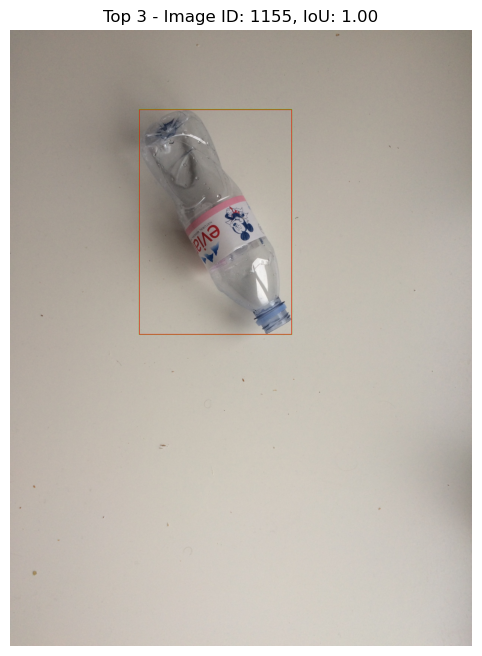

Carton


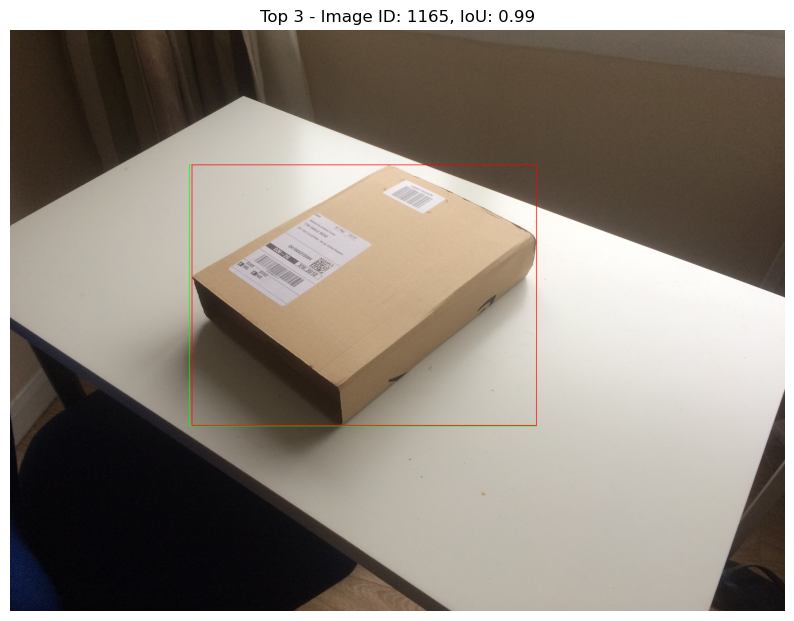

Can


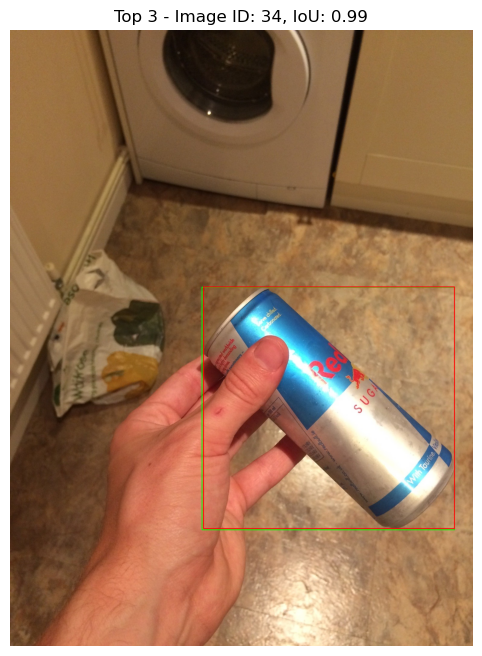

Plastic container


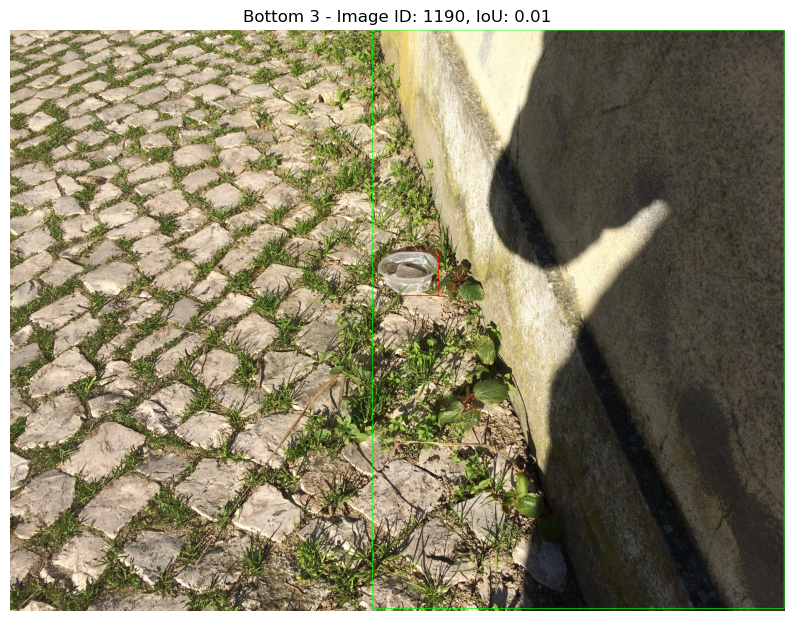

Can


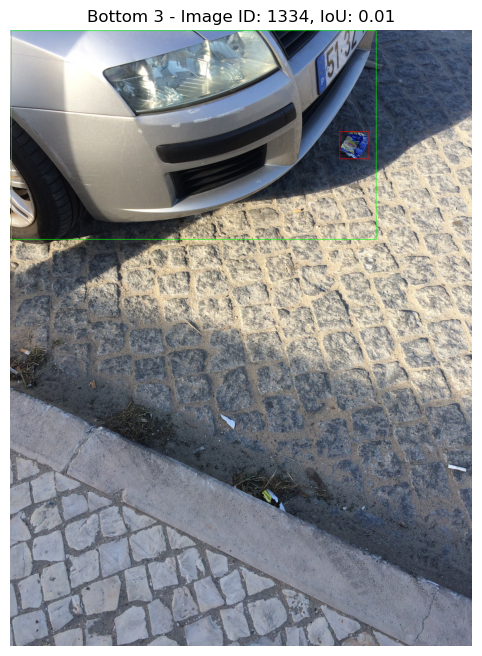

Lid


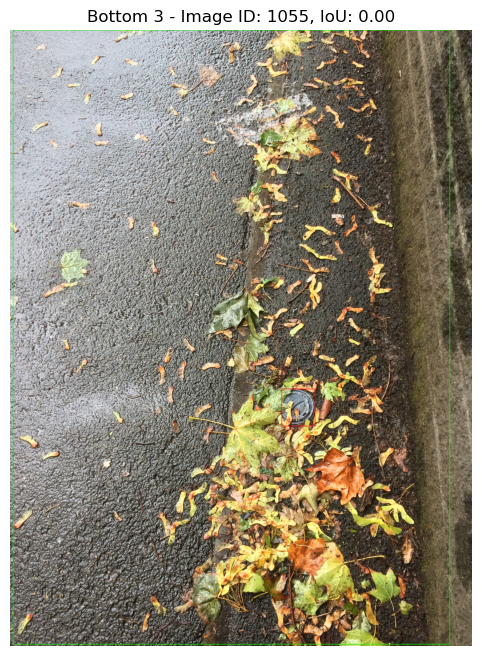

In [14]:
# Show images for top 3 and bottom 3 IoU
for category, results in [("Top 3", top_3), ("Bottom 3", bottom_3)]:
    for result in results:
        image_id = result["image_id"]
        detected_bbox = result.get("detected_bbox")
        actual_bbox = result.get("actual_bbox")
        iou = result["iou"]
        # Derive the class name (modify this if needed based on your data structure)        
        # Construct the image path
        image_path = os.path.join(image_folder, "test", result['supercategory'], f"{image_id}.jpg")
        
        # Read and process the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image not found: {image_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

        # Draw detected bbox (green)
        if detected_bbox:
            x_min, y_min, x_max, y_max = map(int, detected_bbox)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # Draw actual bbox (blue)
        if actual_bbox:
            x_min, y_min, x_max, y_max = map(int, actual_bbox)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

        # Display the image
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.title(f"{category} - Image ID: {image_id}, IoU: {iou:.2f}")
        plt.axis('off')
        plt.show()


## Summarize IoU Results

IoU statistics (e.g., mean IoU, proportion of IoUs above 0.5) are computed and displayed. These metrics provide insights into the model's detection accuracy and reliability.


In [15]:
# Compute Mean IoU
total_iou = sum(item["iou"] for item in output_data if item["iou"] > 0)
non_zero_count = sum(1 for item in output_data if item["iou"] > 0)
mean_iou = total_iou / non_zero_count if non_zero_count > 0 else 0

print(f"Mean IoU (mIoU): {mean_iou:.4f}")

Mean IoU (mIoU): 0.6811


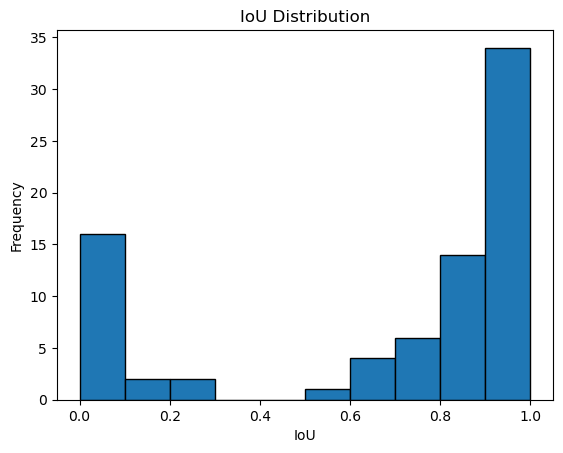

In [16]:
import matplotlib.pyplot as plt

# Extract IoUs
ious = [item["iou"] for item in output_data if item["iou"] > 0]

# Plot IoU distribution
plt.hist(ious, bins=10, range=(0, 1), edgecolor='black')
plt.title("IoU Distribution")
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.show()


In [17]:
# Proportion of IoUs > 0.5
high_quality_iou_count = sum(1 for item in output_data if item["iou"] > 0.5)
high_quality_ratio = high_quality_iou_count / len(output_data) if len(output_data) > 0 else 0

print(f"Proportion of IoUs > 0.5: {high_quality_ratio:.4f}")


Proportion of IoUs > 0.5: 0.7468
